In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import path

from scipy.special import ellipk, ellipe

from scipy.interpolate import griddata
from scipy.integrate import simps
from matplotlib.patches import Circle

from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [2]:


def Veffective(rho,sigma,n_epsilon,R):
    pf = np.pi*n_epsilon*(sigma**3)/3.0
    t9 = v9(rho/R)*((sigma/R)**9)
    t3 = v3(rho/R)*((sigma/R)**3)
    return pf*(t9-t3)

def Veffective_AB(rho,A,B,R):
    t9 = A*v9(rho/R)*((1.0/R)**9)
    t3 = B*v3(rho/R)*((1.0/R)**3)
    return t9-t3

def Vshell(rho,sigma,n,R1,R2):
    pf = np.pi*n*(sigma**3)/3.0
    t9 = v9(rho/R1)*((sigma/R1)**9)
    t3 = v3(rho/R1)*((sigma/R1)**3)
    y9 = v9(rho/R2)*((sigma/R2)**9)
    y3 = v3(rho/R2)*((sigma/R2)**3)
    return pf*(y3-y9+t9-t3)

def v9(x):
    pf = 1.0/(240.0*((1.0-(x**2))**9))
    t1 = (1091.0 + (11156.0*(x**2)) + (16434.0*(x**4)) + (4052.0*(x**6)) + (35*(x**8)))*ellipe(x**2)
    t2 = 8.0 * (1.0-(x**2)) * (1.0 + (7.0*(x**2))) * (97.0 + (134.0*(x**2)) + (25.0*(x**4))) * ellipk(x**2)
    return pf*(t1-t2)

def v3(x):
    pf = 2.0/((1.0-(x**2))**3)
    t1 = (7.0 + (x**2)) * ellipe(x**2)
    t2 = 4.0 * (1.0-(x**2)) * ellipk(x**2)
    return pf*(t1-t2)

def U(r,sigma,epsilon):
    """standard 12-6 Lennard-Jones"""
    pf = 4.0 * epsilon
    t12 = (sigma/r)**12
    t6 = (sigma/r)**6
    return pf * (t12 - t6)

def U_mb(r,sigma,epsilon):
    V = 0.0
    for i in range(len(r)):
        V += U(r[i],sigma[i],epsilon[i])
    return V

#First we define a few helper functions to go between Cartesian and Polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def U_min(r,sigma,n,R):
    return Veffective(r,sigma,n,R)

def get_average_fit_parameter2(fit_parameter,name="fit_parameter",plot_results=True,silent=False):
    mean_fit_parameter = np.mean(fit_parameter[fit_parameter >= 0])
    std_fit_parameter = np.std(fit_parameter[fit_parameter >= 0],ddof=1)
    not_min_outlier_ind = fit_parameter >= (mean_fit_parameter - (2*std_fit_parameter))
    not_max_outlier_ind = fit_parameter <= (mean_fit_parameter + (2*std_fit_parameter))
    not_outlier_ind = not_min_outlier_ind*not_max_outlier_ind
    new_mean_fit_parameter = np.mean(fit_parameter[not_outlier_ind])
    if not silent:
        print("{} values in original {} dataset".format(len(fit_parameter),name))
    while True:  
        if not silent:
            print("{} values in truncated {} dataset".format(len(fit_parameter[not_outlier_ind]),name))
        mean_fit_parameter = new_mean_fit_parameter
        std_fit_parameter = np.std(fit_parameter[not_outlier_ind],ddof=1)
        not_min_outlier_ind = fit_parameter >= (mean_fit_parameter - (2*std_fit_parameter))
        not_max_outlier_ind = fit_parameter <= (mean_fit_parameter + (2*std_fit_parameter))
        not_outlier_ind = not_min_outlier_ind*not_max_outlier_ind
        new_mean_fit_parameter = np.mean(fit_parameter[not_outlier_ind])
        if new_mean_fit_parameter == mean_fit_parameter:
            break
    std_fit_parameter = np.std(fit_parameter[not_outlier_ind],ddof=1)/np.sqrt(len(fit_parameter[not_outlier_ind]))
    if plot_results:
        fig,ax = plt.subplots()
        ax.plot(fit_parameter[not_outlier_ind])
        ax.axhline(new_mean_fit_parameter)
        ax.set_title(name)
    return new_mean_fit_parameter, std_fit_parameter, not_outlier_ind

In [3]:
fn_Vmesh = "../Data/mcm-41_-20.000_20.000_-20.000_20.000_100j_manybody-potential"
fn_rmeshpoints = "../Data/mcm-41_-20.000_20.000_-20.000_20.000_100j_testpoints"
Vmesh=np.load("{}.npy".format(fn_Vmesh))
rmeshpoints=np.load("{}.npy".format(fn_rmeshpoints))
res_mesh = 100

In [4]:
interpolate_res = 1000j
grid_x, grid_y = np.mgrid[np.min(rmeshpoints[:,0]):np.max(rmeshpoints[:,0]):interpolate_res, np.min(rmeshpoints[:,1]):np.max(rmeshpoints[:,1]):1000j]
grid_z0 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='nearest')
grid_z1 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='linear')
grid_z2 = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x, grid_y), method='cubic')

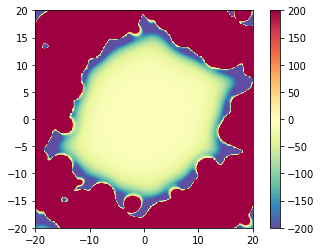

In [5]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200,cmap="Spectral_r")
cbar = fig.colorbar(im)
fn = "../plots/{}_interpolated_{}".format(path.basename(fn_Vmesh),interpolate_res)
#fig.savefig(fn + '.svg')
#fig.savefig(fn + '.png',dpi=400)

Here we have loaded the 2d potential and interpolated on a cartesian plane. Now let's move to polar coordinates and inerpolate.

# 2D interpolation of data in polar coordinates

In [6]:
# The maximum length for our polar coordinates interpolation will be the shortest distance to one of the edges
r_max = min(np.abs(np.min(rmeshpoints[:,0])),np.max(rmeshpoints[:,0]), np.abs(np.min(rmeshpoints[:,1])),np.max(rmeshpoints[:,1]))

# Creating the 2d mesh for interpolation
interpolate_res_r = 1001j
interpolate_res_phi = interpolate_res_r - 1j
grid_r, grid_phi = np.mgrid[0:r_max:interpolate_res_r, 0:360 - abs(360 / interpolate_res_phi):interpolate_res_phi]
#NOTE: 360 degrees not included

#convert the polar coordinate mesh to cartesian
grid_x_polar, grid_y_polar = pol2cart(grid_r,grid_phi*np.pi/180.0)

In [7]:
polar_nearest = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x_polar, grid_y_polar), method='nearest')
polar_linear = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x_polar, grid_y_polar), method='linear')
polar_cubic = griddata((rmeshpoints[:,0],rmeshpoints[:,1]), Vmesh, (grid_x_polar, grid_y_polar), method='cubic')

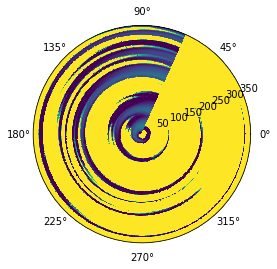

In [8]:

fig = plt.figure()
ax = fig.add_subplot(111,polar=True)
ax.pcolormesh(grid_r, grid_phi, polar_linear,vmin=-200,vmax=200) #X,Y & data2D must all be same dimensions

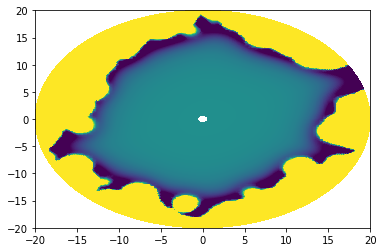

In [9]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(grid_x_polar, grid_y_polar, polar_linear,vmin=-200,vmax=200) #X,Y & data2D must all be same dimensions


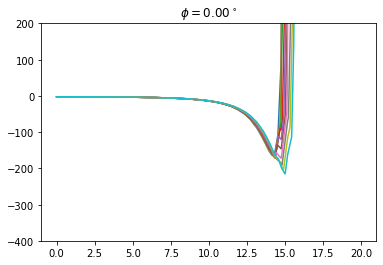

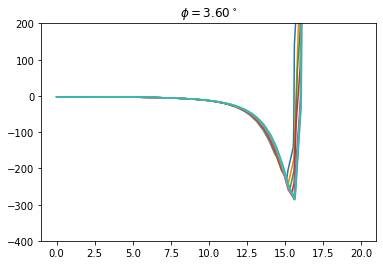

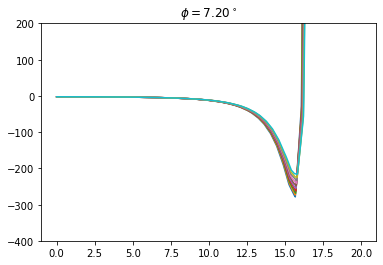

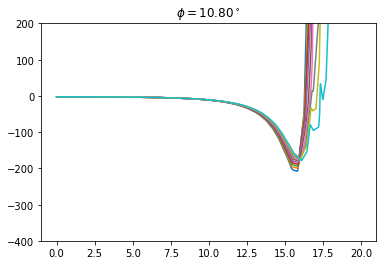

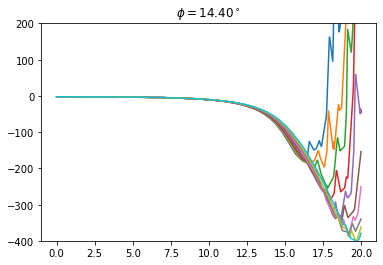

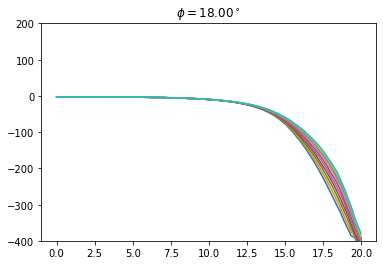

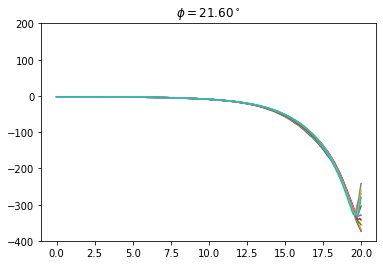

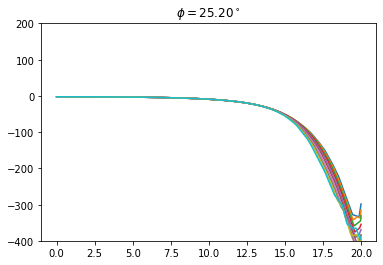

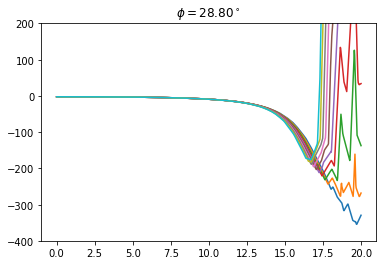

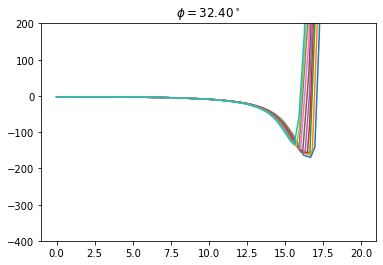

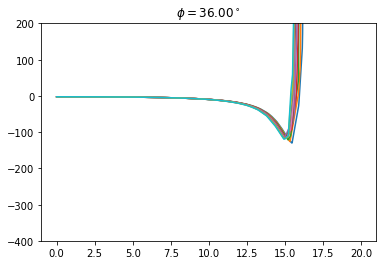

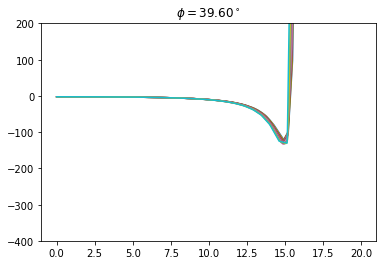

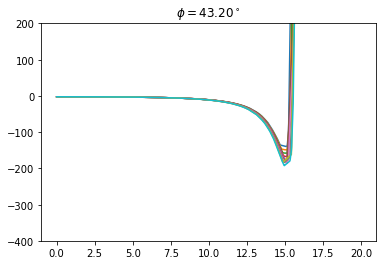

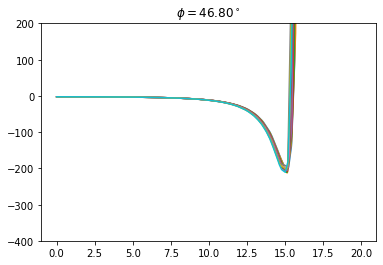

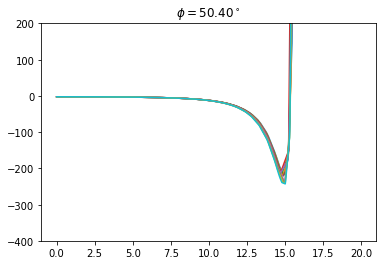

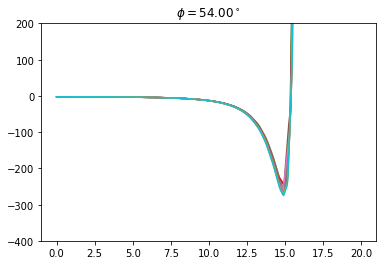

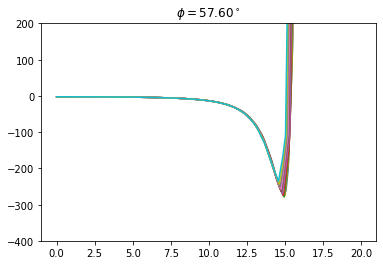

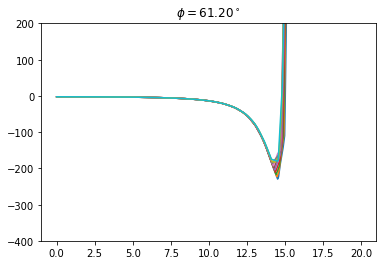

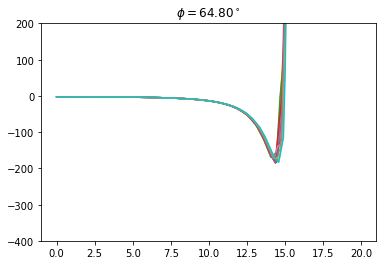

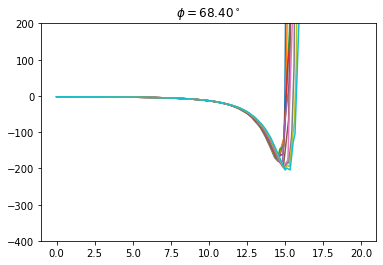

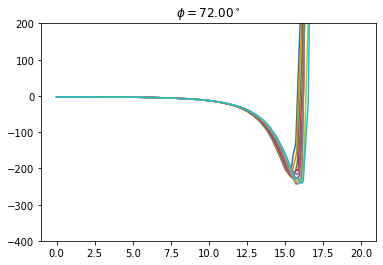

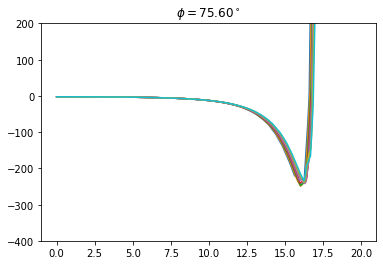

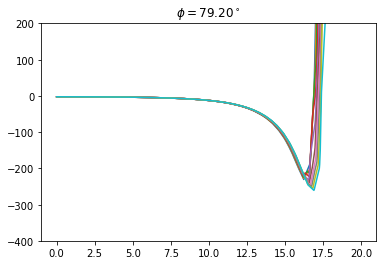

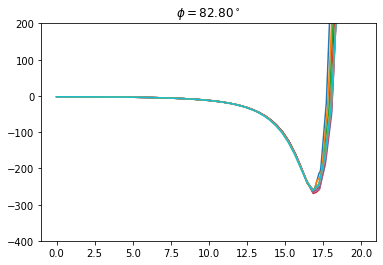

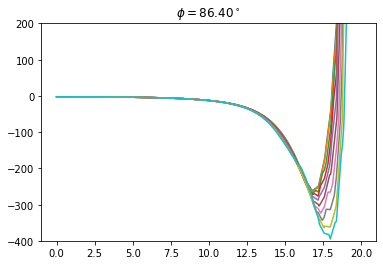

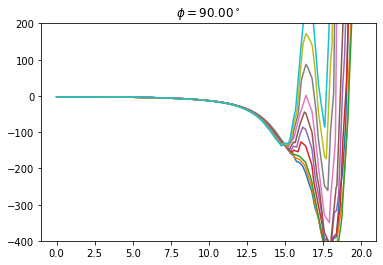

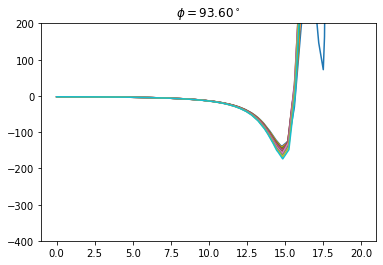

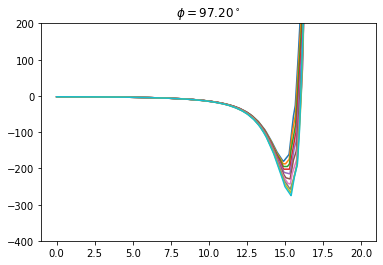

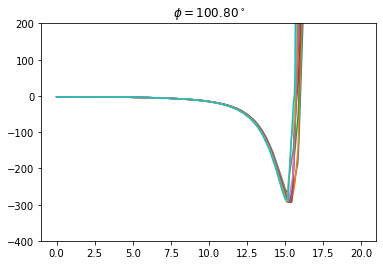

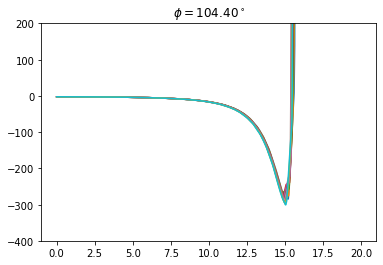

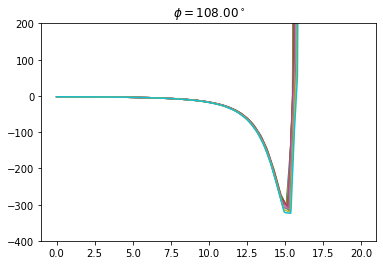

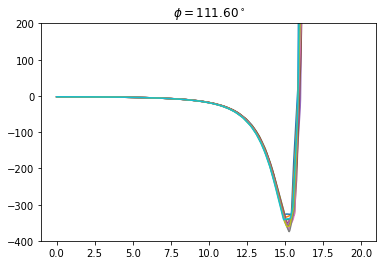

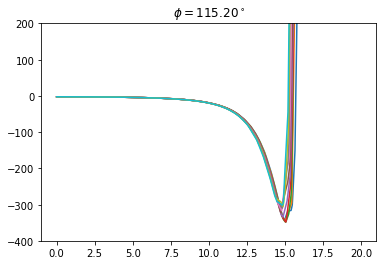

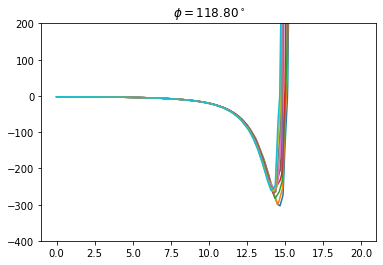

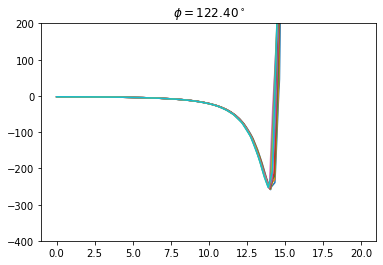

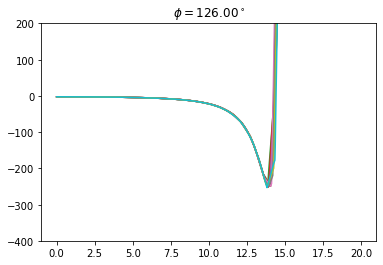

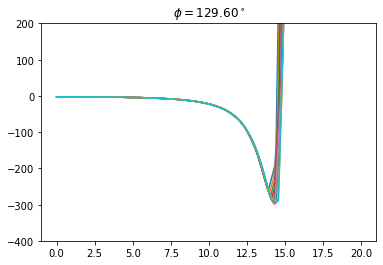

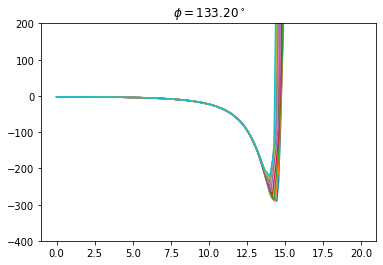

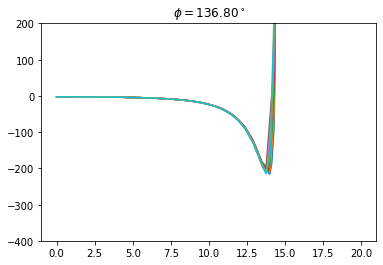

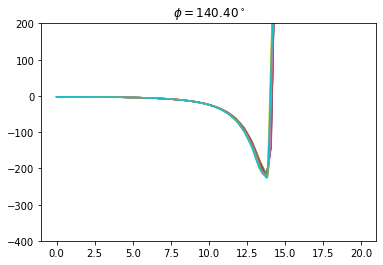

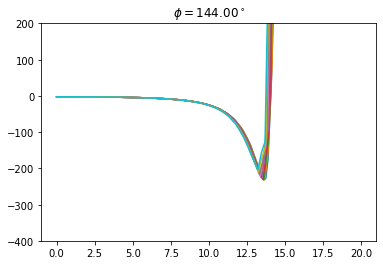

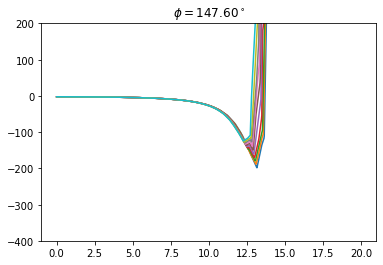

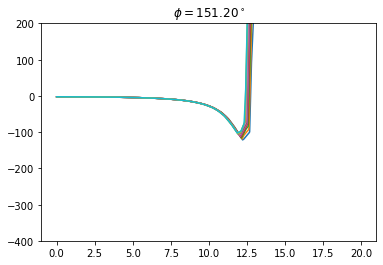

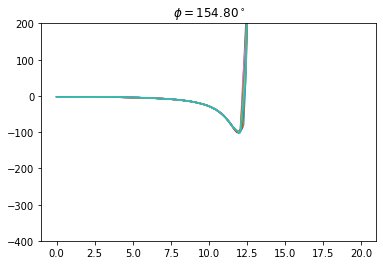

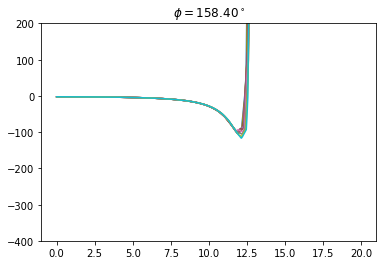

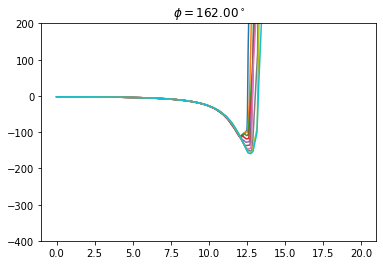

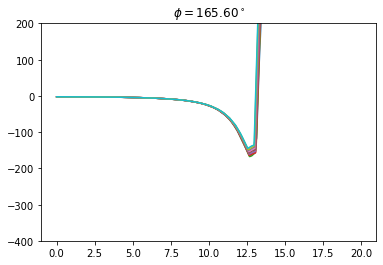

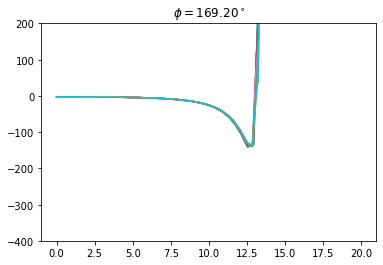

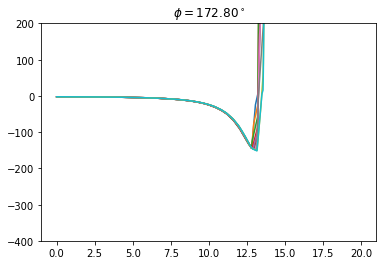

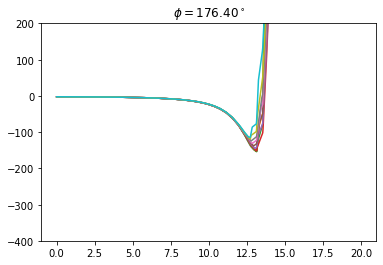

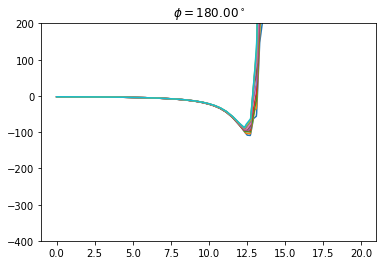

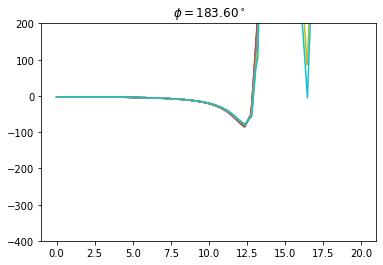

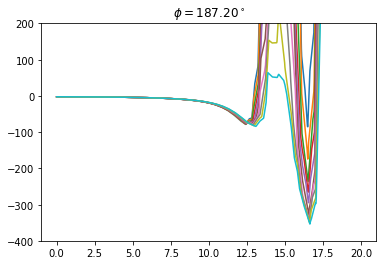

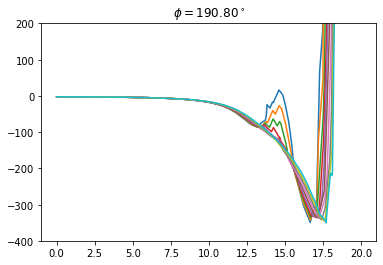

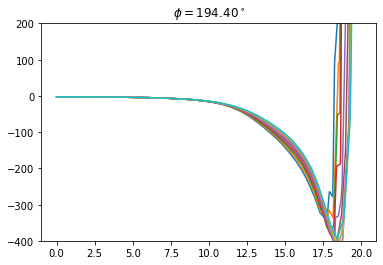

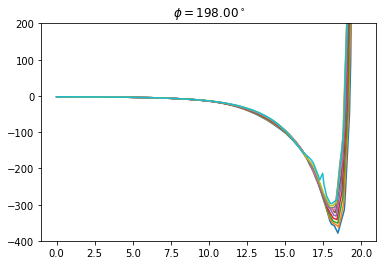

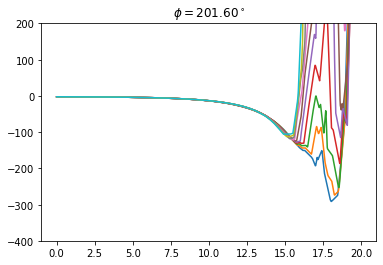

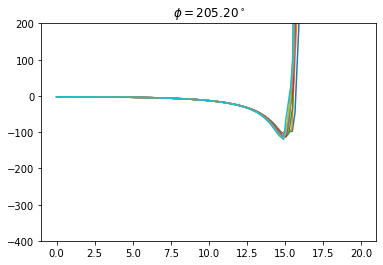

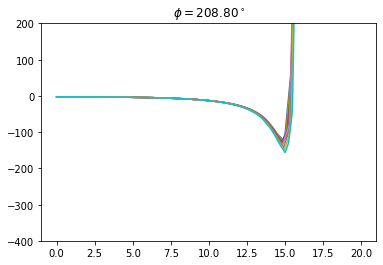

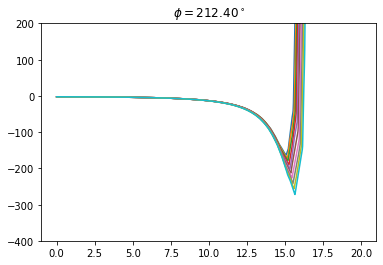

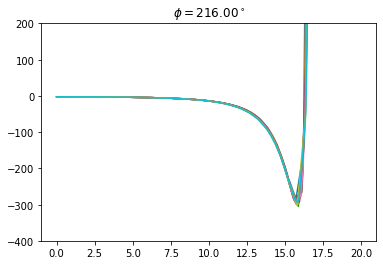

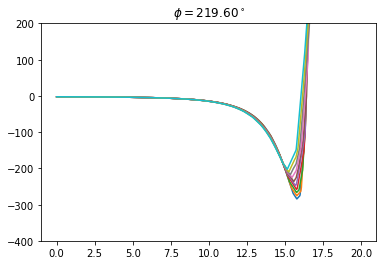

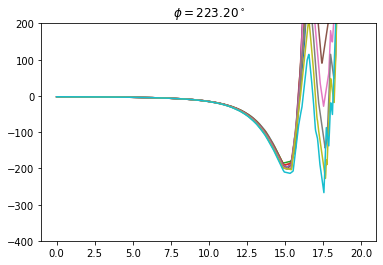

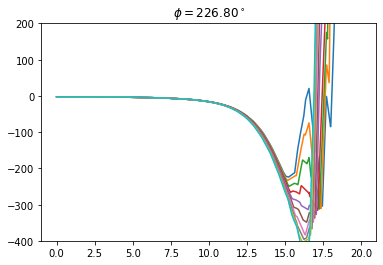

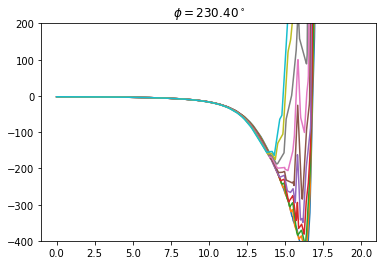

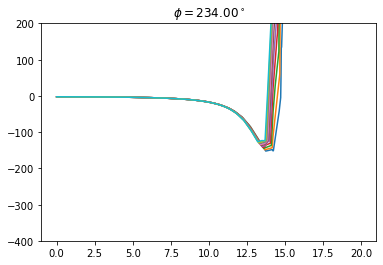

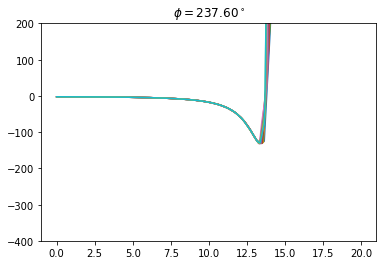

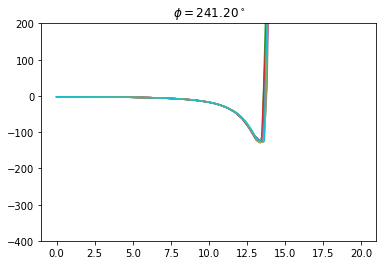

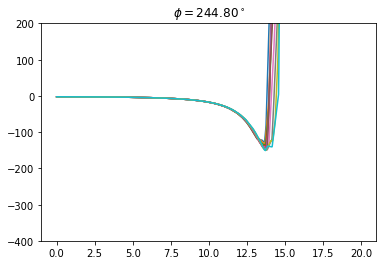

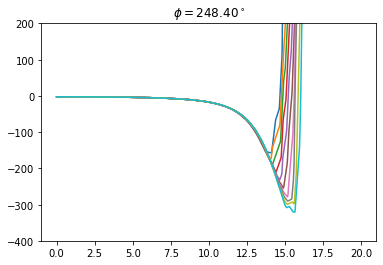

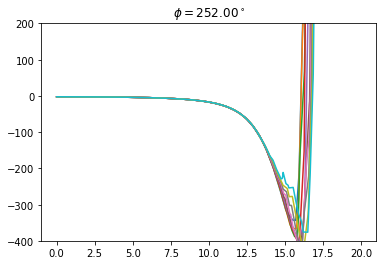

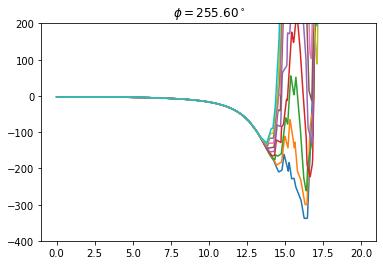

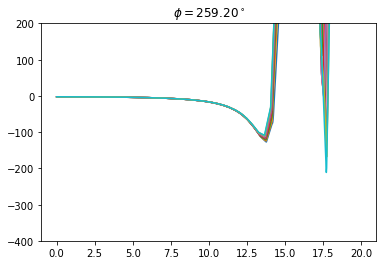

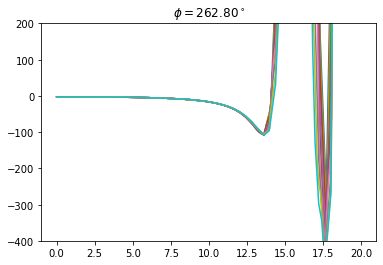

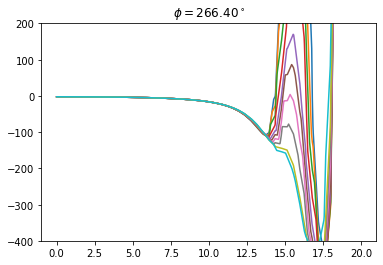

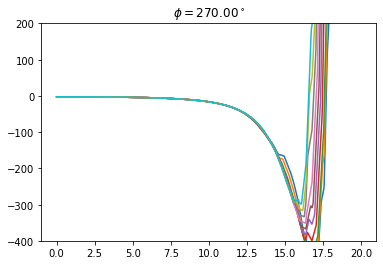

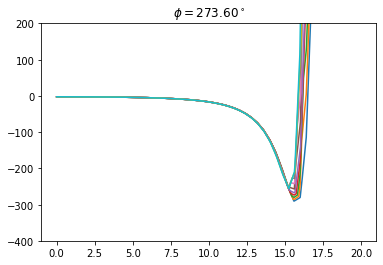

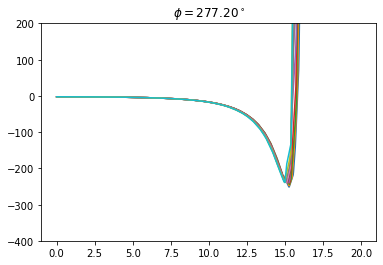

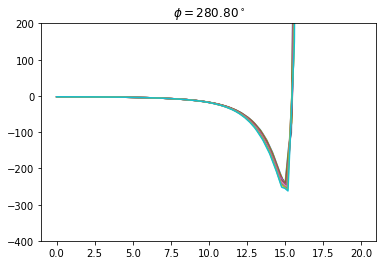

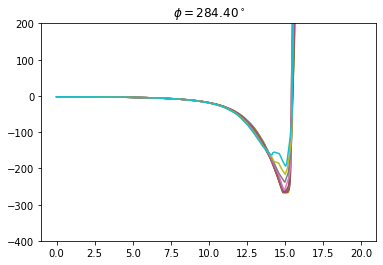

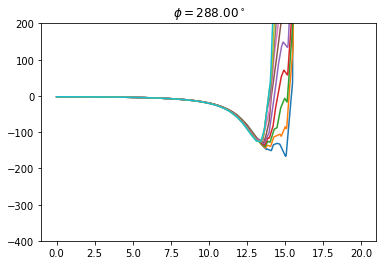

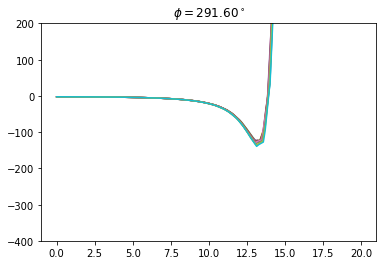

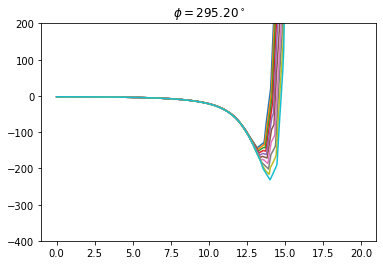

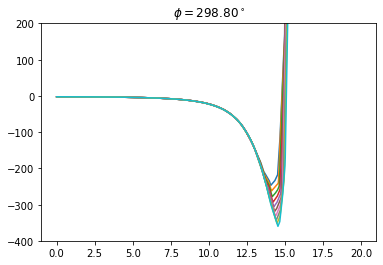

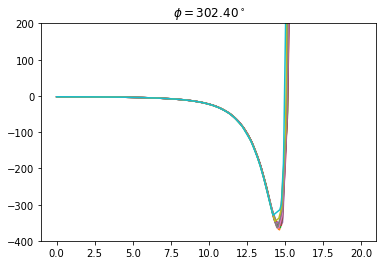

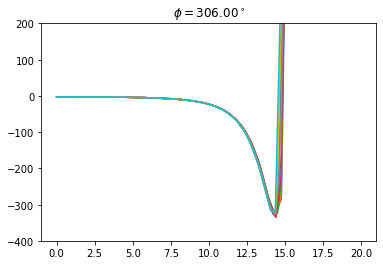

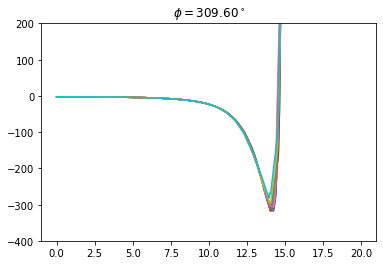

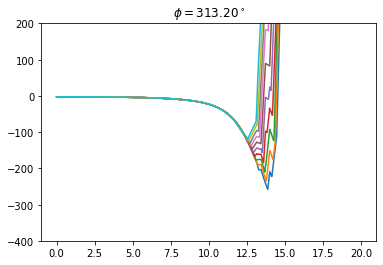

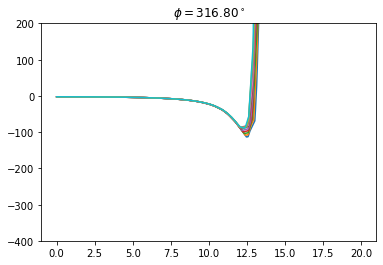

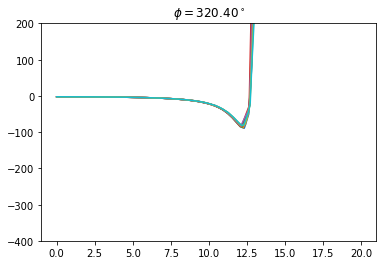

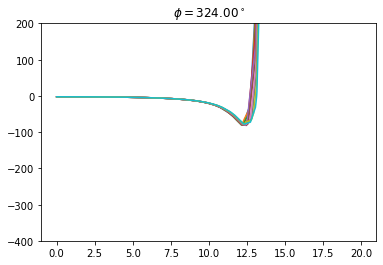

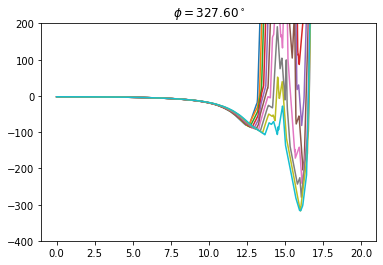

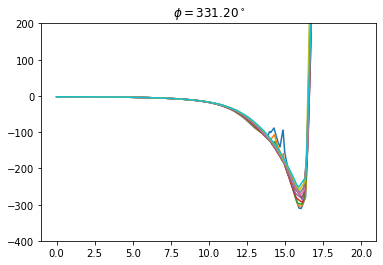

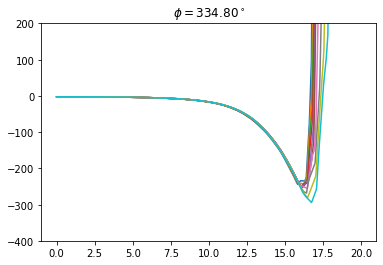

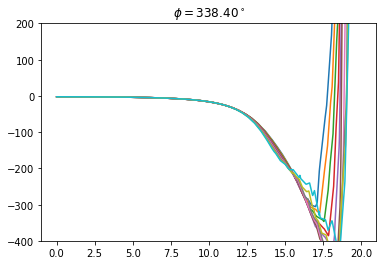

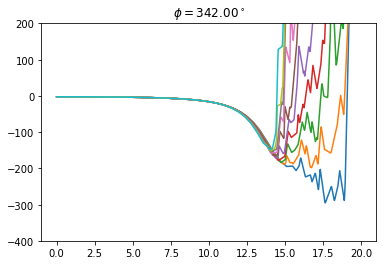

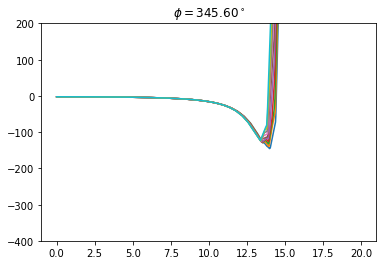

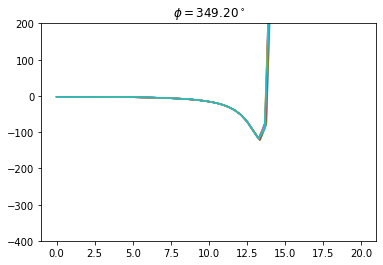

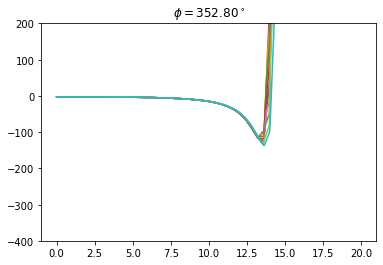

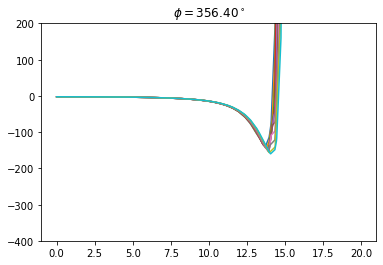

In [10]:
fig,ax = plt.subplots()
for i,phi in enumerate(grid_phi[0,:]):
    if i%10 == 0:
        if not i == 0:
            plt.show(fig)
        plt.close(fig)
        fig,ax = plt.subplots()
        ax.set_title(r"$\phi={:.2f}^\circ$".format(phi))
    ax.plot(grid_r[:,i],polar_linear[:,i])
    ax.set_ylim((-400,200))

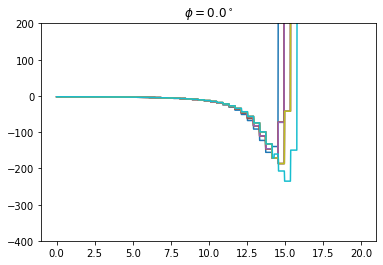

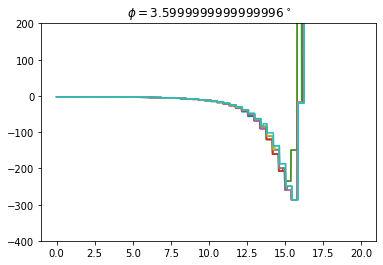

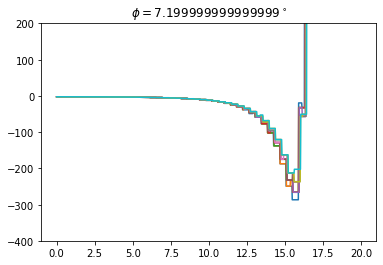

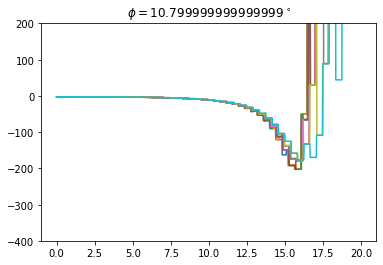

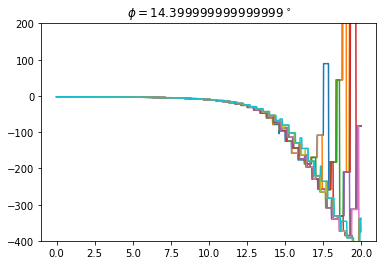

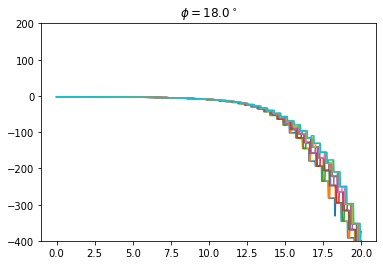

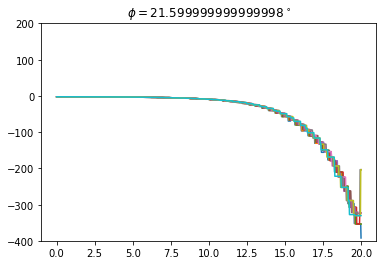

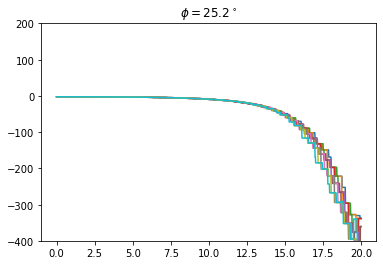

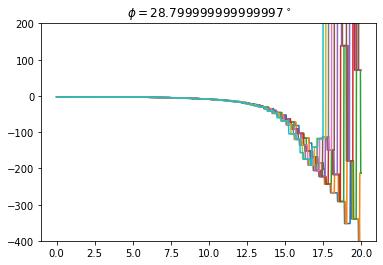

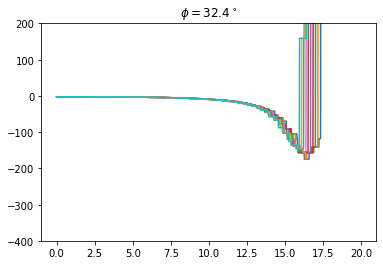

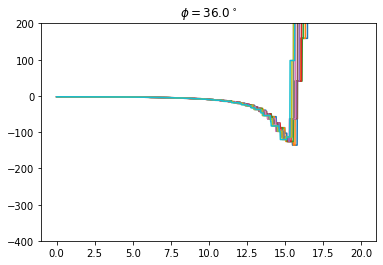

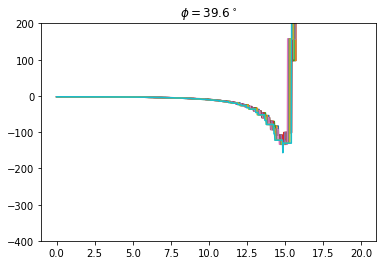

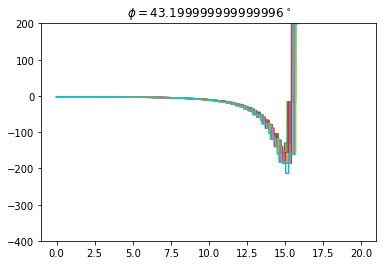

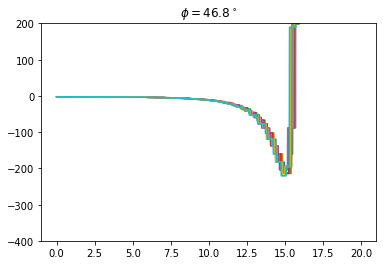

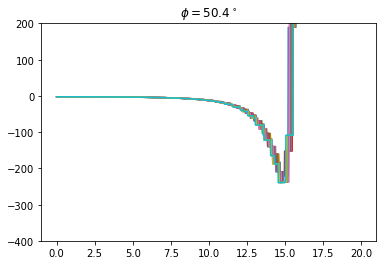

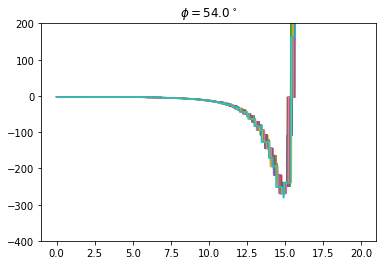

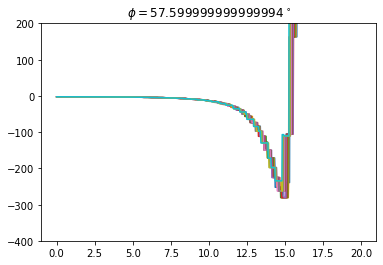

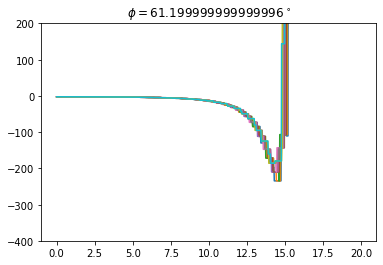

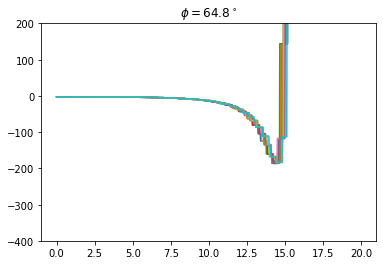

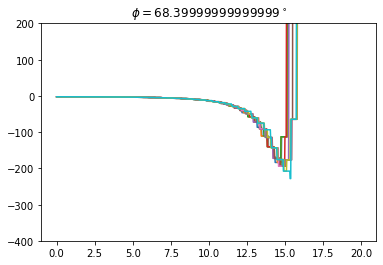

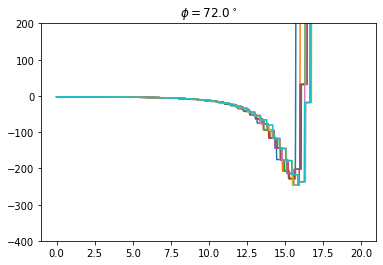

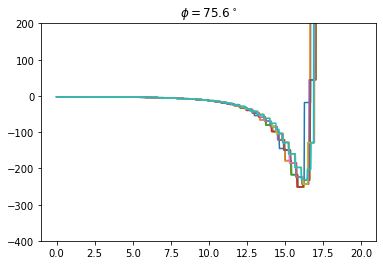

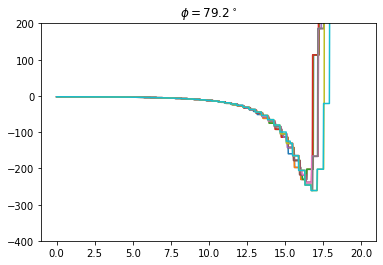

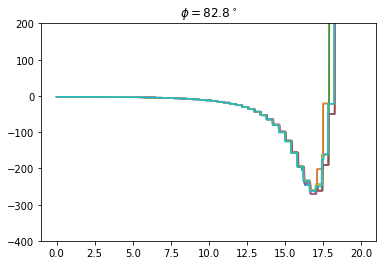

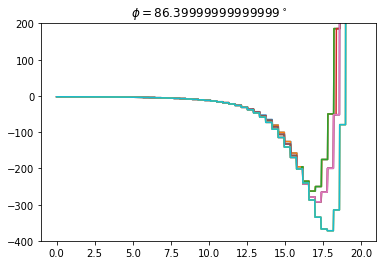

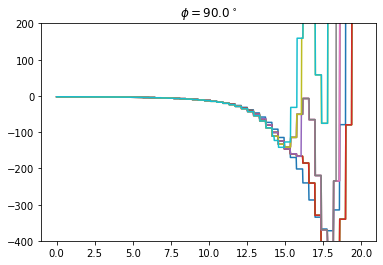

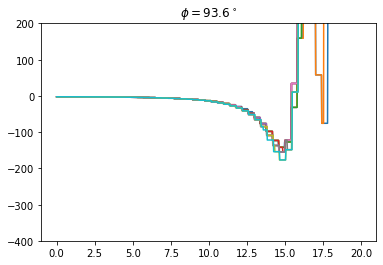

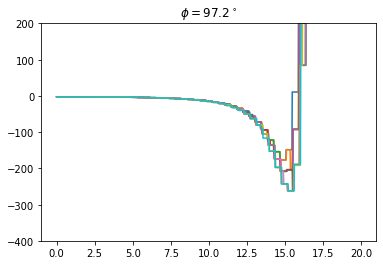

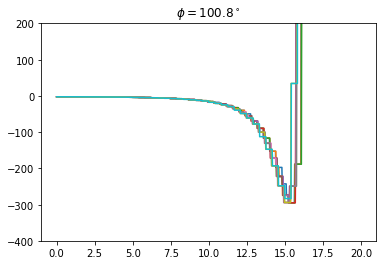

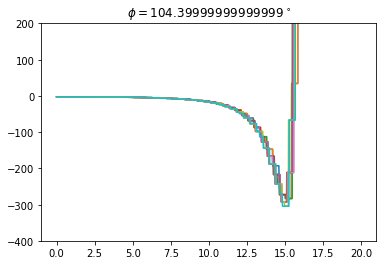

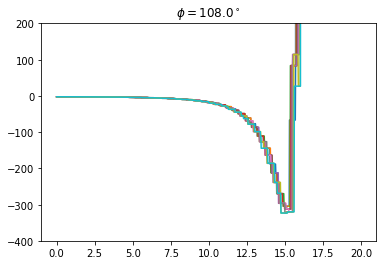

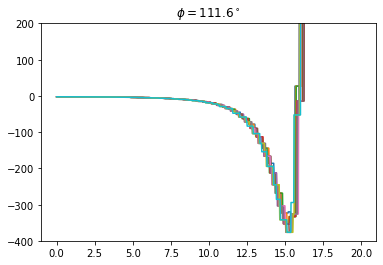

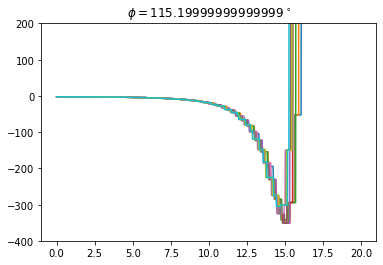

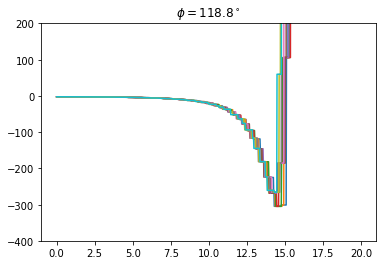

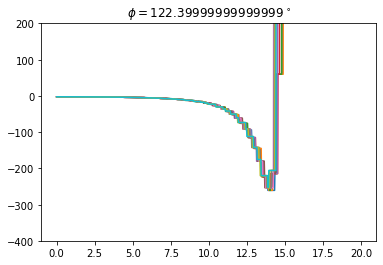

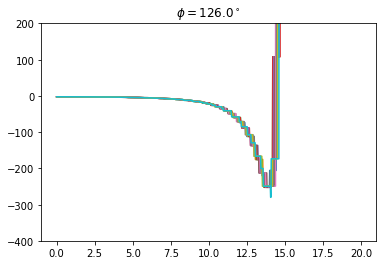

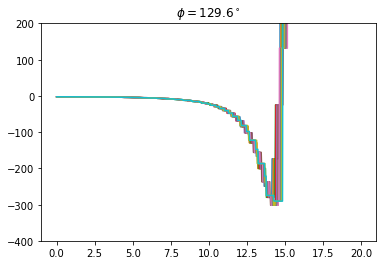

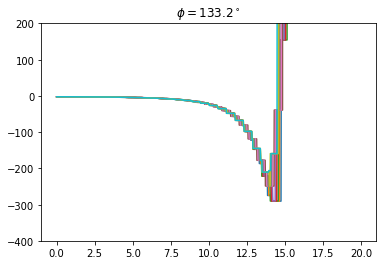

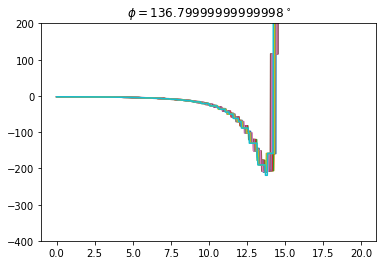

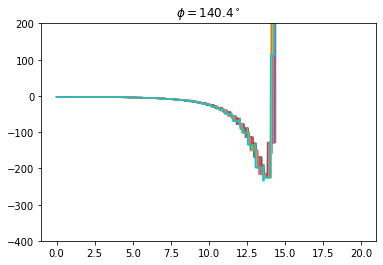

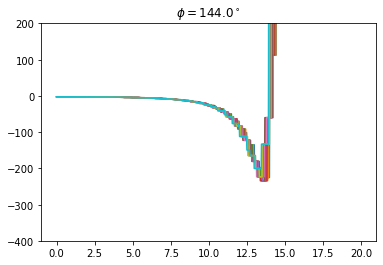

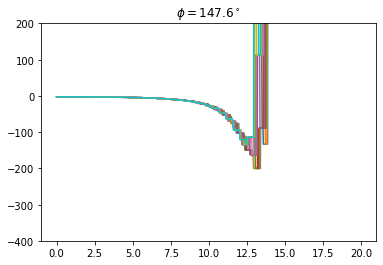

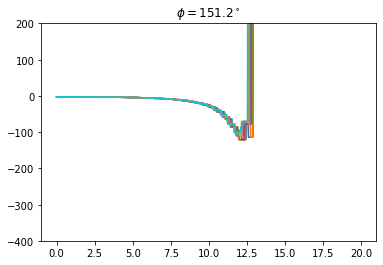

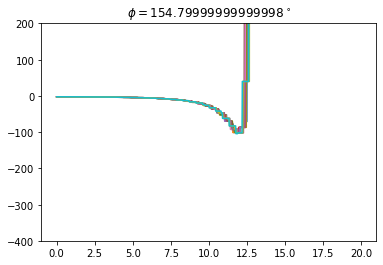

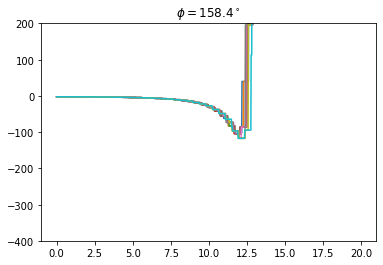

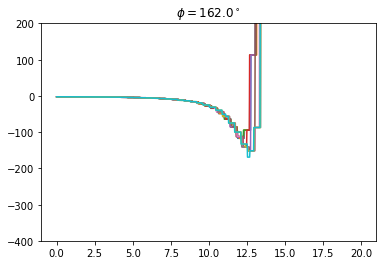

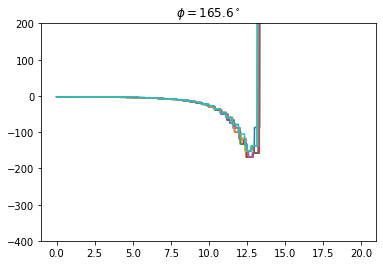

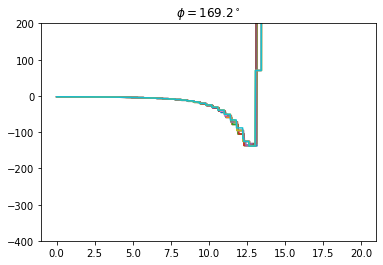

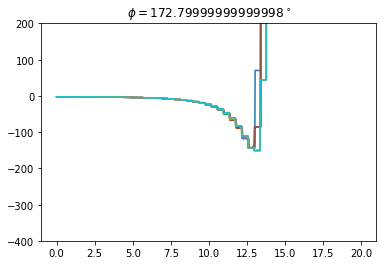

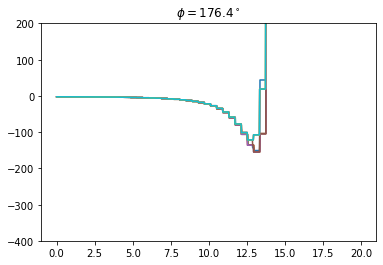

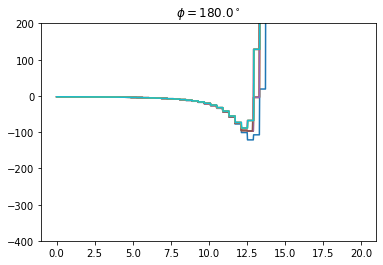

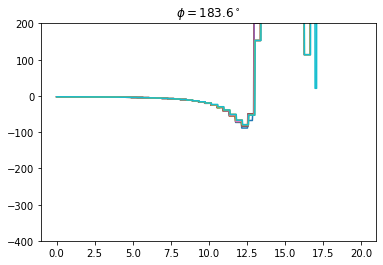

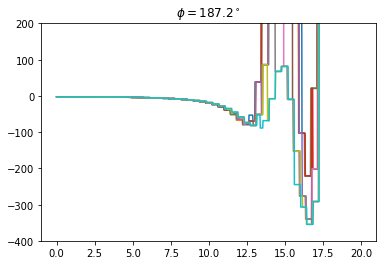

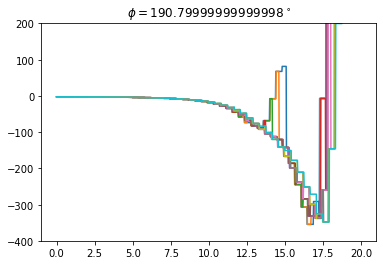

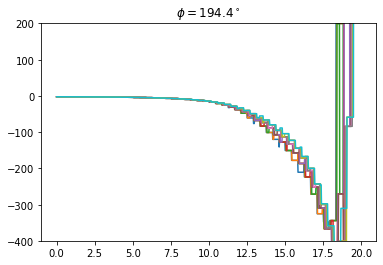

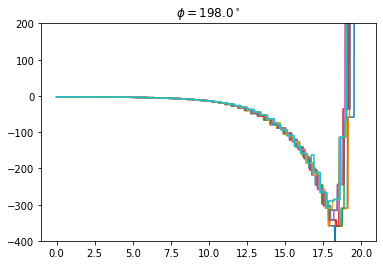

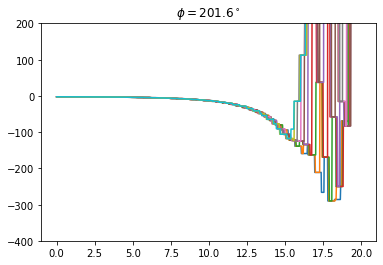

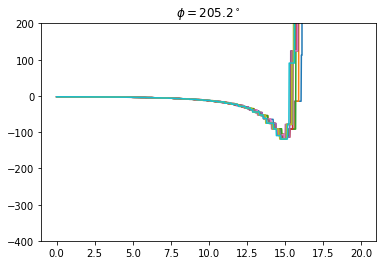

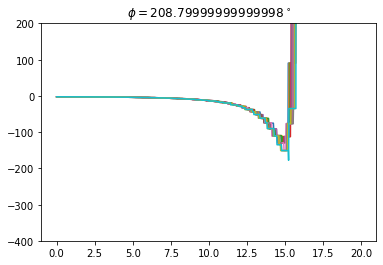

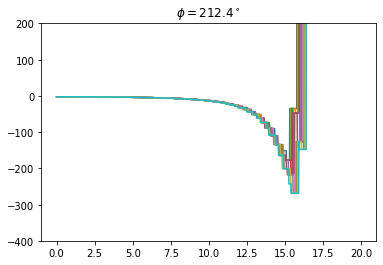

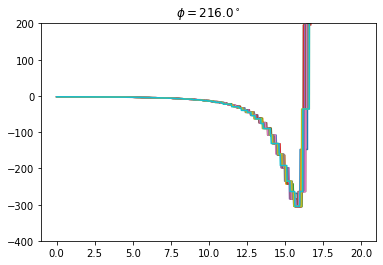

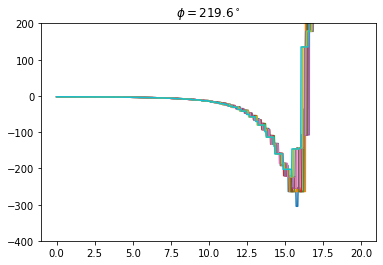

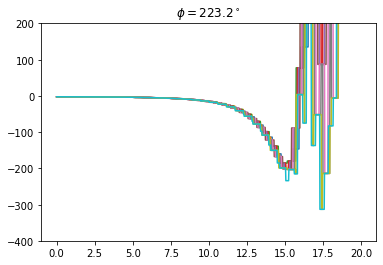

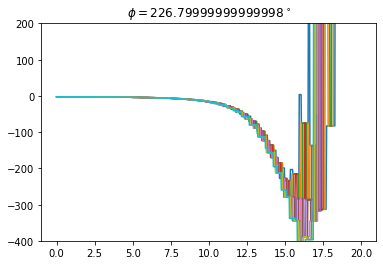

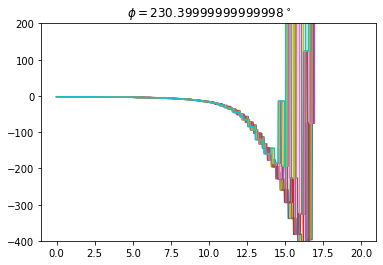

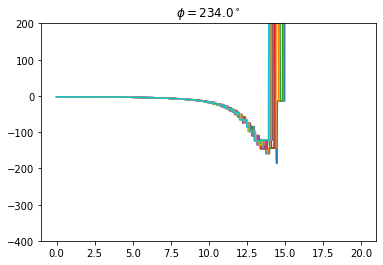

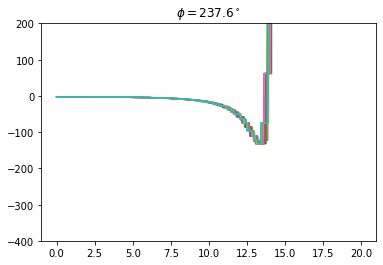

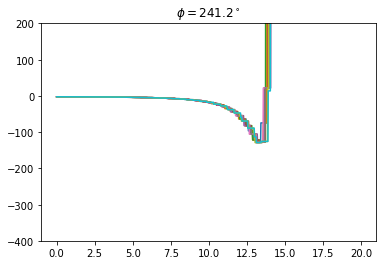

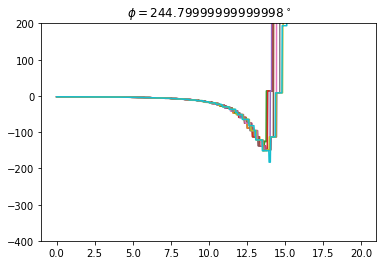

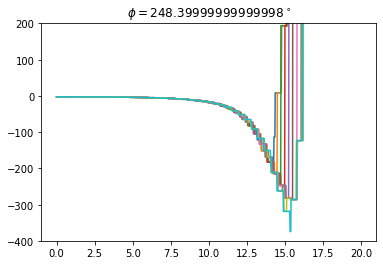

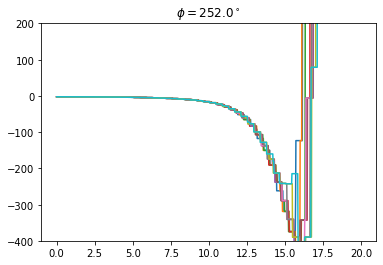

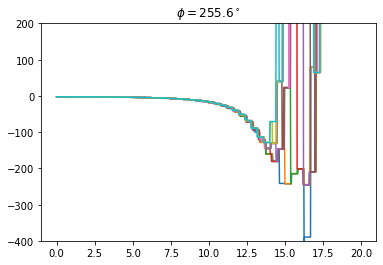

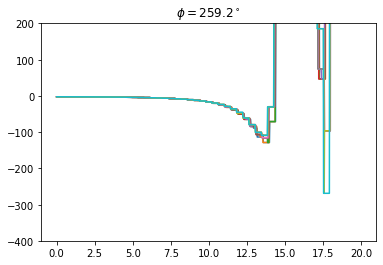

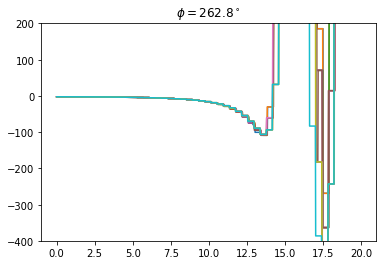

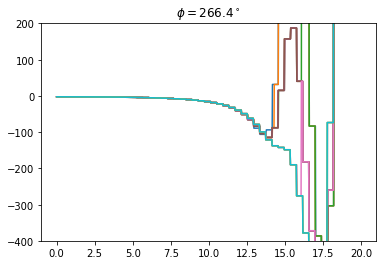

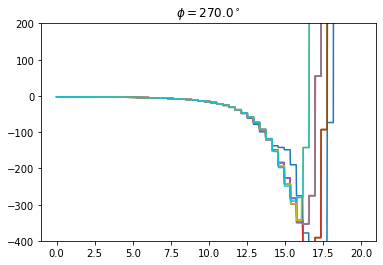

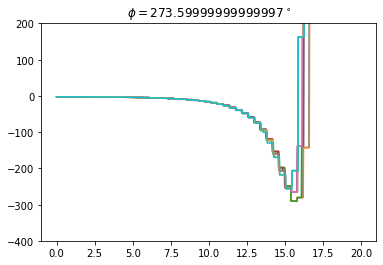

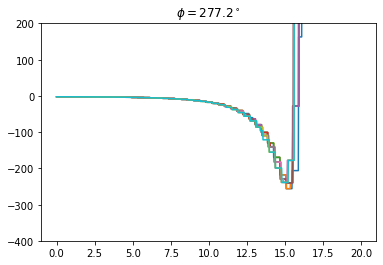

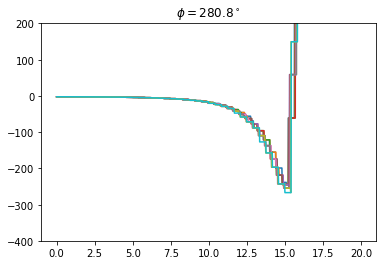

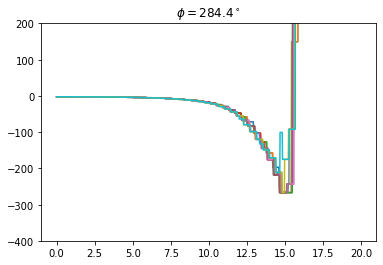

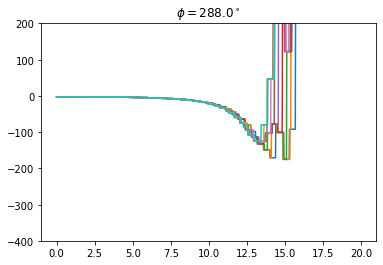

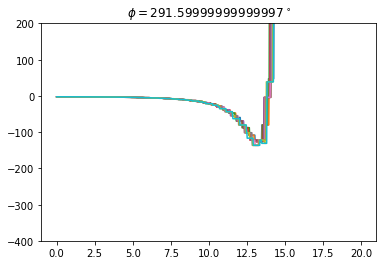

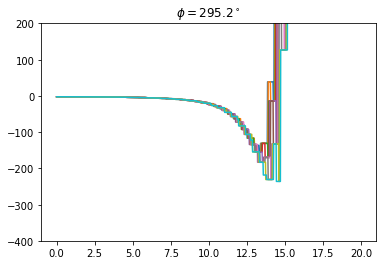

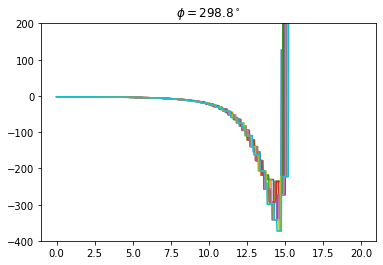

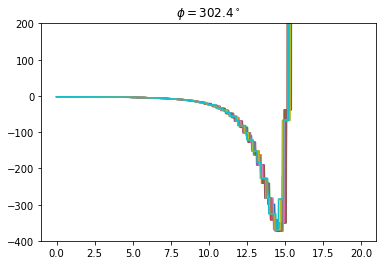

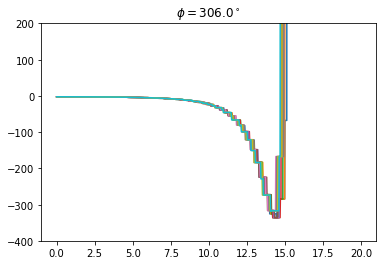

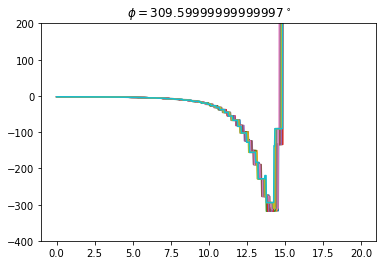

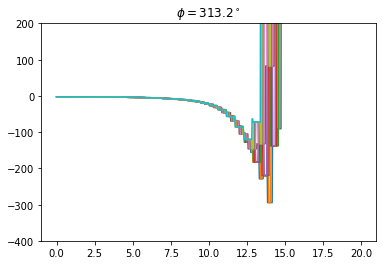

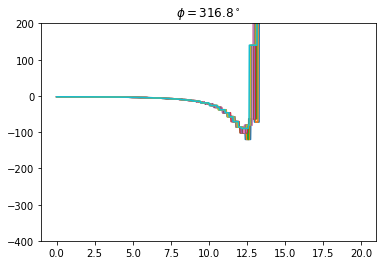

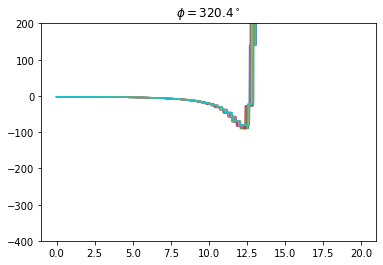

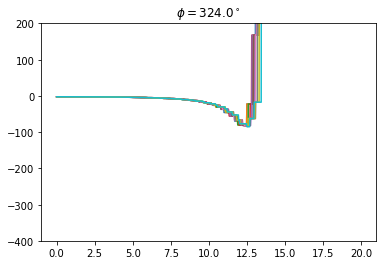

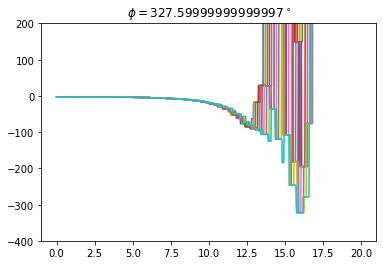

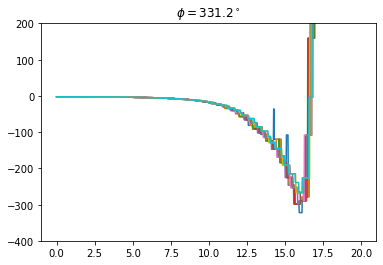

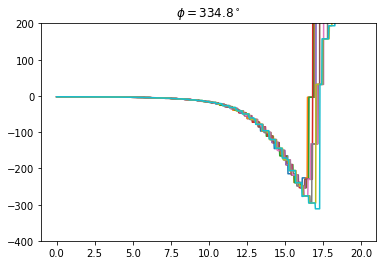

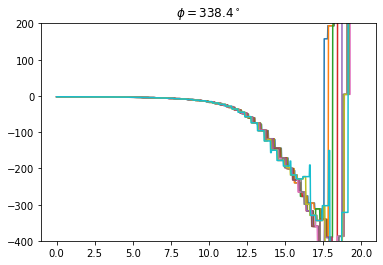

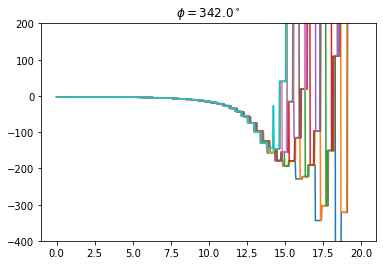

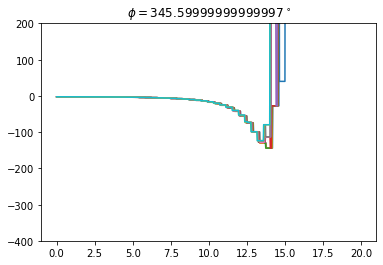

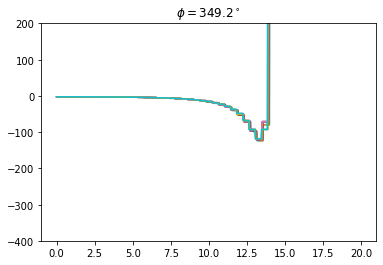

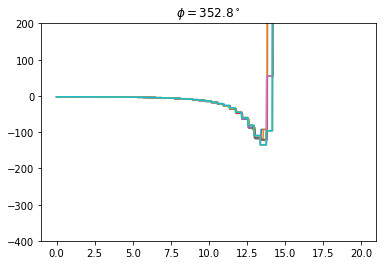

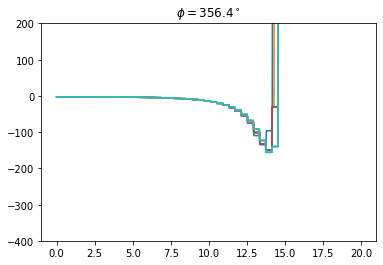

In [11]:
fig,ax = plt.subplots()
for i,phi in enumerate(grid_phi[0,:]):
    if i%10 == 0:
        if not i == 0:
            plt.show(fig)
        plt.close(fig)
        fig,ax = plt.subplots()
        ax.set_title(r"$\phi={}^\circ$".format(phi))
    ax.plot(grid_r[:,i],polar_nearest[:,i])
    ax.set_ylim((-400,200))

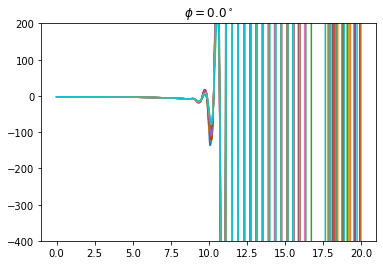

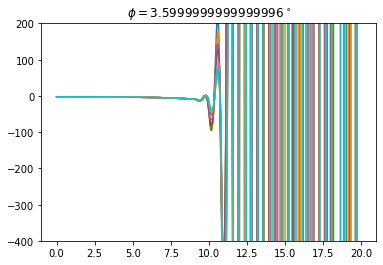

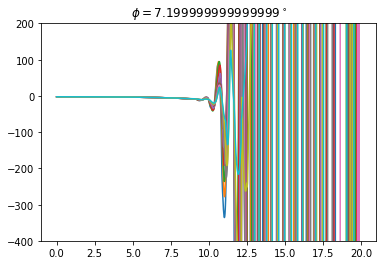

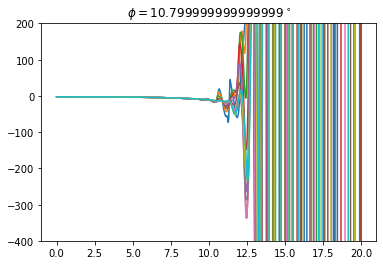

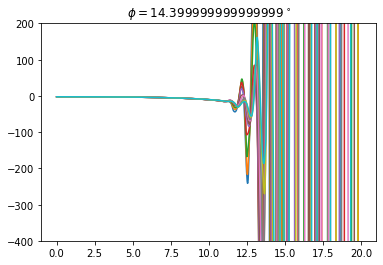

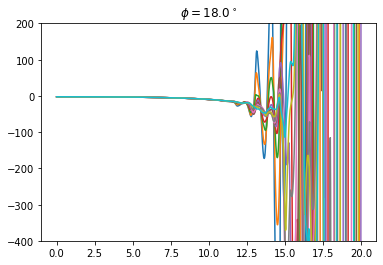

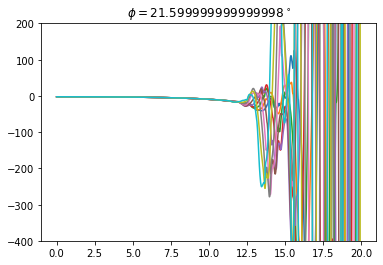

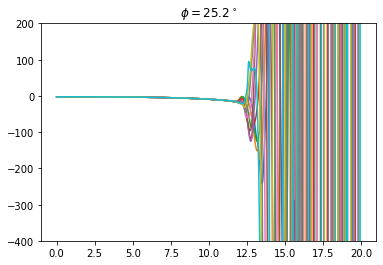

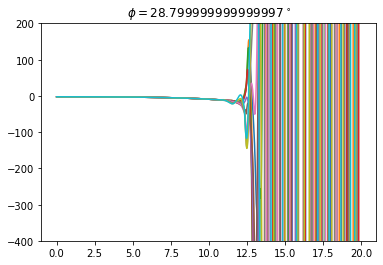

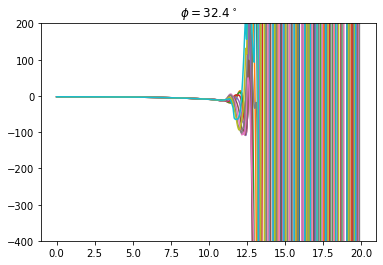

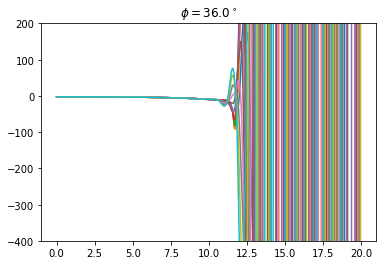

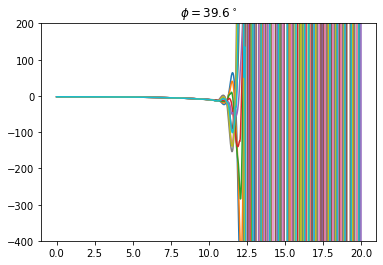

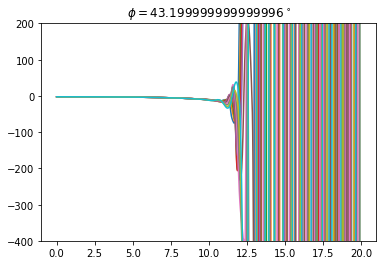

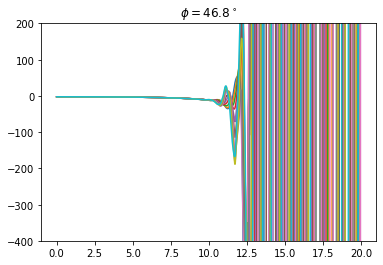

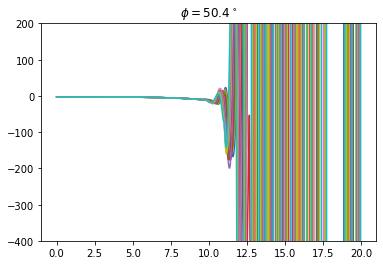

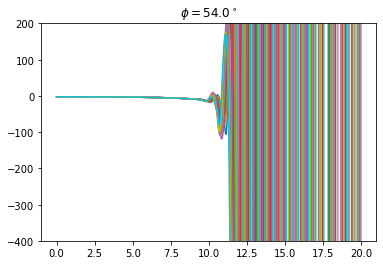

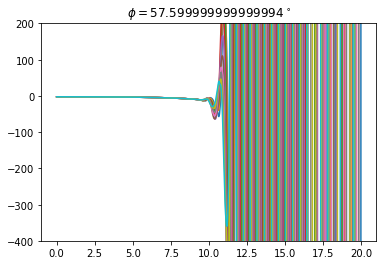

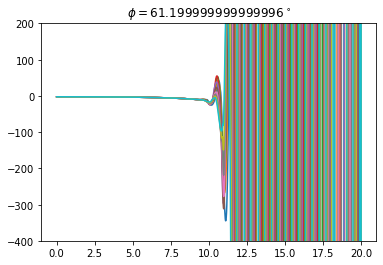

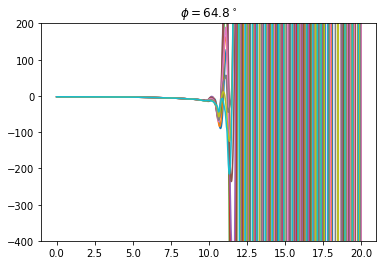

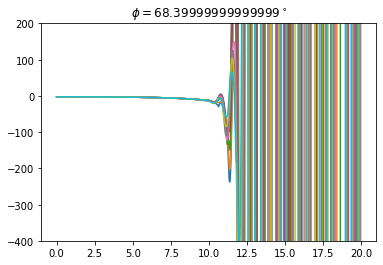

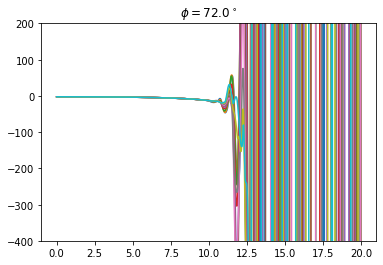

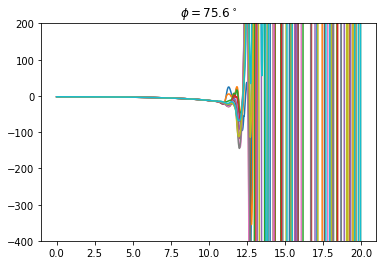

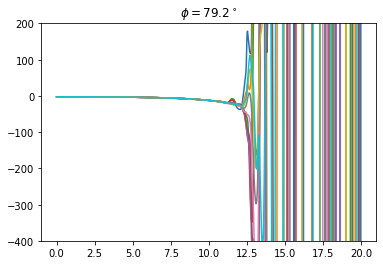

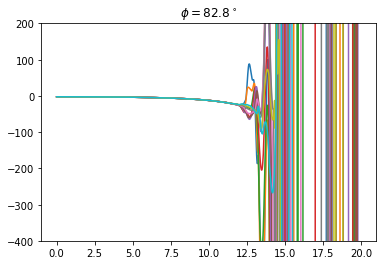

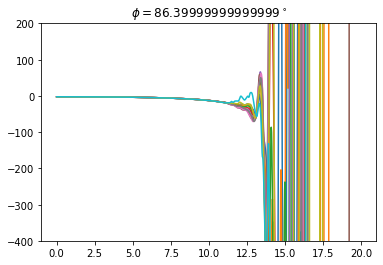

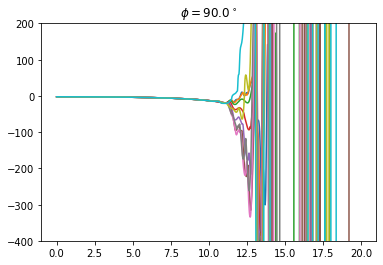

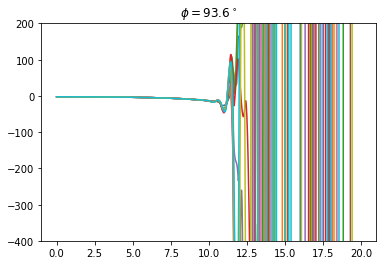

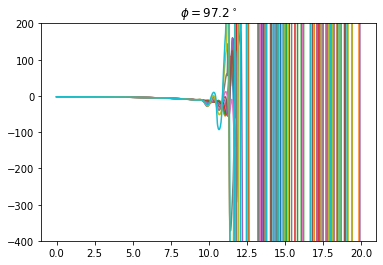

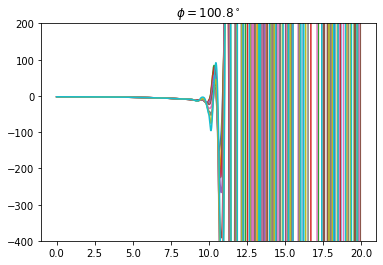

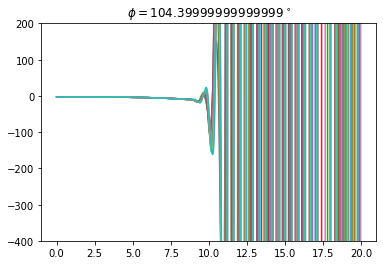

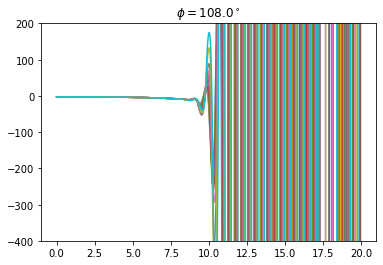

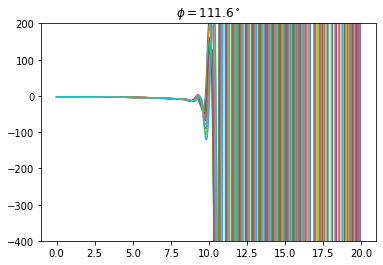

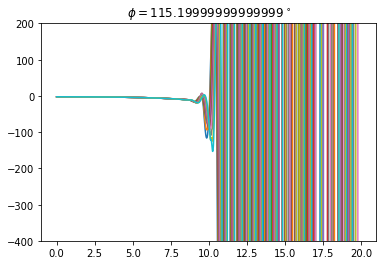

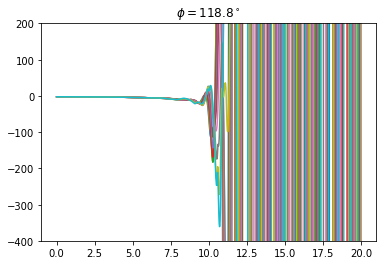

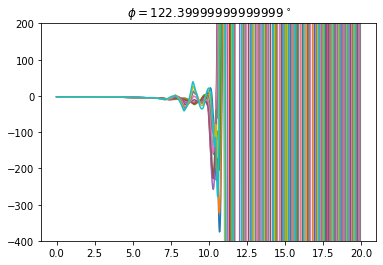

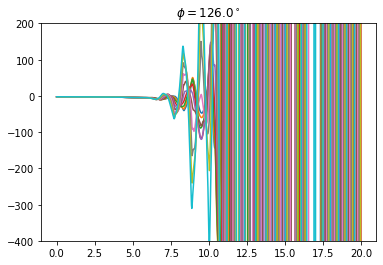

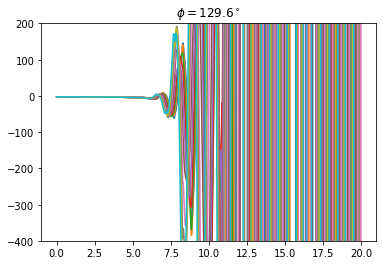

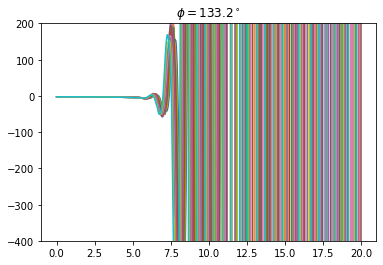

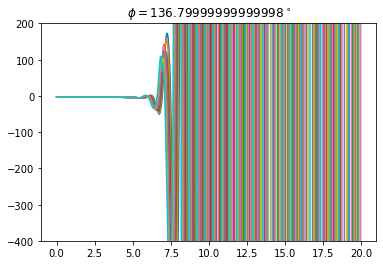

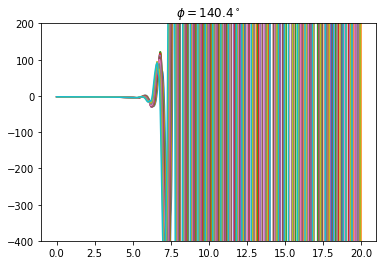

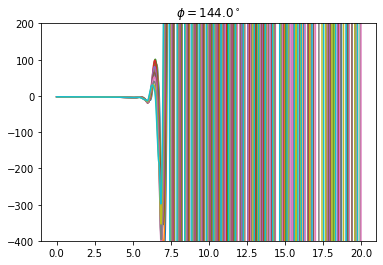

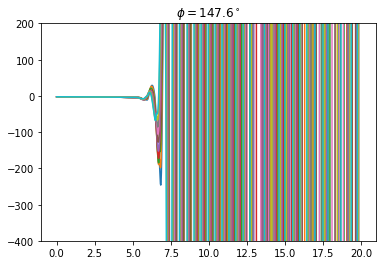

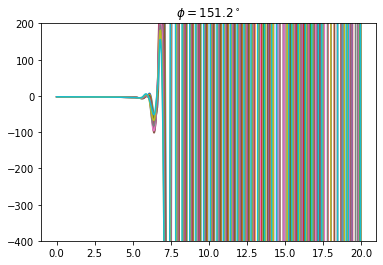

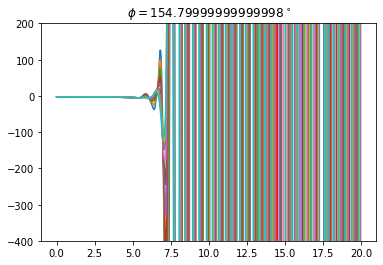

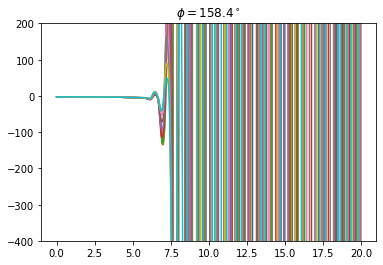

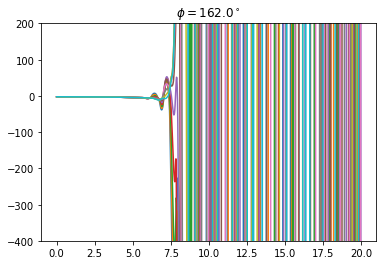

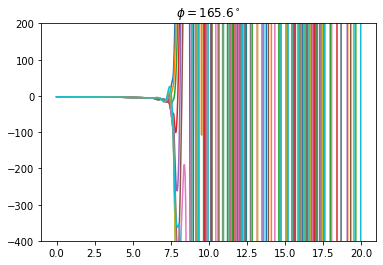

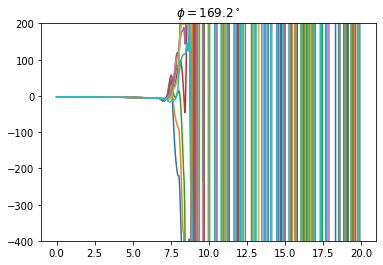

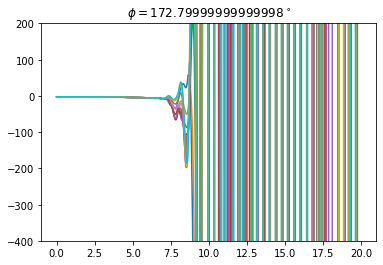

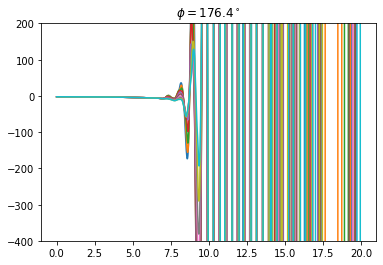

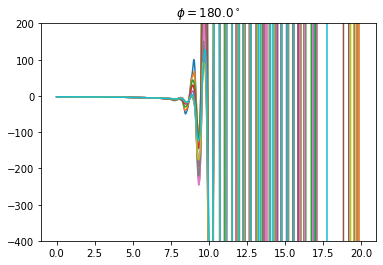

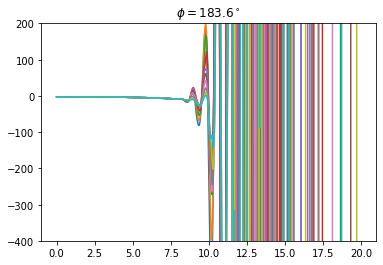

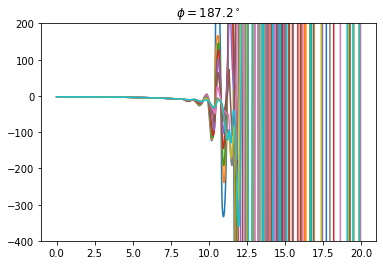

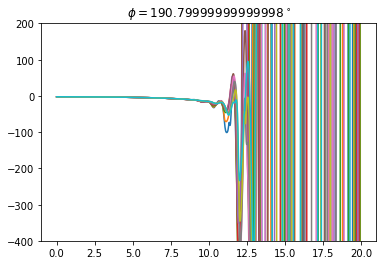

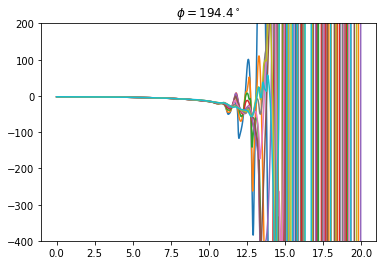

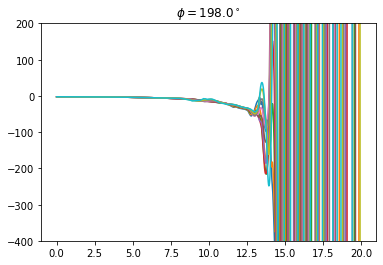

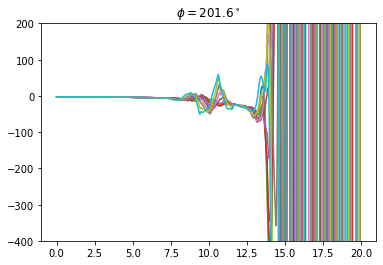

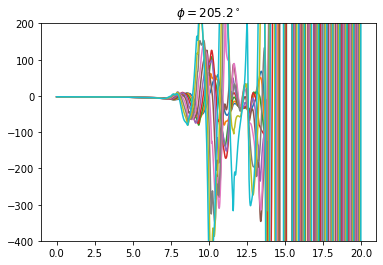

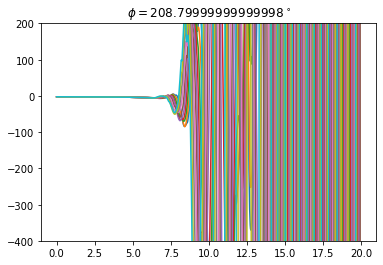

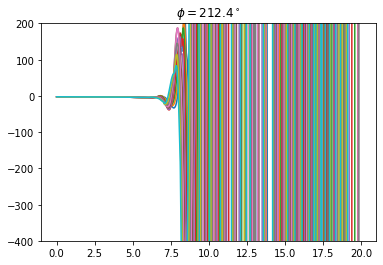

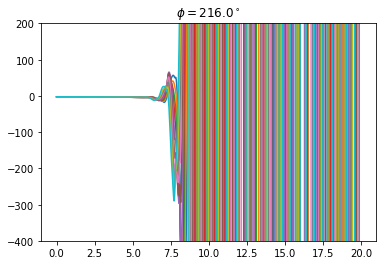

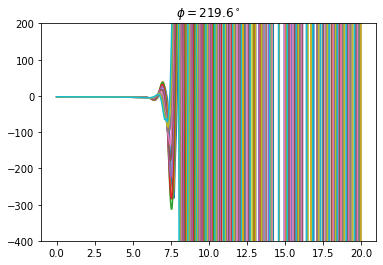

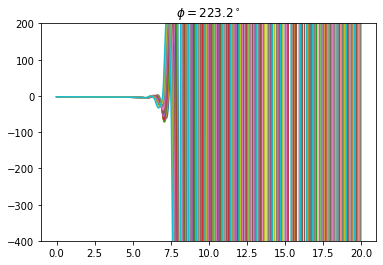

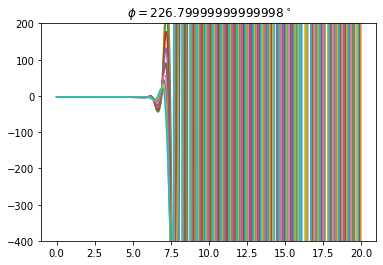

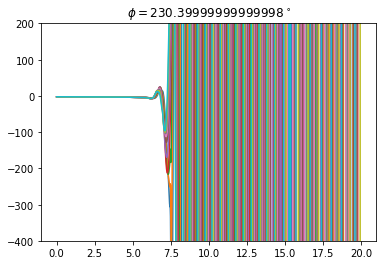

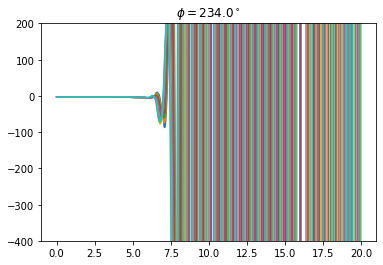

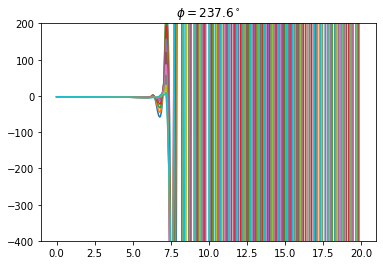

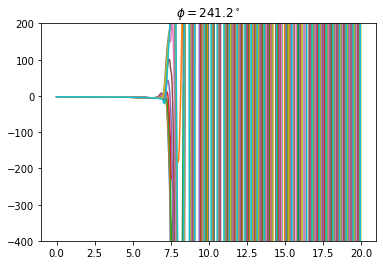

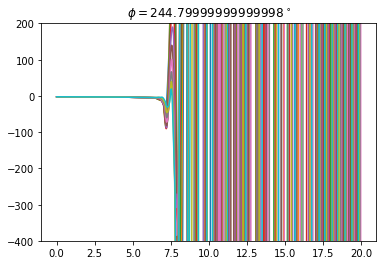

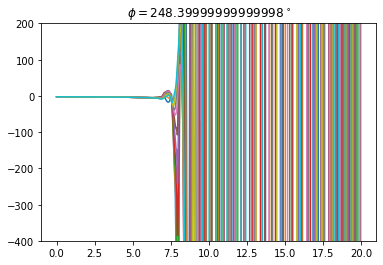

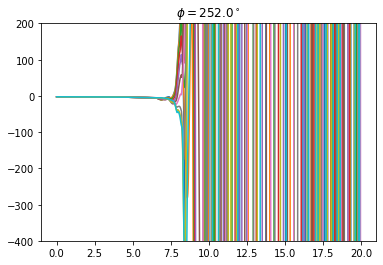

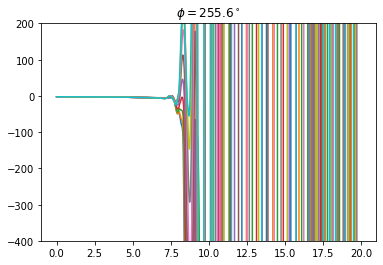

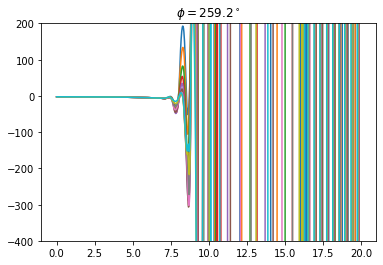

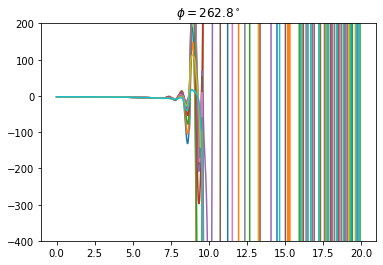

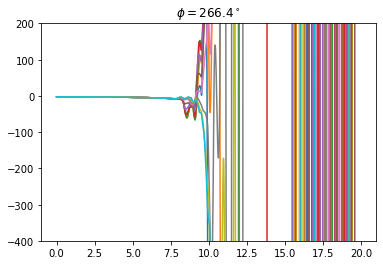

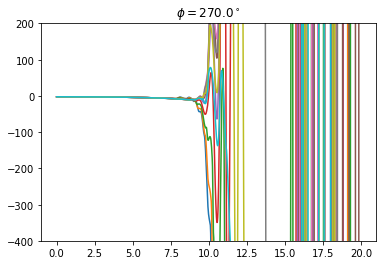

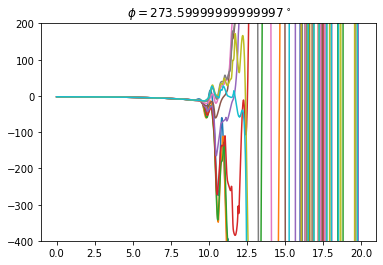

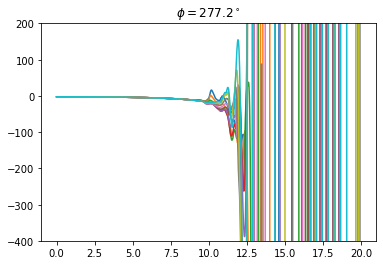

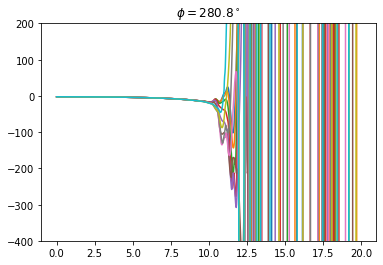

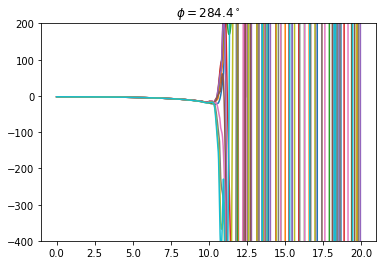

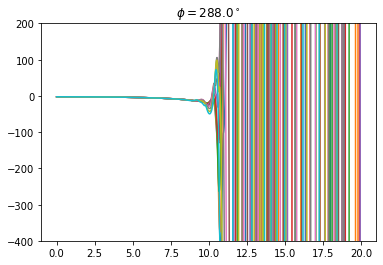

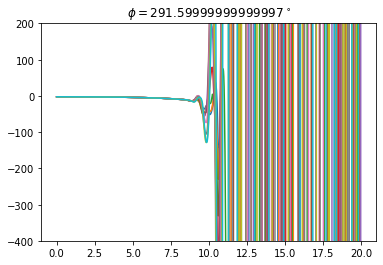

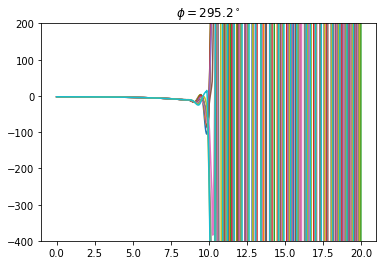

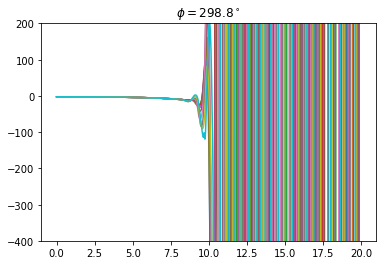

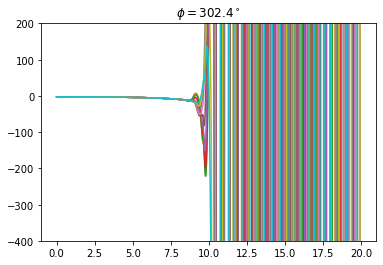

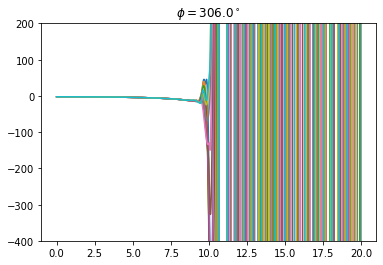

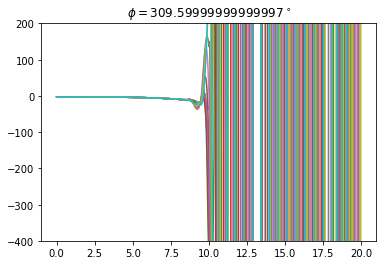

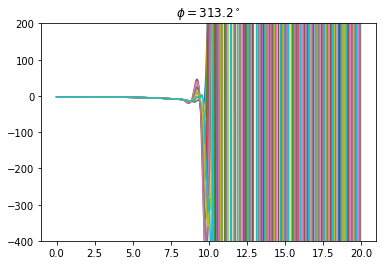

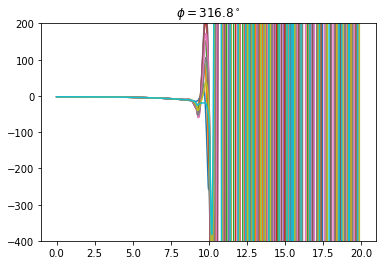

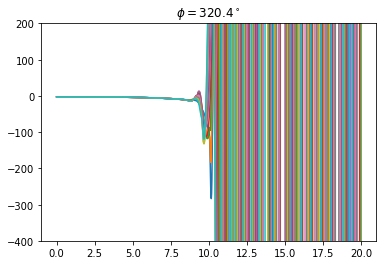

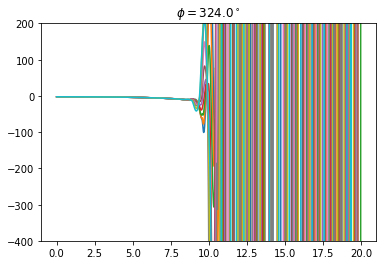

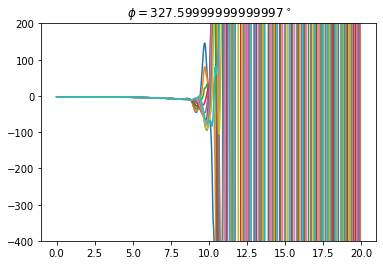

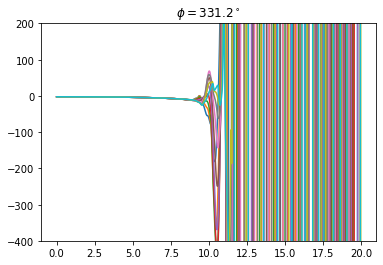

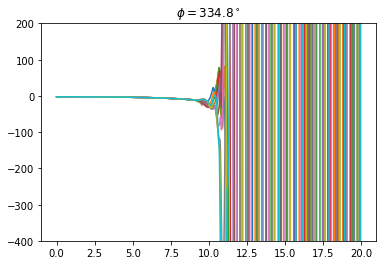

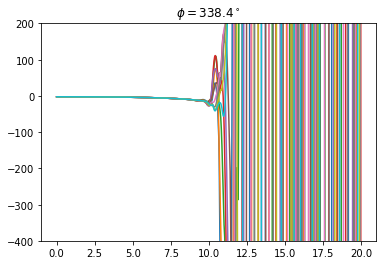

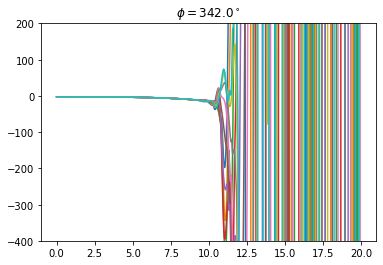

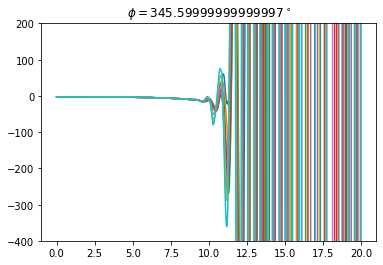

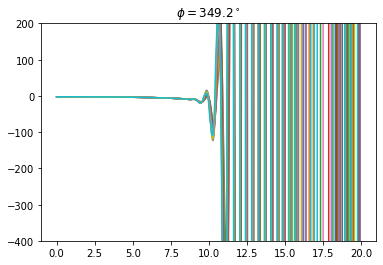

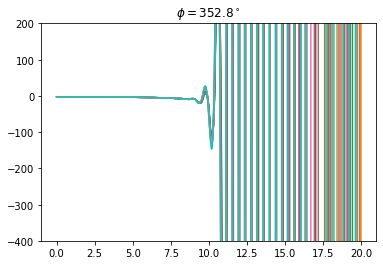

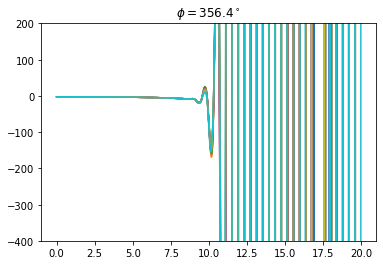

In [12]:
fig,ax = plt.subplots()
for i,phi in enumerate(grid_phi[0,:]):
    if i%10 == 0:
        if not i == 0:
            plt.show(fig)
        plt.close(fig)
        fig,ax = plt.subplots()
        ax.set_title(r"$\phi={}^\circ$".format(phi))
    ax.plot(grid_r[:,i],polar_cubic[:,i])
    ax.set_ylim((-400,200))

Cubic interpolation fails miserably, other two methods seem to work. Some dynamic structure appears near some of the walls at angles where the cut passes near a wall before reaching the cylinder wall (see $90^\circ$).

# 1 Integrated over full radial space

In [13]:
phis = grid_phi[0,:]*np.pi/180
r_1 = grid_r[:,0]
U_1 = np.zeros_like(r_1)

In [14]:
for i,_r in enumerate(r_1):
    U_1[i] = simps(polar_linear[i,:],phis)/2/np.pi

Here we fit the integrated data to our $U_\mathrm{cyl}$

In [15]:
xdata = r_1
ydata = U_1
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
max_U = 0.0

# Here we don't have to worry about the pore roughness so we will set the radial cutoff greater the maximum r
r_cut_fit_1 = np.max(xdata) + 1
fitind = (ydata <= max_U) * (xdata <= r_cut_fit_1)
r_cutoff_1 = np.max(xdata[fitind])

popt_1, pcov_1 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr_1 = np.sqrt(np.diag(pcov_1))

print(perr_1)

print(popt_1)

[0.01020698 0.00657846 0.00809506]
[ 3.38502789  0.58124291 15.28745846]


In [16]:
σ_1,nε_1,R_1 = popt_1
σ_error_1,nε_error_1,R_error_1 = perr_1


(-65, 0)

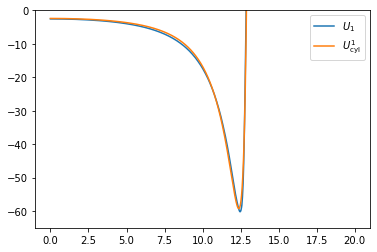

In [17]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_1,nε_1,R_1),label=r"$U_\mathrm{cyl}^1$")
ax.legend()
ax.set_ylim(-65,0)

In [18]:
result = minimize(U_min,12.5,args=(σ_1,nε_1,R_1))
U_min_1 = result.fun
r_min_1 = result.x[0]

In [19]:
r_min_1

12.37867398768928

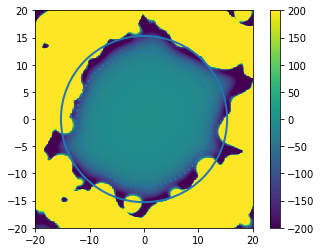

In [20]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_1,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_1,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
cbar = fig.colorbar(im)

# 2 Views down an angle

Here we explore the effects of looking down an angle while standing at the center of the pore. We determine the parameters to $U_\mathrm{cyl}$ for each view and then average throwing out outliers.

In [21]:
phis_2 = grid_phi[0,:]*np.pi/180
phis_2_degrees = grid_phi[0,:]
r_2 = grid_r[:,0]

#We look down each view so we keep the full potential
U_2 = polar_linear

#Each view will have a different sigma, epsilon, R, and cutoff values
σ_2 = np.zeros_like(phis_2)
nε_2 = np.zeros_like(phis_2)
R_2 = np.zeros_like(phis_2)
σ_error_2 = np.zeros_like(phis_2)
nε_error_2 = np.zeros_like(phis_2)
R_error_2 = np.zeros_like(phis_2)
r_cutoff_2 = np.zeros_like(phis_2)

#NOTE: r_cutoff_2 will probably be messed up for some of the weird angles like 90 degrees

In [22]:
# Here we begin the fitting procedure

for i,phi in enumerate(phis_2):
    xdata = r_2
    ydata = U_2[:,i]
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    # I have decided not to worry about pore roughness for now, we might want to set some radial cutoff beside the max potential to take it into account
    r_cut_fit_2 = np.max(xdata) + 1
    
    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (ydata <= max_U) * (xdata <= r_cut_fit_2)
    r_cutoff_2[i] = np.max(xdata[fitind])

    popt_2, pcov_2 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_2 = np.sqrt(np.diag(pcov_2))

    σ_2[i],nε_2[i],R_2[i] = popt_2
    σ_error_2[i],nε_error_2[i],R_error_2[i] = perr_2


1000 values in original $\sigma$ dataset
951 values in truncated $\sigma$ dataset
880 values in truncated $\sigma$ dataset
828 values in truncated $\sigma$ dataset
794 values in truncated $\sigma$ dataset
759 values in truncated $\sigma$ dataset
732 values in truncated $\sigma$ dataset
709 values in truncated $\sigma$ dataset
691 values in truncated $\sigma$ dataset
681 values in truncated $\sigma$ dataset
676 values in truncated $\sigma$ dataset
673 values in truncated $\sigma$ dataset
670 values in truncated $\sigma$ dataset
669 values in truncated $\sigma$ dataset
667 values in truncated $\sigma$ dataset
666 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
999 values in truncated $n\epsilon$ dataset
964 values in truncated $n\epsilon$ dataset
936 values in truncated $n\epsilon$ dataset
911 values in truncated $n\epsilon$ dataset
887 values in truncated $n\epsilon$ dataset
865 values in truncated $n\epsilon$ dataset
849 values in truncated $n\epsilon$ 

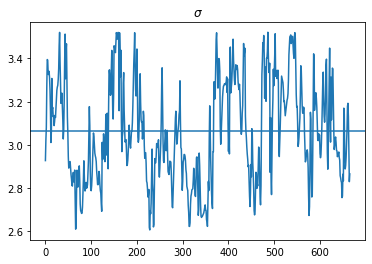

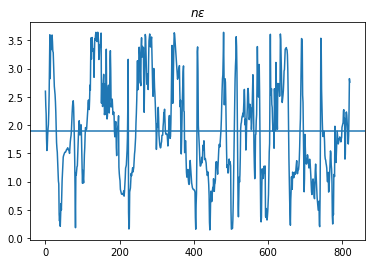

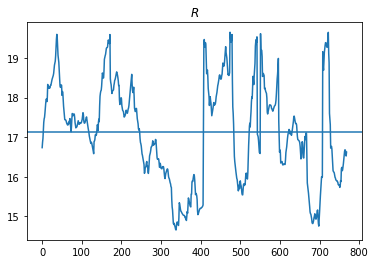

In [23]:
σ_mean_full_2 = np.mean(σ_2)
nε_mean_full_2 = np.mean(nε_2)
R_mean_full_2 = np.mean(R_2)

σ_mean_2, σ_err_2, σ_not_outlier_2 = get_average_fit_parameter2(σ_2,r"$\sigma$")
nε_mean_2, nε_err_2, nε_not_outlier_2 = get_average_fit_parameter2(nε_2,r"$n\epsilon$")
R_mean_2, R_err_2, R_not_outlier_2 = get_average_fit_parameter2(R_2,r"$R$")

σ_outlier_2 = np.array([not i for i in σ_not_outlier_2])
nε_outlier_2 = np.array([not i for i in nε_not_outlier_2])
R_outlier_2 = np.array([not i for i in R_not_outlier_2])

σ_in_2 = σ_2[σ_not_outlier_2]
nε_in_2 = σ_2[nε_not_outlier_2]
R_in_2 = σ_2[R_not_outlier_2]

σ_out_2 = σ_2[σ_outlier_2]
nε_out_2 = σ_2[nε_outlier_2]
R_out_2 = σ_2[R_outlier_2]

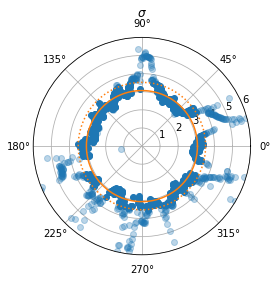

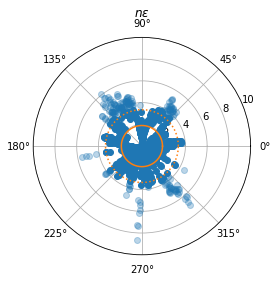

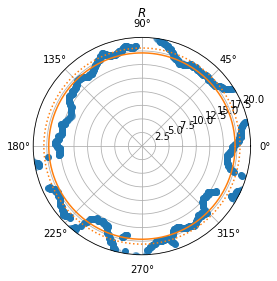

In [24]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_2[σ_not_outlier_2],σ_2[σ_not_outlier_2],linestyle="None",marker="o",color="C0")
ax.plot(phis_2[σ_outlier_2],σ_2[σ_outlier_2],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_2,np.ones_like(phis_2)*σ_mean_2,color="C1")
ax.plot(phis_2,np.ones_like(phis_2)*σ_mean_full_2,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_2[nε_not_outlier_2],nε_2[nε_not_outlier_2],linestyle="None",marker="o",color="C0")
ax.plot(phis_2[nε_outlier_2],nε_2[nε_outlier_2],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_2,np.ones_like(phis_2)*nε_mean_2,color="C1")
ax.plot(phis_2,np.ones_like(phis_2)*nε_mean_full_2,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_2[R_not_outlier_2],R_2[R_not_outlier_2],linestyle="None",marker="o",color="C0")
ax.plot(phis_2[R_outlier_2],R_2[R_outlier_2],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_2,np.ones_like(phis_2)*R_mean_2,color="C1")
ax.plot(phis_2,np.ones_like(phis_2)*R_mean_full_2,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

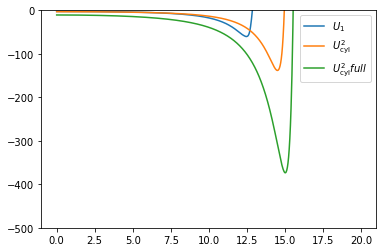

In [25]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_2,nε_mean_2,R_mean_2),label=r"$U_\mathrm{cyl}^2$")
ax.plot(r_1,U_min(r_1,σ_mean_full_2,nε_mean_full_2,R_mean_full_2),label=r"$U_\mathrm{cyl}^2 full$")
ax.legend()
ax.set_ylim(-500,0)

In [26]:
result = minimize(U_min,15.0,args=(σ_mean_2,nε_mean_2,R_mean_2))
U_min_2 = result.fun
r_min_2 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_2,nε_mean_full_2,R_mean_full_2))
U_min_full_2 = result.fun
r_min_full_2 = result.x[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power


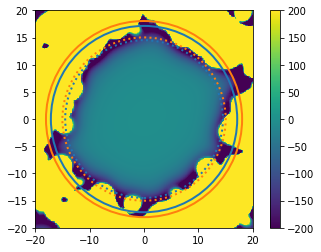

In [27]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_2,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_2,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_2,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_2,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

# 3 Fit to full set

Here we find parameters to $U_\mathrm{cyl}$ over the full interpolated grid. Here we will use the same $r$ and $\phi$ grid that we used before.

In [28]:
r_3 = grid_r

#We keep the full potential
U_3 = polar_linear

In [29]:
# Here we begin the fitting procedure

xdata = r_3.flatten()
ydata = U_3.flatten()
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
max_U = 0.0

# I have decided not to worry about pore roughness for now, we might want to set some radial cutoff beside the max potential to take it into account
# This r_cut_fit_3 will definitly impact the quality of the final fit
r_cut_fit_3 = np.max(xdata) + 1

# FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
fitind = (ydata <= max_U) * (xdata <= r_cut_fit_3)

# FIXME this value definitly makes no sense right now
r_cutoff_3 = np.max(xdata[fitind])


popt_3, pcov_3 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,r_cutoff_3+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr_3 = np.sqrt(np.diag(pcov_3))

σ_3,nε_3,R_3 = popt_3
σ_error_3,nε_error_3,R_error_3 = perr_3


In [30]:
print(perr_3)
print(popt_3)

[0.00633713 0.00367571 0.00551251]
[ 5.78201637  0.76370436 24.21272658]


(-500, 0)

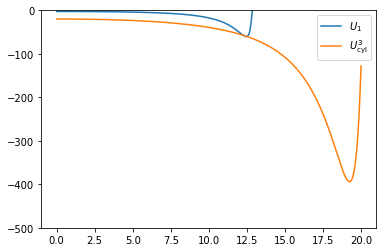

In [31]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_3,nε_3,R_3),label=r"$U_\mathrm{cyl}^3$")
ax.legend()
ax.set_ylim(-500,0)

In [32]:
result = minimize(U_min,18.0,args=(σ_3,nε_3,R_3))
U_min_3 = result.fun
r_min_3 = result.x[0]

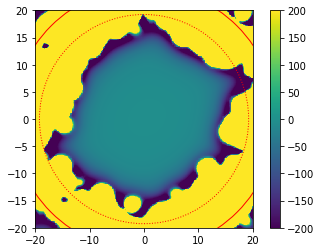

In [33]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_3,facecolor='None',edgecolor='r')
circ2 = Circle((0,0),r_min_3,facecolor='None',edgecolor='r',linestyle = ":")
ax.add_patch(circ)
ax.add_patch(circ2)
cbar = fig.colorbar(im)

The $U_\mathrm{cyl}$ potential makes no sense. This is because we cutoff the potetiatl at $U = 0.0$ this creates data rich regions in the deep pockest near the corners of the quasi-hexagonal pore. Changing the potential to larger cutoffs breaks the fitting algorithm due to numerical instabilities. Lets cutoff the potential radial at the closest wall and see how fitting to all the data does.

In [34]:
r_close_3 = grid_r

#We keep the full potential
U_close_3 = polar_linear

In [35]:
# Here we begin the fitting procedure

xdata = r_close_3.flatten()
ydata = U_close_3.flatten()
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
max_U = 0.0

# FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
fitindU = (ydata >= max_U)
skip_begining_zeros_idx = xdata > 5.0
r_cut_fit_close_3 = xdata[fitindU * skip_begining_zeros_idx][0]

fitind = (xdata <= r_cut_fit_close_3)
# FIXME this value definitly makes no sense right now
r_cutoff_close_3 = np.max(xdata[fitind])


popt_close_3, pcov_close_3 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,r_cutoff_3+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr_close_3 = np.sqrt(np.diag(pcov_close_3))

σ_close_3,nε_close_3,R_close_3 = popt_close_3
σ_error_close_3,nε_error_close_3,R_error_close_3 = perr_close_3


In [36]:
print(perr_close_3)
print(popt_close_3)

[0.00516026 0.00496795 0.00643362]
[ 3.55621745  0.51830279 15.59413799]


(-500, 0)

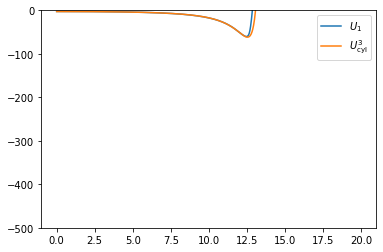

In [37]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_close_3,nε_close_3,R_close_3),label=r"$U_\mathrm{cyl}^3$")
ax.legend()
ax.set_ylim(-500,0)

In [38]:
result = minimize(U_min,12.0,args=(σ_close_3,nε_close_3,R_close_3))
U_min_close_3 = result.fun
r_min_close_3 = result.x[0]

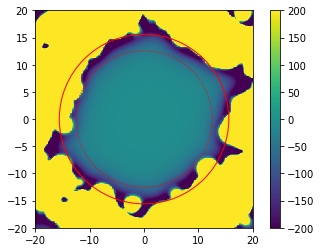

In [39]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_close_3,facecolor='None',edgecolor='r')
circ2 = Circle((0,0),r_min_close_3,facecolor='None',edgecolor='r',linestyle = ":")
ax.add_patch(circ)
ax.add_patch(circ2)
cbar = fig.colorbar(im)

Here only fitting to the potential within the radial cutoff where we cut at the first potential greater that zero gives a more sensible fit, close to the radial average ($U_1$).

# 4 Pizza slicing the potential

This method has room for extreme variablility. It will depend on the width of the pizza slice. The width is probably something that can be optimized, where the limiting cases are fitting to the view (method 2) and fitting to the full potential (method 3). Starting with $10^\circ$ pizza slices.

In [40]:
phis_ten_4 = grid_phi[0,:]*np.pi/180
phis_ten_4_degrees = grid_phi[0,:]
r_ten_4 = grid_r

#For each pizza slice we'll be chopping up the full potential
U_ten_4 = polar_linear

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_ten_4 = np.zeros_like(phis_ten_4)
nε_ten_4 = np.zeros_like(phis_ten_4)
R_ten_4 = np.zeros_like(phis_ten_4)
σ_error_ten_4 = np.zeros_like(phis_ten_4)
nε_error_ten_4 = np.zeros_like(phis_ten_4)
R_error_ten_4 = np.zeros_like(phis_ten_4)
r_cutoff_ten_4 = np.zeros_like(phis_ten_4)

#NOTE: r_cutoff_ten_4 will be the closest U_4 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [41]:
# Here we begin the fitting procedure
dϕ = 10.0

for i,phi in enumerate(phis_ten_4):
    ϕ_start = phis_ten_4_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_ten_4_degrees >= ϕ_start) + (phis_ten_4_degrees < ϕ_end % 360.0)
    else:
        ϕ_idx = (phis_ten_4_degrees >= ϕ_start) * (phis_ten_4_degrees < ϕ_end)
    
    xdata = r_ten_4[:,ϕ_idx].flatten()
    ydata = U_ten_4[:,ϕ_idx].flatten()
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_ten_4 = np.max(xdata) + 1
    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    # Below cuts at first wall
    fitindU = (ydata >= max_U)
    skip_begining_zeros_idx = xdata > 5.0
    if np.any(fitindU * skip_begining_zeros_idx):
        r_cut_fit_ten_4 = xdata[fitindU * skip_begining_zeros_idx][0]
    else:
        r_cut_fit_ten_4 = np.max(xdata) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (ydata <= max_U) * (xdata <= r_cut_fit_ten_4)
    r_cutoff_ten_4[i] = np.max(xdata[fitind])

    popt_ten_4, pcov_ten_4 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_ten_4 = np.sqrt(np.diag(pcov_ten_4))

    σ_ten_4[i],nε_ten_4[i],R_ten_4[i] = popt_ten_4
    σ_error_ten_4[i],nε_error_ten_4[i],R_error_ten_4[i] = perr_ten_4


1000 values in original $\sigma$ dataset
947 values in truncated $\sigma$ dataset
914 values in truncated $\sigma$ dataset
879 values in truncated $\sigma$ dataset
849 values in truncated $\sigma$ dataset
825 values in truncated $\sigma$ dataset
812 values in truncated $\sigma$ dataset
804 values in truncated $\sigma$ dataset
791 values in truncated $\sigma$ dataset
777 values in truncated $\sigma$ dataset
767 values in truncated $\sigma$ dataset
760 values in truncated $\sigma$ dataset
749 values in truncated $\sigma$ dataset
739 values in truncated $\sigma$ dataset
731 values in truncated $\sigma$ dataset
721 values in truncated $\sigma$ dataset
703 values in truncated $\sigma$ dataset
682 values in truncated $\sigma$ dataset
662 values in truncated $\sigma$ dataset
646 values in truncated $\sigma$ dataset
630 values in truncated $\sigma$ dataset
616 values in truncated $\sigma$ dataset
607 values in truncated $\sigma$ dataset
598 values in truncated $\sigma$ dataset
587 values in tr

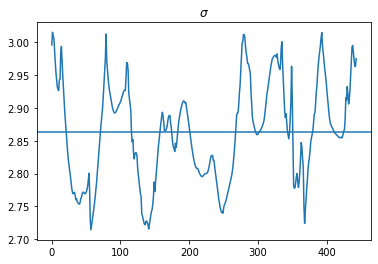

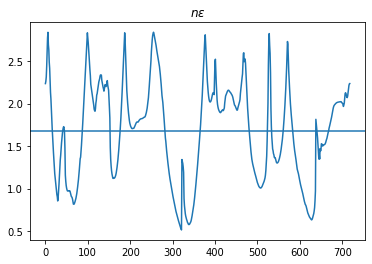

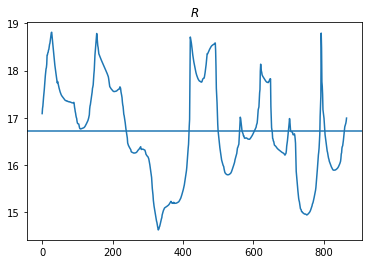

In [42]:
σ_mean_full_ten_4 = np.mean(σ_ten_4)
nε_mean_full_ten_4 = np.mean(nε_ten_4)
R_mean_full_ten_4 = np.mean(R_ten_4)

σ_mean_ten_4, σ_err_ten_4, σ_not_outlier_ten_4 = get_average_fit_parameter2(σ_ten_4,r"$\sigma$")
nε_mean_ten_4, nε_err_ten_4, nε_not_outlier_ten_4 = get_average_fit_parameter2(nε_ten_4,r"$n\epsilon$")
R_mean_ten_4, R_err_ten_4, R_not_outlier_ten_4 = get_average_fit_parameter2(R_ten_4,r"$R$")

σ_outlier_ten_4 = np.array([not i for i in σ_not_outlier_ten_4])
nε_outlier_ten_4 = np.array([not i for i in nε_not_outlier_ten_4])
R_outlier_ten_4 = np.array([not i for i in R_not_outlier_ten_4])

σ_in_ten_4 = σ_ten_4[σ_not_outlier_ten_4]
nε_in_ten_4 = σ_ten_4[nε_not_outlier_ten_4]
R_in_ten_4 = σ_ten_4[R_not_outlier_ten_4]

σ_out_ten_4 = σ_ten_4[σ_outlier_ten_4]
nε_out_ten_4 = σ_ten_4[nε_outlier_ten_4]
R_out_ten_4 = σ_ten_4[R_outlier_ten_4]

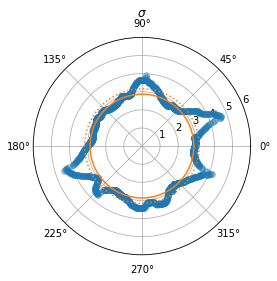

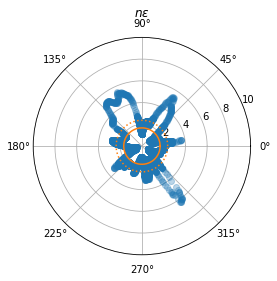

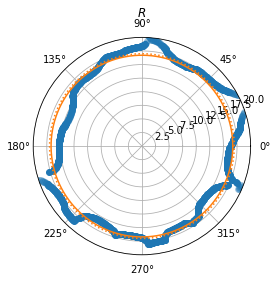

In [43]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 5.0*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_ten_4[σ_not_outlier_ten_4]+ϕ_shift,σ_ten_4[σ_not_outlier_ten_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_ten_4[σ_outlier_ten_4]+ϕ_shift,σ_ten_4[σ_outlier_ten_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_ten_4,np.ones_like(phis_ten_4)*σ_mean_ten_4,color="C1")
ax.plot(phis_ten_4,np.ones_like(phis_ten_4)*σ_mean_full_ten_4,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_ten_4[nε_not_outlier_ten_4]+ϕ_shift,nε_ten_4[nε_not_outlier_ten_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_ten_4[nε_outlier_ten_4]+ϕ_shift,nε_ten_4[nε_outlier_ten_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_ten_4,np.ones_like(phis_ten_4)*nε_mean_ten_4,color="C1")
ax.plot(phis_ten_4,np.ones_like(phis_ten_4)*nε_mean_full_ten_4,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_ten_4[R_not_outlier_ten_4]+ϕ_shift,R_ten_4[R_not_outlier_ten_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_ten_4[R_outlier_ten_4]+ϕ_shift,R_ten_4[R_outlier_ten_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_ten_4,np.ones_like(phis_ten_4)*R_mean_ten_4,color="C1")
ax.plot(phis_ten_4,np.ones_like(phis_ten_4)*R_mean_full_ten_4,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

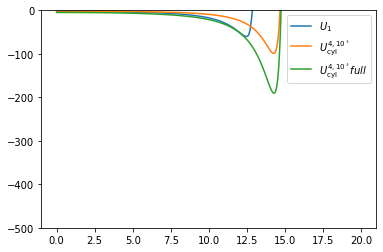

In [44]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_ten_4,nε_mean_ten_4,R_mean_ten_4),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_ten_4,nε_mean_full_ten_4,R_mean_full_ten_4),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [45]:
result = minimize(U_min,15.0,args=(σ_mean_ten_4,nε_mean_ten_4,R_mean_ten_4))
U_min_ten_4 = result.fun
r_min_ten_4 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_ten_4,nε_mean_full_ten_4,R_mean_full_ten_4))
U_min_full_ten_4 = result.fun
r_min_full_ten_4 = result.x[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power


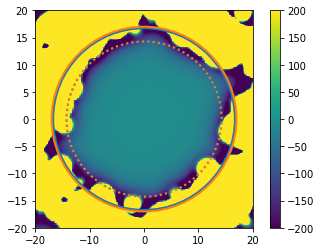

In [46]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_ten_4,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_ten_4,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_ten_4,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_ten_4,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now for $5^\circ$ slices.

In [47]:
phis_five_4 = grid_phi[0,:]*np.pi/180
phis_five_4_degrees = grid_phi[0,:]
r_five_4 = grid_r

#For each pizza slice we'll be chopping up the full potential
U_five_4 = polar_linear

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_five_4 = np.zeros_like(phis_five_4)
nε_five_4 = np.zeros_like(phis_five_4)
R_five_4 = np.zeros_like(phis_five_4)
σ_error_five_4 = np.zeros_like(phis_five_4)
nε_error_five_4 = np.zeros_like(phis_five_4)
R_error_five_4 = np.zeros_like(phis_five_4)
r_cutoff_five_4 = np.zeros_like(phis_five_4)

#NOTE: r_cutoff_five_4 will be the closest U_4 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [48]:
# Here we begin the fitting procedure
dϕ = 5.0

for i,phi in enumerate(phis_five_4):
    ϕ_start = phis_five_4_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_five_4_degrees >= ϕ_start) + (phis_five_4_degrees < ϕ_end % 360.0)
    else:
        ϕ_idx = (phis_five_4_degrees >= ϕ_start) * (phis_five_4_degrees < ϕ_end)
    
    xdata = r_five_4[:,ϕ_idx].flatten()
    ydata = U_five_4[:,ϕ_idx].flatten()
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_five_4 = np.max(xdata) + 1
    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    # Below cuts at first wall
    fitindU = (ydata >= max_U)
    skip_begining_zeros_idx = xdata > 5.0
    if np.any(fitindU * skip_begining_zeros_idx):
        r_cut_fit_five_4 = xdata[fitindU * skip_begining_zeros_idx][0]
    else:
        r_cut_fit_five_4 = np.max(xdata) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (ydata <= max_U) * (xdata <= r_cut_fit_five_4)
    r_cutoff_five_4[i] = np.max(xdata[fitind])

    popt_five_4, pcov_five_4 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_five_4 = np.sqrt(np.diag(pcov_five_4))

    σ_five_4[i],nε_five_4[i],R_five_4[i] = popt_five_4
    σ_error_five_4[i],nε_error_five_4[i],R_error_five_4[i] = perr_five_4


1000 values in original $\sigma$ dataset
926 values in truncated $\sigma$ dataset
882 values in truncated $\sigma$ dataset
841 values in truncated $\sigma$ dataset
818 values in truncated $\sigma$ dataset
801 values in truncated $\sigma$ dataset
786 values in truncated $\sigma$ dataset
777 values in truncated $\sigma$ dataset
768 values in truncated $\sigma$ dataset
762 values in truncated $\sigma$ dataset
753 values in truncated $\sigma$ dataset
742 values in truncated $\sigma$ dataset
724 values in truncated $\sigma$ dataset
702 values in truncated $\sigma$ dataset
685 values in truncated $\sigma$ dataset
666 values in truncated $\sigma$ dataset
652 values in truncated $\sigma$ dataset
635 values in truncated $\sigma$ dataset
622 values in truncated $\sigma$ dataset
612 values in truncated $\sigma$ dataset
604 values in truncated $\sigma$ dataset
597 values in truncated $\sigma$ dataset
590 values in truncated $\sigma$ dataset
579 values in truncated $\sigma$ dataset
563 values in tr

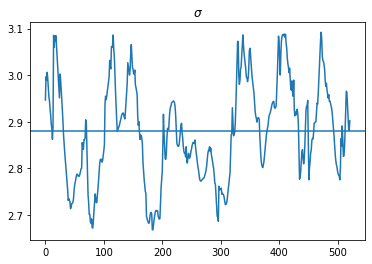

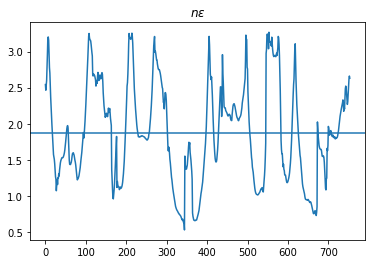

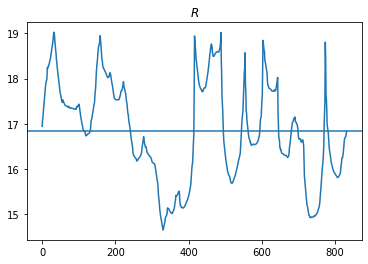

In [49]:
σ_mean_full_five_4 = np.mean(σ_five_4)
nε_mean_full_five_4 = np.mean(nε_five_4)
R_mean_full_five_4 = np.mean(R_five_4)

σ_mean_five_4, σ_err_five_4, σ_not_outlier_five_4 = get_average_fit_parameter2(σ_five_4,r"$\sigma$")
nε_mean_five_4, nε_err_five_4, nε_not_outlier_five_4 = get_average_fit_parameter2(nε_five_4,r"$n\epsilon$")
R_mean_five_4, R_err_five_4, R_not_outlier_five_4 = get_average_fit_parameter2(R_five_4,r"$R$")

σ_outlier_five_4 = np.array([not i for i in σ_not_outlier_five_4])
nε_outlier_five_4 = np.array([not i for i in nε_not_outlier_five_4])
R_outlier_five_4 = np.array([not i for i in R_not_outlier_five_4])

σ_in_five_4 = σ_five_4[σ_not_outlier_five_4]
nε_in_five_4 = σ_five_4[nε_not_outlier_five_4]
R_in_five_4 = σ_five_4[R_not_outlier_five_4]

σ_out_five_4 = σ_five_4[σ_outlier_five_4]
nε_out_five_4 = σ_five_4[nε_outlier_five_4]
R_out_five_4 = σ_five_4[R_outlier_five_4]

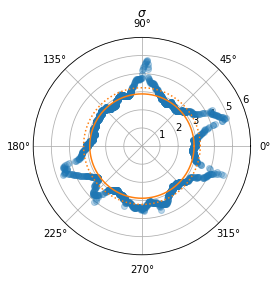

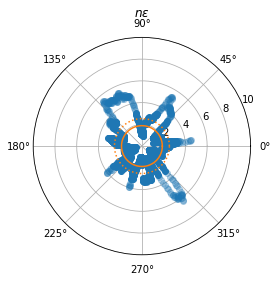

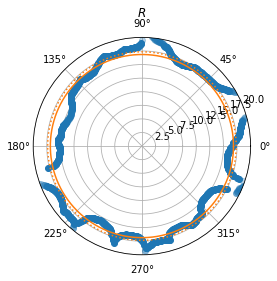

In [50]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 2.5*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_five_4[σ_not_outlier_five_4]+ϕ_shift,σ_five_4[σ_not_outlier_five_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_five_4[σ_outlier_five_4]+ϕ_shift,σ_five_4[σ_outlier_five_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_five_4,np.ones_like(phis_five_4)*σ_mean_five_4,color="C1")
ax.plot(phis_five_4,np.ones_like(phis_five_4)*σ_mean_full_five_4,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_five_4[nε_not_outlier_five_4]+ϕ_shift,nε_five_4[nε_not_outlier_five_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_five_4[nε_outlier_five_4]+ϕ_shift,nε_five_4[nε_outlier_five_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_five_4,np.ones_like(phis_five_4)*nε_mean_five_4,color="C1")
ax.plot(phis_five_4,np.ones_like(phis_five_4)*nε_mean_full_five_4,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_five_4[R_not_outlier_five_4]+ϕ_shift,R_five_4[R_not_outlier_five_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_five_4[R_outlier_five_4]+ϕ_shift,R_five_4[R_outlier_five_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_five_4,np.ones_like(phis_five_4)*R_mean_five_4,color="C1")
ax.plot(phis_five_4,np.ones_like(phis_five_4)*R_mean_full_five_4,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

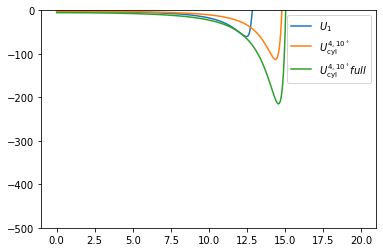

In [51]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_five_4,nε_mean_five_4,R_mean_five_4),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_five_4,nε_mean_full_five_4,R_mean_full_five_4),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [52]:
result = minimize(U_min,15.0,args=(σ_mean_five_4,nε_mean_five_4,R_mean_five_4))
U_min_five_4 = result.fun
r_min_five_4 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_five_4,nε_mean_full_five_4,R_mean_full_five_4))
U_min_full_five_4 = result.fun
r_min_full_five_4 = result.x[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power


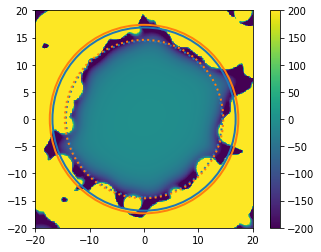

In [53]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_five_4,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_five_4,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_five_4,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_five_4,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $1^\circ$

In [54]:
phis_one_4 = grid_phi[0,:]*np.pi/180
phis_one_4_degrees = grid_phi[0,:]
r_one_4 = grid_r

#For each pizza slice we'll be chopping up the full potential
U_one_4 = polar_linear

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_one_4 = np.zeros_like(phis_one_4)
nε_one_4 = np.zeros_like(phis_one_4)
R_one_4 = np.zeros_like(phis_one_4)
σ_error_one_4 = np.zeros_like(phis_one_4)
nε_error_one_4 = np.zeros_like(phis_one_4)
R_error_one_4 = np.zeros_like(phis_one_4)
r_cutoff_one_4 = np.zeros_like(phis_one_4)

#NOTE: r_cutoff_one_4 will be the closest U_4 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [55]:
# Here we begin the fitting procedure
dϕ = 1.0

for i,phi in enumerate(phis_one_4):
    ϕ_start = phis_one_4_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_one_4_degrees >= ϕ_start) + (phis_one_4_degrees < ϕ_end % 360.0)
    else:
        ϕ_idx = (phis_one_4_degrees >= ϕ_start) * (phis_one_4_degrees < ϕ_end)
    
    xdata = r_one_4[:,ϕ_idx].flatten()
    ydata = U_one_4[:,ϕ_idx].flatten()
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_one_4 = np.max(xdata) + 1
    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    # Below cuts at first wall
    fitindU = (ydata >= max_U)
    skip_begining_zeros_idx = xdata > 5.0
    if np.any(fitindU * skip_begining_zeros_idx):
        r_cut_fit_one_4 = xdata[fitindU * skip_begining_zeros_idx][0]
    else:
        r_cut_fit_one_4 = np.max(xdata) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (ydata <= max_U) * (xdata <= r_cut_fit_one_4)
    r_cutoff_one_4[i] = np.max(xdata[fitind])

    popt_one_4, pcov_one_4 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_one_4 = np.sqrt(np.diag(pcov_one_4))

    σ_one_4[i],nε_one_4[i],R_one_4[i] = popt_one_4
    σ_error_one_4[i],nε_error_one_4[i],R_error_one_4[i] = perr_one_4


1000 values in original $\sigma$ dataset
933 values in truncated $\sigma$ dataset
878 values in truncated $\sigma$ dataset
837 values in truncated $\sigma$ dataset
797 values in truncated $\sigma$ dataset
776 values in truncated $\sigma$ dataset
753 values in truncated $\sigma$ dataset
734 values in truncated $\sigma$ dataset
723 values in truncated $\sigma$ dataset
714 values in truncated $\sigma$ dataset
712 values in truncated $\sigma$ dataset
708 values in truncated $\sigma$ dataset
706 values in truncated $\sigma$ dataset
704 values in truncated $\sigma$ dataset
701 values in truncated $\sigma$ dataset
700 values in truncated $\sigma$ dataset
699 values in truncated $\sigma$ dataset
697 values in truncated $\sigma$ dataset
695 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
962 values in truncated $n\epsilon$ dataset
927 values in truncated $n\epsilon$ dataset
892 values in truncated $n\epsilon$ dataset
864 values in truncated $n\epsilon$ dataset
8

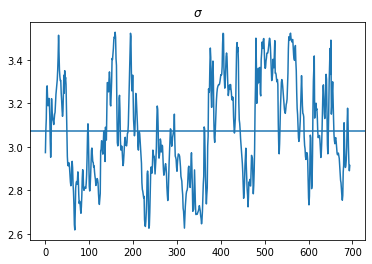

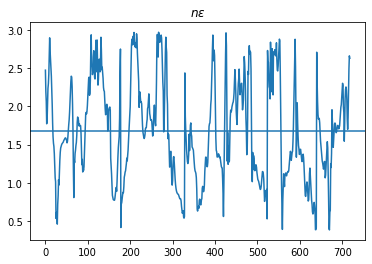

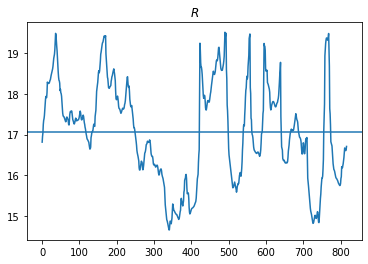

In [56]:
σ_mean_full_one_4 = np.mean(σ_one_4)
nε_mean_full_one_4 = np.mean(nε_one_4)
R_mean_full_one_4 = np.mean(R_one_4)

σ_mean_one_4, σ_err_one_4, σ_not_outlier_one_4 = get_average_fit_parameter2(σ_one_4,r"$\sigma$")
nε_mean_one_4, nε_err_one_4, nε_not_outlier_one_4 = get_average_fit_parameter2(nε_one_4,r"$n\epsilon$")
R_mean_one_4, R_err_one_4, R_not_outlier_one_4 = get_average_fit_parameter2(R_one_4,r"$R$")

σ_outlier_one_4 = np.array([not i for i in σ_not_outlier_one_4])
nε_outlier_one_4 = np.array([not i for i in nε_not_outlier_one_4])
R_outlier_one_4 = np.array([not i for i in R_not_outlier_one_4])

σ_in_one_4 = σ_one_4[σ_not_outlier_one_4]
nε_in_one_4 = σ_one_4[nε_not_outlier_one_4]
R_in_one_4 = σ_one_4[R_not_outlier_one_4]

σ_out_one_4 = σ_one_4[σ_outlier_one_4]
nε_out_one_4 = σ_one_4[nε_outlier_one_4]
R_out_one_4 = σ_one_4[R_outlier_one_4]

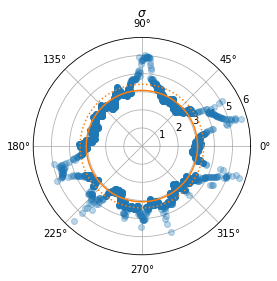

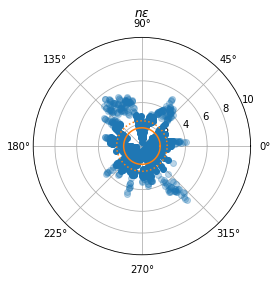

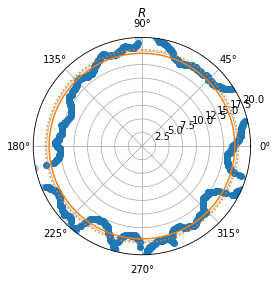

In [57]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 0.5*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_one_4[σ_not_outlier_one_4]+ϕ_shift,σ_one_4[σ_not_outlier_one_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_one_4[σ_outlier_one_4]+ϕ_shift,σ_one_4[σ_outlier_one_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_one_4,np.ones_like(phis_one_4)*σ_mean_one_4,color="C1")
ax.plot(phis_one_4,np.ones_like(phis_one_4)*σ_mean_full_one_4,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_one_4[nε_not_outlier_one_4]+ϕ_shift,nε_one_4[nε_not_outlier_one_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_one_4[nε_outlier_one_4]+ϕ_shift,nε_one_4[nε_outlier_one_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_one_4,np.ones_like(phis_one_4)*nε_mean_one_4,color="C1")
ax.plot(phis_one_4,np.ones_like(phis_one_4)*nε_mean_full_one_4,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_one_4[R_not_outlier_one_4]+ϕ_shift,R_one_4[R_not_outlier_one_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_one_4[R_outlier_one_4]+ϕ_shift,R_one_4[R_outlier_one_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_one_4,np.ones_like(phis_one_4)*R_mean_one_4,color="C1")
ax.plot(phis_one_4,np.ones_like(phis_one_4)*R_mean_full_one_4,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

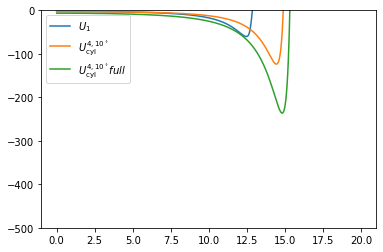

In [58]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_one_4,nε_mean_one_4,R_mean_one_4),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_one_4,nε_mean_full_one_4,R_mean_full_one_4),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [59]:
result = minimize(U_min,15.0,args=(σ_mean_one_4,nε_mean_one_4,R_mean_one_4))
U_min_one_4 = result.fun
r_min_one_4 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_one_4,nε_mean_full_one_4,R_mean_full_one_4))
U_min_full_one_4 = result.fun
r_min_full_one_4 = result.x[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power


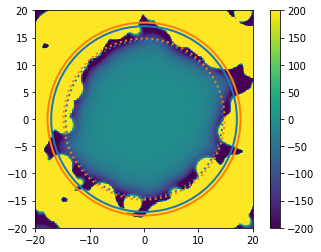

In [60]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_one_4,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_one_4,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_one_4,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_one_4,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $30^\circ$

In [61]:
phis_thirty_4 = grid_phi[0,:]*np.pi/180
phis_thirty_4_degrees = grid_phi[0,:]
r_thirty_4 = grid_r

#For each pizza slice we'll be chopping up the full potential
U_thirty_4 = polar_linear

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_thirty_4 = np.zeros_like(phis_thirty_4)
nε_thirty_4 = np.zeros_like(phis_thirty_4)
R_thirty_4 = np.zeros_like(phis_thirty_4)
σ_error_thirty_4 = np.zeros_like(phis_thirty_4)
nε_error_thirty_4 = np.zeros_like(phis_thirty_4)
R_error_thirty_4 = np.zeros_like(phis_thirty_4)
r_cutoff_thirty_4 = np.zeros_like(phis_thirty_4)

#NOTE: r_cutoff_thirty_4 will be the closest U_4 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [62]:
# Here we begin the fitting procedure
dϕ = 30.0

for i,phi in enumerate(phis_thirty_4):
    ϕ_start = phis_thirty_4_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_thirty_4_degrees >= ϕ_start) + (phis_thirty_4_degrees < ϕ_end % 360.0)
    else:
        ϕ_idx = (phis_thirty_4_degrees >= ϕ_start) * (phis_thirty_4_degrees < ϕ_end)
    
    xdata = r_thirty_4[:,ϕ_idx].flatten()
    ydata = U_thirty_4[:,ϕ_idx].flatten()
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_thirty_4 = np.max(xdata) + 1
    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    # Below cuts at first wall
    fitindU = (ydata >= max_U)
    skip_begining_zeros_idx = xdata > 5.0
    if np.any(fitindU * skip_begining_zeros_idx):
        r_cut_fit_thirty_4 = xdata[fitindU * skip_begining_zeros_idx][0]
    else:
        r_cut_fit_thirty_4 = np.max(xdata) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (ydata <= max_U) * (xdata <= r_cut_fit_thirty_4)
    r_cutoff_thirty_4[i] = np.max(xdata[fitind])

    popt_thirty_4, pcov_thirty_4 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_thirty_4 = np.sqrt(np.diag(pcov_thirty_4))

    σ_thirty_4[i],nε_thirty_4[i],R_thirty_4[i] = popt_thirty_4
    σ_error_thirty_4[i],nε_error_thirty_4[i],R_error_thirty_4[i] = perr_thirty_4


1000 values in original $\sigma$ dataset
962 values in truncated $\sigma$ dataset
940 values in truncated $\sigma$ dataset
933 values in truncated $\sigma$ dataset
932 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
938 values in truncated $n\epsilon$ dataset
855 values in truncated $n\epsilon$ dataset
794 values in truncated $n\epsilon$ dataset
744 values in truncated $n\epsilon$ dataset
711 values in truncated $n\epsilon$ dataset
683 values in truncated $n\epsilon$ dataset
656 values in truncated $n\epsilon$ dataset
640 values in truncated $n\epsilon$ dataset
629 values in truncated $n\epsilon$ dataset
613 values in truncated $n\epsilon$ dataset
594 values in truncated $n\epsilon$ dataset
579 values in truncated $n\epsilon$ dataset
575 values in truncated $n\epsilon$ dataset
571 values in truncated $n\epsilon$ dataset
570 values in truncated $n\epsilon$ dataset
569 values in truncated $n\epsilon$ dataset
1000 values in original $R$ dataset
980 values 

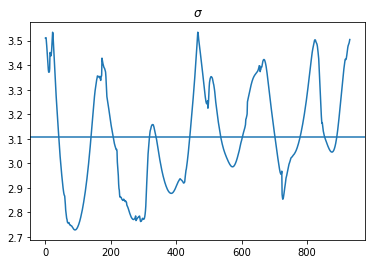

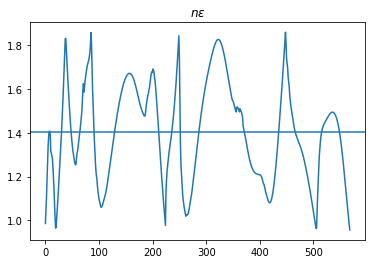

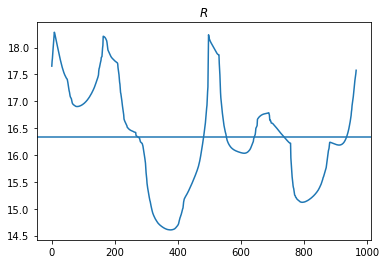

In [63]:
σ_mean_full_thirty_4 = np.mean(σ_thirty_4)
nε_mean_full_thirty_4 = np.mean(nε_thirty_4)
R_mean_full_thirty_4 = np.mean(R_thirty_4)

σ_mean_thirty_4, σ_err_thirty_4, σ_not_outlier_thirty_4 = get_average_fit_parameter2(σ_thirty_4,r"$\sigma$")
nε_mean_thirty_4, nε_err_thirty_4, nε_not_outlier_thirty_4 = get_average_fit_parameter2(nε_thirty_4,r"$n\epsilon$")
R_mean_thirty_4, R_err_thirty_4, R_not_outlier_thirty_4 = get_average_fit_parameter2(R_thirty_4,r"$R$")

σ_outlier_thirty_4 = np.array([not i for i in σ_not_outlier_thirty_4])
nε_outlier_thirty_4 = np.array([not i for i in nε_not_outlier_thirty_4])
R_outlier_thirty_4 = np.array([not i for i in R_not_outlier_thirty_4])

σ_in_thirty_4 = σ_thirty_4[σ_not_outlier_thirty_4]
nε_in_thirty_4 = σ_thirty_4[nε_not_outlier_thirty_4]
R_in_thirty_4 = σ_thirty_4[R_not_outlier_thirty_4]

σ_out_thirty_4 = σ_thirty_4[σ_outlier_thirty_4]
nε_out_thirty_4 = σ_thirty_4[nε_outlier_thirty_4]
R_out_thirty_4 = σ_thirty_4[R_outlier_thirty_4]

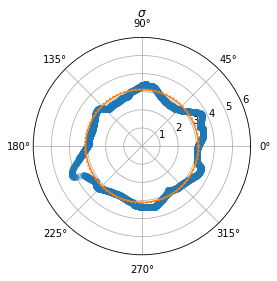

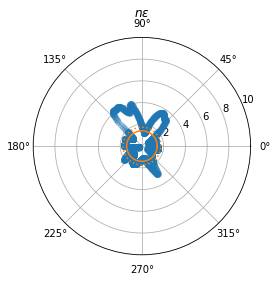

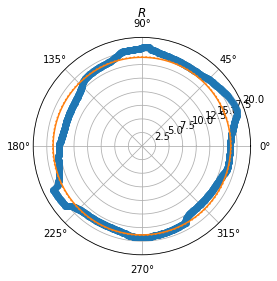

In [64]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 15.0*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_thirty_4[σ_not_outlier_thirty_4]+ϕ_shift,σ_thirty_4[σ_not_outlier_thirty_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_thirty_4[σ_outlier_thirty_4]+ϕ_shift,σ_thirty_4[σ_outlier_thirty_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_thirty_4,np.ones_like(phis_thirty_4)*σ_mean_thirty_4,color="C1")
ax.plot(phis_thirty_4,np.ones_like(phis_thirty_4)*σ_mean_full_thirty_4,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_thirty_4[nε_not_outlier_thirty_4]+ϕ_shift,nε_thirty_4[nε_not_outlier_thirty_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_thirty_4[nε_outlier_thirty_4]+ϕ_shift,nε_thirty_4[nε_outlier_thirty_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_thirty_4,np.ones_like(phis_thirty_4)*nε_mean_thirty_4,color="C1")
ax.plot(phis_thirty_4,np.ones_like(phis_thirty_4)*nε_mean_full_thirty_4,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_thirty_4[R_not_outlier_thirty_4]+ϕ_shift,R_thirty_4[R_not_outlier_thirty_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_thirty_4[R_outlier_thirty_4]+ϕ_shift,R_thirty_4[R_outlier_thirty_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_thirty_4,np.ones_like(phis_thirty_4)*R_mean_thirty_4,color="C1")
ax.plot(phis_thirty_4,np.ones_like(phis_thirty_4)*R_mean_full_thirty_4,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

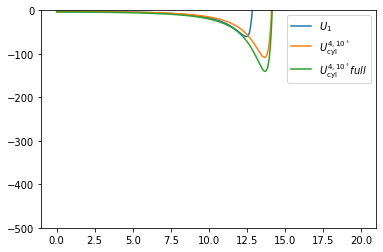

In [65]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_thirty_4,nε_mean_thirty_4,R_mean_thirty_4),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_thirty_4,nε_mean_full_thirty_4,R_mean_full_thirty_4),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [66]:
result = minimize(U_min,15.0,args=(σ_mean_thirty_4,nε_mean_thirty_4,R_mean_thirty_4))
U_min_thirty_4 = result.fun
r_min_thirty_4 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_thirty_4,nε_mean_full_thirty_4,R_mean_full_thirty_4))
U_min_full_thirty_4 = result.fun
r_min_full_thirty_4 = result.x[0]

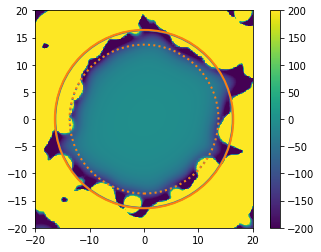

In [67]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_thirty_4,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_thirty_4,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_thirty_4,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_thirty_4,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $60^\circ$

In [68]:
phis_sixty_4 = grid_phi[0,:]*np.pi/180
phis_sixty_4_degrees = grid_phi[0,:]
r_sixty_4 = grid_r

#For each pizza slice we'll be chopping up the full potential
U_sixty_4 = polar_linear

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_sixty_4 = np.zeros_like(phis_sixty_4)
nε_sixty_4 = np.zeros_like(phis_sixty_4)
R_sixty_4 = np.zeros_like(phis_sixty_4)
σ_error_sixty_4 = np.zeros_like(phis_sixty_4)
nε_error_sixty_4 = np.zeros_like(phis_sixty_4)
R_error_sixty_4 = np.zeros_like(phis_sixty_4)
r_cutoff_sixty_4 = np.zeros_like(phis_sixty_4)

#NOTE: r_cutoff_sixty_4 will be the closest U_4 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [69]:
# Here we begin the fitting procedure
dϕ = 60.0

for i,phi in enumerate(phis_sixty_4):
    ϕ_start = phis_sixty_4_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_sixty_4_degrees >= ϕ_start) + (phis_sixty_4_degrees < ϕ_end % 360.0)
    else:
        ϕ_idx = (phis_sixty_4_degrees >= ϕ_start) * (phis_sixty_4_degrees < ϕ_end)
    
    xdata = r_sixty_4[:,ϕ_idx].flatten()
    ydata = U_sixty_4[:,ϕ_idx].flatten()
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_sixty_4 = np.max(xdata) + 1
    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    # Below cuts at first wall
    fitindU = (ydata >= max_U)
    skip_begining_zeros_idx = xdata > 5.0
    if np.any(fitindU * skip_begining_zeros_idx):
        r_cut_fit_sixty_4 = xdata[fitindU * skip_begining_zeros_idx][0]
    else:
        r_cut_fit_sixty_4 = np.max(xdata) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (ydata <= max_U) * (xdata <= r_cut_fit_sixty_4)
    r_cutoff_sixty_4[i] = np.max(xdata[fitind])

    popt_sixty_4, pcov_sixty_4 = curve_fit(U_min, xdata[fitind], ydata[fitind],[2.5,5,xdata[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_sixty_4 = np.sqrt(np.diag(pcov_sixty_4))

    σ_sixty_4[i],nε_sixty_4[i],R_sixty_4[i] = popt_sixty_4
    σ_error_sixty_4[i],nε_error_sixty_4[i],R_error_sixty_4[i] = perr_sixty_4


1000 values in original $\sigma$ dataset
944 values in truncated $\sigma$ dataset
894 values in truncated $\sigma$ dataset
858 values in truncated $\sigma$ dataset
826 values in truncated $\sigma$ dataset
801 values in truncated $\sigma$ dataset
787 values in truncated $\sigma$ dataset
774 values in truncated $\sigma$ dataset
765 values in truncated $\sigma$ dataset
759 values in truncated $\sigma$ dataset
745 values in truncated $\sigma$ dataset
732 values in truncated $\sigma$ dataset
724 values in truncated $\sigma$ dataset
720 values in truncated $\sigma$ dataset
718 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
944 values in truncated $n\epsilon$ dataset
897 values in truncated $n\epsilon$ dataset
868 values in truncated $n\epsilon$ dataset
831 values in truncated $n\epsilon$ dataset
796 values in truncated $n\epsilon$ dataset
756 values in truncated $n\epsilon$ dataset
718 values in truncated $n\epsilon$ dataset
709 values in truncated $n\epsilo

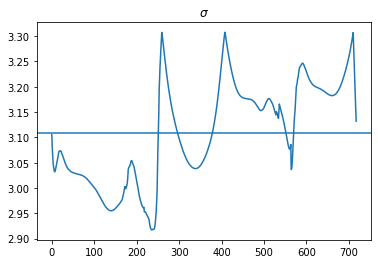

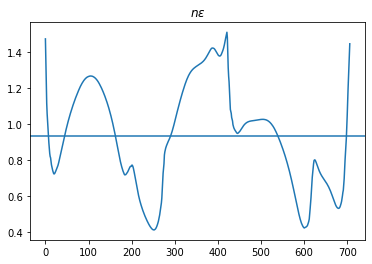

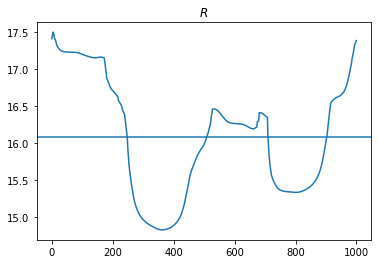

In [70]:
σ_mean_full_sixty_4 = np.mean(σ_sixty_4)
nε_mean_full_sixty_4 = np.mean(nε_sixty_4)
R_mean_full_sixty_4 = np.mean(R_sixty_4)

σ_mean_sixty_4, σ_err_sixty_4, σ_not_outlier_sixty_4 = get_average_fit_parameter2(σ_sixty_4,r"$\sigma$")
nε_mean_sixty_4, nε_err_sixty_4, nε_not_outlier_sixty_4 = get_average_fit_parameter2(nε_sixty_4,r"$n\epsilon$")
R_mean_sixty_4, R_err_sixty_4, R_not_outlier_sixty_4 = get_average_fit_parameter2(R_sixty_4,r"$R$")

σ_outlier_sixty_4 = np.array([not i for i in σ_not_outlier_sixty_4])
nε_outlier_sixty_4 = np.array([not i for i in nε_not_outlier_sixty_4])
R_outlier_sixty_4 = np.array([not i for i in R_not_outlier_sixty_4])

σ_in_sixty_4 = σ_sixty_4[σ_not_outlier_sixty_4]
nε_in_sixty_4 = σ_sixty_4[nε_not_outlier_sixty_4]
R_in_sixty_4 = σ_sixty_4[R_not_outlier_sixty_4]

σ_out_sixty_4 = σ_sixty_4[σ_outlier_sixty_4]
nε_out_sixty_4 = σ_sixty_4[nε_outlier_sixty_4]
R_out_sixty_4 = σ_sixty_4[R_outlier_sixty_4]

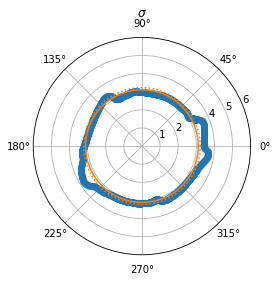

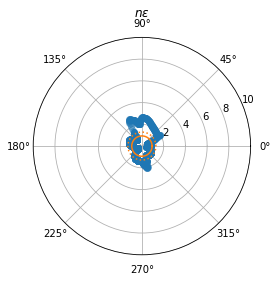

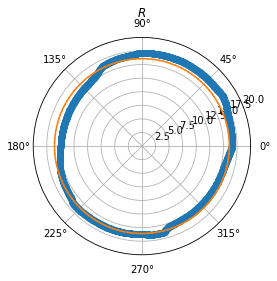

In [71]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 30.0*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_sixty_4[σ_not_outlier_sixty_4]+ϕ_shift,σ_sixty_4[σ_not_outlier_sixty_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_sixty_4[σ_outlier_sixty_4]+ϕ_shift,σ_sixty_4[σ_outlier_sixty_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_sixty_4,np.ones_like(phis_sixty_4)*σ_mean_sixty_4,color="C1")
ax.plot(phis_sixty_4,np.ones_like(phis_sixty_4)*σ_mean_full_sixty_4,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_sixty_4[nε_not_outlier_sixty_4]+ϕ_shift,nε_sixty_4[nε_not_outlier_sixty_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_sixty_4[nε_outlier_sixty_4]+ϕ_shift,nε_sixty_4[nε_outlier_sixty_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_sixty_4,np.ones_like(phis_sixty_4)*nε_mean_sixty_4,color="C1")
ax.plot(phis_sixty_4,np.ones_like(phis_sixty_4)*nε_mean_full_sixty_4,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_sixty_4[R_not_outlier_sixty_4]+ϕ_shift,R_sixty_4[R_not_outlier_sixty_4],linestyle="None",marker="o",color="C0")
ax.plot(phis_sixty_4[R_outlier_sixty_4]+ϕ_shift,R_sixty_4[R_outlier_sixty_4],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_sixty_4,np.ones_like(phis_sixty_4)*R_mean_sixty_4,color="C1")
ax.plot(phis_sixty_4,np.ones_like(phis_sixty_4)*R_mean_full_sixty_4,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-150, 0)

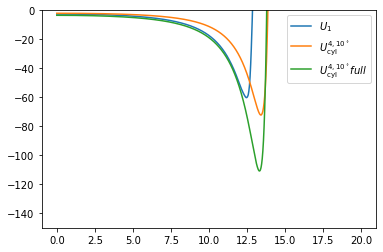

In [72]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_sixty_4,nε_mean_sixty_4,R_mean_sixty_4),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_sixty_4,nε_mean_full_sixty_4,R_mean_full_sixty_4),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-150,0)

In [73]:
result = minimize(U_min,15.0,args=(σ_mean_sixty_4,nε_mean_sixty_4,R_mean_sixty_4))
U_min_sixty_4 = result.fun
r_min_sixty_4 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_sixty_4,nε_mean_full_sixty_4,R_mean_full_sixty_4))
U_min_full_sixty_4 = result.fun
r_min_full_sixty_4 = result.x[0]

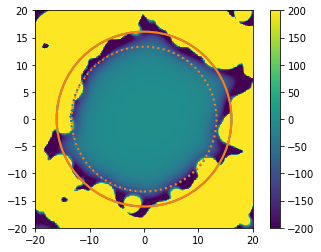

In [74]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_sixty_4,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_sixty_4,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_sixty_4,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_sixty_4,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

# 5 Integrate the pizza wedges and then fit
This method integrates over a pizza slice and then fits to $U_\mathrm{cyl}$

In [75]:
phis_int_ten_5 = grid_phi[0,:]*np.pi/180
phis_int_ten_5_degrees = grid_phi[0,:]
r_int_ten_5 = grid_r[:,0]

#For each pizza slice we'll be chopping up the full potential and integrating it over a set of angles
U_int_ten_5 = np.zeros_like(r_int_ten_5)

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_int_ten_5 = np.zeros_like(phis_int_ten_5)
nε_int_ten_5 = np.zeros_like(phis_int_ten_5)
R_int_ten_5 = np.zeros_like(phis_int_ten_5)
σ_error_int_ten_5 = np.zeros_like(phis_int_ten_5)
nε_error_int_ten_5 = np.zeros_like(phis_int_ten_5)
R_error_int_ten_5 = np.zeros_like(phis_int_ten_5)
r_cutoff_int_ten_5 = np.zeros_like(phis_int_ten_5)

#NOTE: r_cutoff_int_ten_5 will be the closest U_5 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [76]:
# Here we begin the fitting procedure
dϕ = 10.0

for i,phi in enumerate(phis_int_ten_5):
    ϕ_start = phis_int_ten_5_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_int_ten_5_degrees >= ϕ_start) + (phis_int_ten_5_degrees < ϕ_end % 360.0)
        ϕ_fit = phis_int_ten_5_degrees
        ϕ_fit[(phis_int_ten_5_degrees < ϕ_end % 360.0)] += 360.0
        ϕ_fit = ϕ_fit[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    else:
        ϕ_idx = (phis_int_ten_5_degrees >= ϕ_start) * (phis_int_ten_5_degrees < ϕ_end)
        ϕ_fit = phis_int_ten_5_degrees[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    
    #grab the data in ϕ range
    _xdata = grid_r[:,ϕ_idx]
    _ydata = polar_linear[:,ϕ_idx]
    xdata = _xdata[:,ϕ_fit_sortidx]
    ydata = _ydata[:,ϕ_fit_sortidx]
    ϕ_fit = ϕ_fit[ϕ_fit_sortidx]*np.pi/180.0
    
    for j,_r in enumerate(r_int_ten_5):
        U_int_ten_5[j] = simps(ydata[j,:],ϕ_fit)/(dϕ*np.pi/180.0)
    
        
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_int_ten_5 = np.max(r_int_ten_5) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (U_int_ten_5 <= max_U) * (r_int_ten_5 <= r_cut_fit_int_ten_5)
    r_cutoff_int_ten_5[i] = np.max(r_int_ten_5[fitind])

    popt_int_ten_5, pcov_int_ten_5 = curve_fit(U_min, r_int_ten_5[fitind], U_int_ten_5[fitind],[2.5,5,r_int_ten_5[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_int_ten_5 = np.sqrt(np.diag(pcov_int_ten_5))

    σ_int_ten_5[i],nε_int_ten_5[i],R_int_ten_5[i] = popt_int_ten_5
    σ_error_int_ten_5[i],nε_error_int_ten_5[i],R_error_int_ten_5[i] = perr_int_ten_5


1000 values in original $\sigma$ dataset
953 values in truncated $\sigma$ dataset
887 values in truncated $\sigma$ dataset
835 values in truncated $\sigma$ dataset
794 values in truncated $\sigma$ dataset
764 values in truncated $\sigma$ dataset
739 values in truncated $\sigma$ dataset
716 values in truncated $\sigma$ dataset
696 values in truncated $\sigma$ dataset
674 values in truncated $\sigma$ dataset
662 values in truncated $\sigma$ dataset
653 values in truncated $\sigma$ dataset
649 values in truncated $\sigma$ dataset
644 values in truncated $\sigma$ dataset
640 values in truncated $\sigma$ dataset
637 values in truncated $\sigma$ dataset
634 values in truncated $\sigma$ dataset
630 values in truncated $\sigma$ dataset
625 values in truncated $\sigma$ dataset
617 values in truncated $\sigma$ dataset
609 values in truncated $\sigma$ dataset
599 values in truncated $\sigma$ dataset
591 values in truncated $\sigma$ dataset
583 values in truncated $\sigma$ dataset
580 values in tr

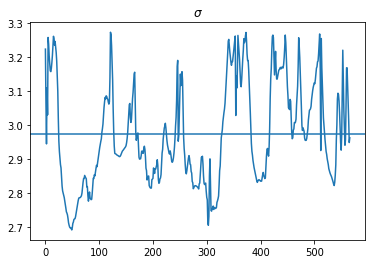

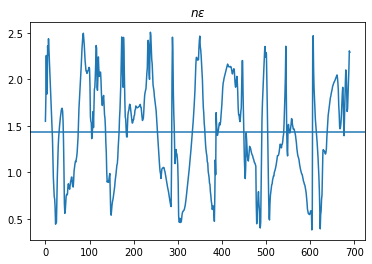

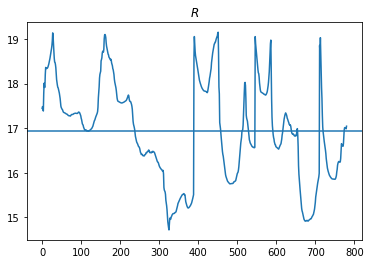

In [77]:
σ_mean_full_int_ten_5 = np.mean(σ_int_ten_5)
nε_mean_full_int_ten_5 = np.mean(nε_int_ten_5)
R_mean_full_int_ten_5 = np.mean(R_int_ten_5)

σ_mean_int_ten_5, σ_err_int_ten_5, σ_not_outlier_int_ten_5 = get_average_fit_parameter2(σ_int_ten_5,r"$\sigma$")
nε_mean_int_ten_5, nε_err_int_ten_5, nε_not_outlier_int_ten_5 = get_average_fit_parameter2(nε_int_ten_5,r"$n\epsilon$")
R_mean_int_ten_5, R_err_int_ten_5, R_not_outlier_int_ten_5 = get_average_fit_parameter2(R_int_ten_5,r"$R$")

σ_outlier_int_ten_5 = np.array([not i for i in σ_not_outlier_int_ten_5])
nε_outlier_int_ten_5 = np.array([not i for i in nε_not_outlier_int_ten_5])
R_outlier_int_ten_5 = np.array([not i for i in R_not_outlier_int_ten_5])

σ_in_int_ten_5 = σ_int_ten_5[σ_not_outlier_int_ten_5]
nε_in_int_ten_5 = σ_int_ten_5[nε_not_outlier_int_ten_5]
R_in_int_ten_5 = σ_int_ten_5[R_not_outlier_int_ten_5]

σ_out_int_ten_5 = σ_int_ten_5[σ_outlier_int_ten_5]
nε_out_int_ten_5 = σ_int_ten_5[nε_outlier_int_ten_5]
R_out_int_ten_5 = σ_int_ten_5[R_outlier_int_ten_5]

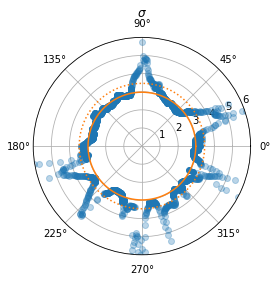

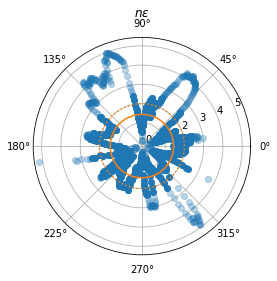

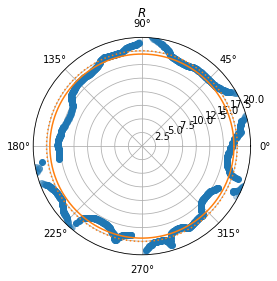

In [78]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 5.0*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_int_ten_5[σ_not_outlier_int_ten_5]+ϕ_shift,σ_int_ten_5[σ_not_outlier_int_ten_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_ten_5[σ_outlier_int_ten_5]+ϕ_shift,σ_int_ten_5[σ_outlier_int_ten_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_int_ten_5,np.ones_like(phis_int_ten_5)*σ_mean_int_ten_5,color="C1")
ax.plot(phis_int_ten_5,np.ones_like(phis_int_ten_5)*σ_mean_full_int_ten_5,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_ten_5[nε_not_outlier_int_ten_5]+ϕ_shift,nε_int_ten_5[nε_not_outlier_int_ten_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_ten_5[nε_outlier_int_ten_5]+ϕ_shift,nε_int_ten_5[nε_outlier_int_ten_5],linestyle="None",marker="o",color="C0",alpha=0.3)
#ax.set_ylim(0,10)
ax.plot(phis_int_ten_5,np.ones_like(phis_int_ten_5)*nε_mean_int_ten_5,color="C1")
ax.plot(phis_int_ten_5,np.ones_like(phis_int_ten_5)*nε_mean_full_int_ten_5,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_ten_5[R_not_outlier_int_ten_5]+ϕ_shift,R_int_ten_5[R_not_outlier_int_ten_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_ten_5[R_outlier_int_ten_5]+ϕ_shift,R_int_ten_5[R_outlier_int_ten_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_int_ten_5,np.ones_like(phis_int_ten_5)*R_mean_int_ten_5,color="C1")
ax.plot(phis_int_ten_5,np.ones_like(phis_int_ten_5)*R_mean_full_int_ten_5,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

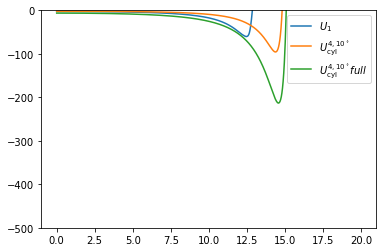

In [79]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_int_ten_5,nε_mean_int_ten_5,R_mean_int_ten_5),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_int_ten_5,nε_mean_full_int_ten_5,R_mean_full_int_ten_5),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [80]:
result = minimize(U_min,15.0,args=(σ_mean_int_ten_5,nε_mean_int_ten_5,R_mean_int_ten_5))
U_min_int_ten_5 = result.fun
r_min_int_ten_5 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_int_ten_5,nε_mean_full_int_ten_5,R_mean_full_int_ten_5))
U_min_full_int_ten_5 = result.fun
r_min_full_int_ten_5 = result.x[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountere

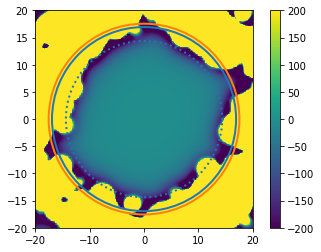

In [81]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_int_ten_5,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_int_ten_5,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_int_ten_5,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_int_ten_5,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $5^\circ$

In [82]:
phis_int_five_5 = grid_phi[0,:]*np.pi/180
phis_int_five_5_degrees = grid_phi[0,:]
r_int_five_5 = grid_r[:,0]

#For each pizza slice we'll be chopping up the full potential and integrating it over a set of angles
U_int_five_5 = np.zeros_like(r_int_five_5)

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_int_five_5 = np.zeros_like(phis_int_five_5)
nε_int_five_5 = np.zeros_like(phis_int_five_5)
R_int_five_5 = np.zeros_like(phis_int_five_5)
σ_error_int_five_5 = np.zeros_like(phis_int_five_5)
nε_error_int_five_5 = np.zeros_like(phis_int_five_5)
R_error_int_five_5 = np.zeros_like(phis_int_five_5)
r_cutoff_int_five_5 = np.zeros_like(phis_int_five_5)

#NOTE: r_cutoff_int_five_5 will be the closest U_5 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [83]:
# Here we begin the fitting procedure
dϕ = 5.0

for i,phi in enumerate(phis_int_five_5):
    ϕ_start = phis_int_five_5_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_int_five_5_degrees >= ϕ_start) + (phis_int_five_5_degrees < ϕ_end % 360.0)
        ϕ_fit = phis_int_five_5_degrees
        ϕ_fit[(phis_int_five_5_degrees < ϕ_end % 360.0)] += 360.0
        ϕ_fit = ϕ_fit[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    else:
        ϕ_idx = (phis_int_five_5_degrees >= ϕ_start) * (phis_int_five_5_degrees < ϕ_end)
        ϕ_fit = phis_int_five_5_degrees[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    
    #grab the data in ϕ range
    _xdata = grid_r[:,ϕ_idx]
    _ydata = polar_linear[:,ϕ_idx]
    xdata = _xdata[:,ϕ_fit_sortidx]
    ydata = _ydata[:,ϕ_fit_sortidx]
    ϕ_fit = ϕ_fit[ϕ_fit_sortidx]*np.pi/180.0
    
    for j,_r in enumerate(r_int_five_5):
        U_int_five_5[j] = simps(ydata[j,:],ϕ_fit)/(dϕ*np.pi/180.0)
    
        
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_int_five_5 = np.max(r_int_five_5) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (U_int_five_5 <= max_U) * (r_int_five_5 <= r_cut_fit_int_five_5)
    r_cutoff_int_five_5[i] = np.max(r_int_five_5[fitind])

    popt_int_five_5, pcov_int_five_5 = curve_fit(U_min, r_int_five_5[fitind], U_int_five_5[fitind],[2.5,5,r_int_five_5[fitind][-1]+5],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

    perr_int_five_5 = np.sqrt(np.diag(pcov_int_five_5))

    σ_int_five_5[i],nε_int_five_5[i],R_int_five_5[i] = popt_int_five_5
    σ_error_int_five_5[i],nε_error_int_five_5[i],R_error_int_five_5[i] = perr_int_five_5


1000 values in original $\sigma$ dataset
950 values in truncated $\sigma$ dataset
884 values in truncated $\sigma$ dataset
837 values in truncated $\sigma$ dataset
790 values in truncated $\sigma$ dataset
750 values in truncated $\sigma$ dataset
723 values in truncated $\sigma$ dataset
711 values in truncated $\sigma$ dataset
697 values in truncated $\sigma$ dataset
684 values in truncated $\sigma$ dataset
670 values in truncated $\sigma$ dataset
653 values in truncated $\sigma$ dataset
640 values in truncated $\sigma$ dataset
637 values in truncated $\sigma$ dataset
635 values in truncated $\sigma$ dataset
632 values in truncated $\sigma$ dataset
628 values in truncated $\sigma$ dataset
622 values in truncated $\sigma$ dataset
619 values in truncated $\sigma$ dataset
617 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
975 values in truncated $n\epsilon$ dataset
941 values in truncated $n\epsilon$ dataset
913 values in truncated $n\epsilon$ dataset
878 

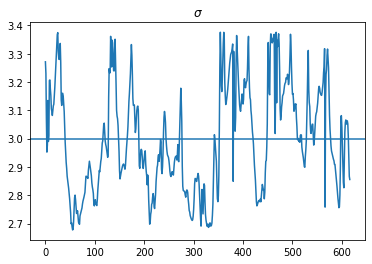

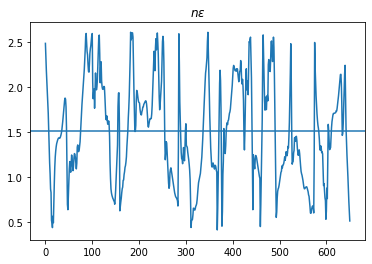

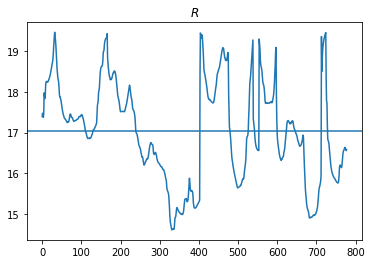

In [84]:
σ_mean_full_int_five_5 = np.mean(σ_int_five_5)
nε_mean_full_int_five_5 = np.mean(nε_int_five_5)
R_mean_full_int_five_5 = np.mean(R_int_five_5)

σ_mean_int_five_5, σ_err_int_five_5, σ_not_outlier_int_five_5 = get_average_fit_parameter2(σ_int_five_5,r"$\sigma$")
nε_mean_int_five_5, nε_err_int_five_5, nε_not_outlier_int_five_5 = get_average_fit_parameter2(nε_int_five_5,r"$n\epsilon$")
R_mean_int_five_5, R_err_int_five_5, R_not_outlier_int_five_5 = get_average_fit_parameter2(R_int_five_5,r"$R$")

σ_outlier_int_five_5 = np.array([not i for i in σ_not_outlier_int_five_5])
nε_outlier_int_five_5 = np.array([not i for i in nε_not_outlier_int_five_5])
R_outlier_int_five_5 = np.array([not i for i in R_not_outlier_int_five_5])

σ_in_int_five_5 = σ_int_five_5[σ_not_outlier_int_five_5]
nε_in_int_five_5 = σ_int_five_5[nε_not_outlier_int_five_5]
R_in_int_five_5 = σ_int_five_5[R_not_outlier_int_five_5]

σ_out_int_five_5 = σ_int_five_5[σ_outlier_int_five_5]
nε_out_int_five_5 = σ_int_five_5[nε_outlier_int_five_5]
R_out_int_five_5 = σ_int_five_5[R_outlier_int_five_5]

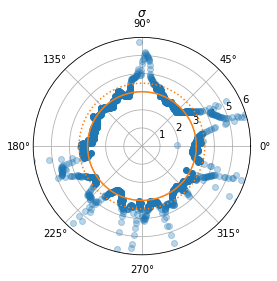

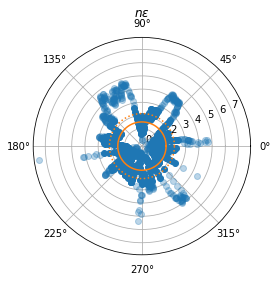

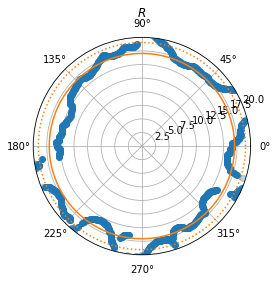

In [85]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 2.5*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_int_five_5[σ_not_outlier_int_five_5]+ϕ_shift,σ_int_five_5[σ_not_outlier_int_five_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_five_5[σ_outlier_int_five_5]+ϕ_shift,σ_int_five_5[σ_outlier_int_five_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_int_five_5,np.ones_like(phis_int_five_5)*σ_mean_int_five_5,color="C1")
ax.plot(phis_int_five_5,np.ones_like(phis_int_five_5)*σ_mean_full_int_five_5,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_five_5[nε_not_outlier_int_five_5]+ϕ_shift,nε_int_five_5[nε_not_outlier_int_five_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_five_5[nε_outlier_int_five_5]+ϕ_shift,nε_int_five_5[nε_outlier_int_five_5],linestyle="None",marker="o",color="C0",alpha=0.3)
#ax.set_ylim(0,10)
ax.plot(phis_int_five_5,np.ones_like(phis_int_five_5)*nε_mean_int_five_5,color="C1")
ax.plot(phis_int_five_5,np.ones_like(phis_int_five_5)*nε_mean_full_int_five_5,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_five_5[R_not_outlier_int_five_5]+ϕ_shift,R_int_five_5[R_not_outlier_int_five_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_five_5[R_outlier_int_five_5]+ϕ_shift,R_int_five_5[R_outlier_int_five_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_int_five_5,np.ones_like(phis_int_five_5)*R_mean_int_five_5,color="C1")
ax.plot(phis_int_five_5,np.ones_like(phis_int_five_5)*R_mean_full_int_five_5,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

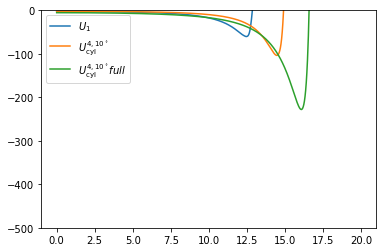

In [86]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_int_five_5,nε_mean_int_five_5,R_mean_int_five_5),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_int_five_5,nε_mean_full_int_five_5,R_mean_full_int_five_5),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [87]:
result = minimize(U_min,15.0,args=(σ_mean_int_five_5,nε_mean_int_five_5,R_mean_int_five_5))
U_min_int_five_5 = result.fun
r_min_int_five_5 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_int_five_5,nε_mean_full_int_five_5,R_mean_full_int_five_5))
U_min_full_int_five_5 = result.fun
r_min_full_int_five_5 = result.x[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power


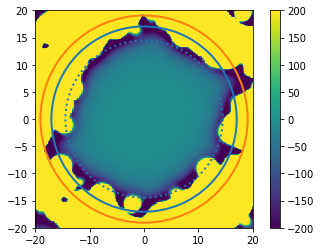

In [88]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_int_five_5,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_int_five_5,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_int_five_5,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_int_five_5,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $1^\circ$

In [89]:
phis_int_one_5 = grid_phi[0,:]*np.pi/180
phis_int_one_5_degrees = grid_phi[0,:]
r_int_one_5 = grid_r[:,0]

#For each pizza slice we'll be chopping up the full potential and integrating it over a set of angles
U_int_one_5 = np.zeros_like(r_int_one_5)

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_int_one_5 = np.zeros_like(phis_int_one_5)
nε_int_one_5 = np.zeros_like(phis_int_one_5)
R_int_one_5 = np.zeros_like(phis_int_one_5)
σ_error_int_one_5 = np.zeros_like(phis_int_one_5)
nε_error_int_one_5 = np.zeros_like(phis_int_one_5)
R_error_int_one_5 = np.zeros_like(phis_int_one_5)
r_cutoff_int_one_5 = np.zeros_like(phis_int_one_5)

#NOTE: r_cutoff_int_one_5 will be the closest U_5 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [90]:
# Here we begin the fitting procedure
dϕ = 1.0
initial_guess = [2.5,5,25.0]
for i,phi in enumerate(phis_int_one_5):
    ϕ_start = phis_int_one_5_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_int_one_5_degrees >= ϕ_start) + (phis_int_one_5_degrees < ϕ_end % 360.0)
        ϕ_fit = phis_int_one_5_degrees
        ϕ_fit[(phis_int_one_5_degrees < ϕ_end % 360.0)] += 360.0
        ϕ_fit = ϕ_fit[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    else:
        ϕ_idx = (phis_int_one_5_degrees >= ϕ_start) * (phis_int_one_5_degrees < ϕ_end)
        ϕ_fit = phis_int_one_5_degrees[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    
    #grab the data in ϕ range
    _xdata = grid_r[:,ϕ_idx]
    _ydata = polar_linear[:,ϕ_idx]
    xdata = _xdata[:,ϕ_fit_sortidx]
    ydata = _ydata[:,ϕ_fit_sortidx]
    ϕ_fit = ϕ_fit[ϕ_fit_sortidx]*np.pi/180.0
    
    for j,_r in enumerate(r_int_one_5):
        U_int_one_5[j] = simps(ydata[j,:],ϕ_fit)/(dϕ*np.pi/180.0)
    
        
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_int_one_5 = np.max(r_int_one_5) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (U_int_one_5 <= max_U) * (r_int_one_5 <= r_cut_fit_int_one_5)
    r_cutoff_int_one_5[i] = np.max(r_int_one_5[fitind])
    initial_guess = [2.5,5,r_int_one_5[fitind][-1]+5]
    popt_int_one_5, pcov_int_one_5 = curve_fit(U_min, r_int_one_5[fitind], U_int_one_5[fitind],initial_guess,bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)
    perr_int_one_5 = np.sqrt(np.diag(pcov_int_one_5))

    σ_int_one_5[i],nε_int_one_5[i],R_int_one_5[i] = popt_int_one_5
    σ_error_int_one_5[i],nε_error_int_one_5[i],R_error_int_one_5[i] = perr_int_one_5


1000 values in original $\sigma$ dataset
949 values in truncated $\sigma$ dataset
909 values in truncated $\sigma$ dataset
875 values in truncated $\sigma$ dataset
847 values in truncated $\sigma$ dataset
823 values in truncated $\sigma$ dataset
808 values in truncated $\sigma$ dataset
801 values in truncated $\sigma$ dataset
798 values in truncated $\sigma$ dataset
797 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
1000 values in truncated $n\epsilon$ dataset
1000 values in original $R$ dataset
999 values in truncated $R$ dataset
936 values in truncated $R$ dataset
911 values in truncated $R$ dataset
903 values in truncated $R$ dataset
902 values in truncated $R$ dataset


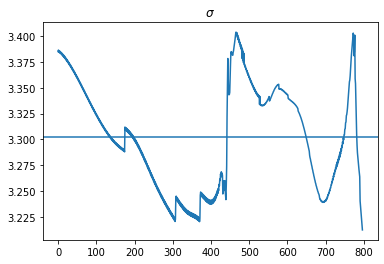

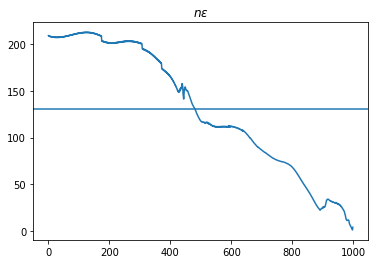

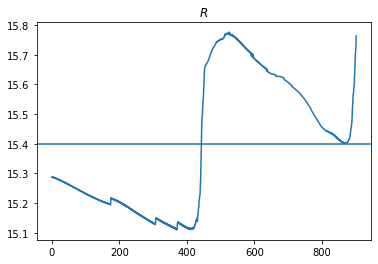

In [91]:
σ_mean_full_int_one_5 = np.mean(σ_int_one_5)
nε_mean_full_int_one_5 = np.mean(nε_int_one_5)
R_mean_full_int_one_5 = np.mean(R_int_one_5)

σ_mean_int_one_5, σ_err_int_one_5, σ_not_outlier_int_one_5 = get_average_fit_parameter2(σ_int_one_5,r"$\sigma$")
nε_mean_int_one_5, nε_err_int_one_5, nε_not_outlier_int_one_5 = get_average_fit_parameter2(nε_int_one_5,r"$n\epsilon$")
R_mean_int_one_5, R_err_int_one_5, R_not_outlier_int_one_5 = get_average_fit_parameter2(R_int_one_5,r"$R$")

σ_outlier_int_one_5 = np.array([not i for i in σ_not_outlier_int_one_5])
nε_outlier_int_one_5 = np.array([not i for i in nε_not_outlier_int_one_5])
R_outlier_int_one_5 = np.array([not i for i in R_not_outlier_int_one_5])

σ_in_int_one_5 = σ_int_one_5[σ_not_outlier_int_one_5]
nε_in_int_one_5 = σ_int_one_5[nε_not_outlier_int_one_5]
R_in_int_one_5 = σ_int_one_5[R_not_outlier_int_one_5]

σ_out_int_one_5 = σ_int_one_5[σ_outlier_int_one_5]
nε_out_int_one_5 = σ_int_one_5[nε_outlier_int_one_5]
R_out_int_one_5 = σ_int_one_5[R_outlier_int_one_5]

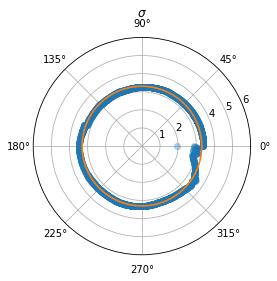

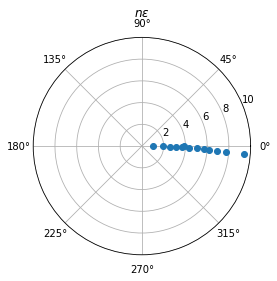

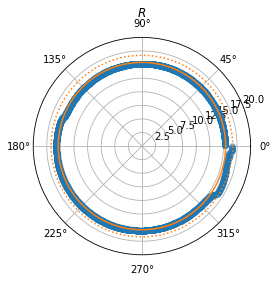

In [92]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 0.5*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_int_one_5[σ_not_outlier_int_one_5]+ϕ_shift,σ_int_one_5[σ_not_outlier_int_one_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_one_5[σ_outlier_int_one_5]+ϕ_shift,σ_int_one_5[σ_outlier_int_one_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_int_one_5,np.ones_like(phis_int_one_5)*σ_mean_int_one_5,color="C1")
ax.plot(phis_int_one_5,np.ones_like(phis_int_one_5)*σ_mean_full_int_one_5,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_one_5[nε_not_outlier_int_one_5]+ϕ_shift,nε_int_one_5[nε_not_outlier_int_one_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_one_5[nε_outlier_int_one_5]+ϕ_shift,nε_int_one_5[nε_outlier_int_one_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_int_one_5,np.ones_like(phis_int_one_5)*nε_mean_int_one_5,color="C1")
ax.plot(phis_int_one_5,np.ones_like(phis_int_one_5)*nε_mean_full_int_one_5,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_one_5[R_not_outlier_int_one_5]+ϕ_shift,R_int_one_5[R_not_outlier_int_one_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_one_5[R_outlier_int_one_5]+ϕ_shift,R_int_one_5[R_outlier_int_one_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_int_one_5,np.ones_like(phis_int_one_5)*R_mean_int_one_5,color="C1")
ax.plot(phis_int_one_5,np.ones_like(phis_int_one_5)*R_mean_full_int_one_5,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

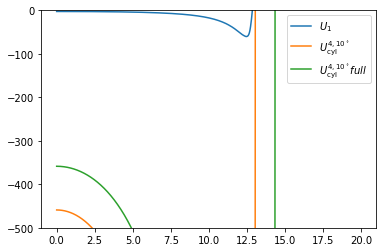

In [93]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_int_one_5,nε_mean_int_one_5,R_mean_int_one_5),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_int_one_5,nε_mean_full_int_one_5,R_mean_full_int_one_5),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [94]:
result = minimize(U_min,15.0,args=(σ_mean_int_one_5,nε_mean_int_one_5,R_mean_int_one_5))
U_min_int_one_5 = result.fun
r_min_int_one_5 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_int_one_5,nε_mean_full_int_one_5,R_mean_full_int_one_5))
U_min_full_int_one_5 = result.fun
r_min_full_int_one_5 = result.x[0]

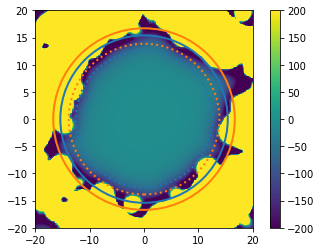

In [95]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_int_one_5,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_int_one_5,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_int_one_5,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_int_one_5,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $30^\circ$

In [96]:
phis_int_thirty_5 = grid_phi[0,:]*np.pi/180
phis_int_thirty_5_degrees = grid_phi[0,:]
r_int_thirty_5 = grid_r[:,0]

#For each pizza slice we'll be chopping up the full potential and integrating it over a set of angles
U_int_thirty_5 = np.zeros_like(r_int_thirty_5)

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_int_thirty_5 = np.zeros_like(phis_int_thirty_5)
nε_int_thirty_5 = np.zeros_like(phis_int_thirty_5)
R_int_thirty_5 = np.zeros_like(phis_int_thirty_5)
σ_error_int_thirty_5 = np.zeros_like(phis_int_thirty_5)
nε_error_int_thirty_5 = np.zeros_like(phis_int_thirty_5)
R_error_int_thirty_5 = np.zeros_like(phis_int_thirty_5)
r_cutoff_int_thirty_5 = np.zeros_like(phis_int_thirty_5)

#NOTE: r_cutoff_int_thirty_5 will be the closest U_5 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [97]:
# Here we begin the fitting procedure
dϕ = 30.0
initial_guess = [2.5,5,25.0]
for i,phi in enumerate(phis_int_thirty_5):
    ϕ_start = phis_int_thirty_5_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_int_thirty_5_degrees >= ϕ_start) + (phis_int_thirty_5_degrees < ϕ_end % 360.0)
        ϕ_fit = phis_int_thirty_5_degrees
        ϕ_fit[(phis_int_thirty_5_degrees < ϕ_end % 360.0)] += 360.0
        ϕ_fit = ϕ_fit[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    else:
        ϕ_idx = (phis_int_thirty_5_degrees >= ϕ_start) * (phis_int_thirty_5_degrees < ϕ_end)
        ϕ_fit = phis_int_thirty_5_degrees[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    
    #grab the data in ϕ range
    _xdata = grid_r[:,ϕ_idx]
    _ydata = polar_linear[:,ϕ_idx]
    xdata = _xdata[:,ϕ_fit_sortidx]
    ydata = _ydata[:,ϕ_fit_sortidx]
    ϕ_fit = ϕ_fit[ϕ_fit_sortidx]*np.pi/180.0
    
    for j,_r in enumerate(r_int_thirty_5):
        U_int_thirty_5[j] = simps(ydata[j,:],ϕ_fit)/(dϕ*np.pi/180.0)
    
        
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_int_thirty_5 = np.max(r_int_thirty_5) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (U_int_thirty_5 <= max_U) * (r_int_thirty_5 <= r_cut_fit_int_thirty_5)
    r_cutoff_int_thirty_5[i] = np.max(r_int_thirty_5[fitind])

    initial_guess = [2.5,5,r_int_thirty_5[fitind][-1]+5]

    popt_int_thirty_5, pcov_int_thirty_5 = curve_fit(U_min, r_int_thirty_5[fitind], U_int_thirty_5[fitind],initial_guess,bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)
    perr_int_thirty_5 = np.sqrt(np.diag(pcov_int_thirty_5))

    σ_int_thirty_5[i],nε_int_thirty_5[i],R_int_thirty_5[i] = popt_int_thirty_5
    σ_error_int_thirty_5[i],nε_error_int_thirty_5[i],R_error_int_thirty_5[i] = perr_int_thirty_5


1000 values in original $\sigma$ dataset
949 values in truncated $\sigma$ dataset
909 values in truncated $\sigma$ dataset
875 values in truncated $\sigma$ dataset
847 values in truncated $\sigma$ dataset
823 values in truncated $\sigma$ dataset
808 values in truncated $\sigma$ dataset
801 values in truncated $\sigma$ dataset
798 values in truncated $\sigma$ dataset
797 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
1000 values in truncated $n\epsilon$ dataset
1000 values in original $R$ dataset
999 values in truncated $R$ dataset
936 values in truncated $R$ dataset
911 values in truncated $R$ dataset
903 values in truncated $R$ dataset
902 values in truncated $R$ dataset


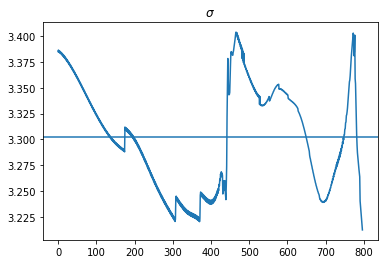

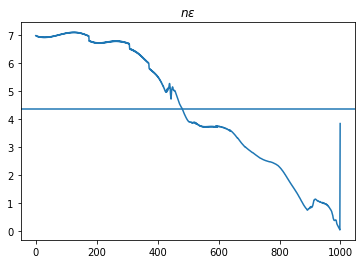

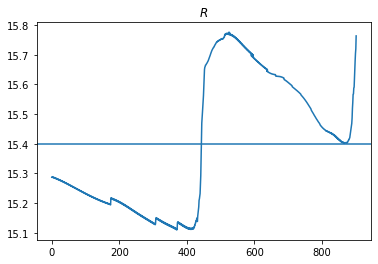

In [98]:
σ_mean_full_int_thirty_5 = np.mean(σ_int_thirty_5)
nε_mean_full_int_thirty_5 = np.mean(nε_int_thirty_5)
R_mean_full_int_thirty_5 = np.mean(R_int_thirty_5)

σ_mean_int_thirty_5, σ_err_int_thirty_5, σ_not_outlier_int_thirty_5 = get_average_fit_parameter2(σ_int_thirty_5,r"$\sigma$")
nε_mean_int_thirty_5, nε_err_int_thirty_5, nε_not_outlier_int_thirty_5 = get_average_fit_parameter2(nε_int_thirty_5,r"$n\epsilon$")
R_mean_int_thirty_5, R_err_int_thirty_5, R_not_outlier_int_thirty_5 = get_average_fit_parameter2(R_int_thirty_5,r"$R$")

σ_outlier_int_thirty_5 = np.array([not i for i in σ_not_outlier_int_thirty_5])
nε_outlier_int_thirty_5 = np.array([not i for i in nε_not_outlier_int_thirty_5])
R_outlier_int_thirty_5 = np.array([not i for i in R_not_outlier_int_thirty_5])

σ_in_int_thirty_5 = σ_int_thirty_5[σ_not_outlier_int_thirty_5]
nε_in_int_thirty_5 = σ_int_thirty_5[nε_not_outlier_int_thirty_5]
R_in_int_thirty_5 = σ_int_thirty_5[R_not_outlier_int_thirty_5]

σ_out_int_thirty_5 = σ_int_thirty_5[σ_outlier_int_thirty_5]
nε_out_int_thirty_5 = σ_int_thirty_5[nε_outlier_int_thirty_5]
R_out_int_thirty_5 = σ_int_thirty_5[R_outlier_int_thirty_5]

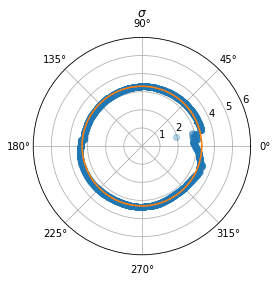

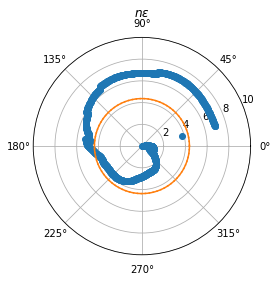

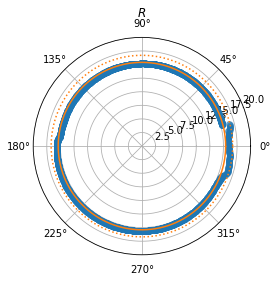

In [99]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 15.0*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_int_thirty_5[σ_not_outlier_int_thirty_5]+ϕ_shift,σ_int_thirty_5[σ_not_outlier_int_thirty_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_thirty_5[σ_outlier_int_thirty_5]+ϕ_shift,σ_int_thirty_5[σ_outlier_int_thirty_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_int_thirty_5,np.ones_like(phis_int_thirty_5)*σ_mean_int_thirty_5,color="C1")
ax.plot(phis_int_thirty_5,np.ones_like(phis_int_thirty_5)*σ_mean_full_int_thirty_5,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_thirty_5[nε_not_outlier_int_thirty_5]+ϕ_shift,nε_int_thirty_5[nε_not_outlier_int_thirty_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_thirty_5[nε_outlier_int_thirty_5]+ϕ_shift,nε_int_thirty_5[nε_outlier_int_thirty_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,10)
ax.plot(phis_int_thirty_5,np.ones_like(phis_int_thirty_5)*nε_mean_int_thirty_5,color="C1")
ax.plot(phis_int_thirty_5,np.ones_like(phis_int_thirty_5)*nε_mean_full_int_thirty_5,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_thirty_5[R_not_outlier_int_thirty_5]+ϕ_shift,R_int_thirty_5[R_not_outlier_int_thirty_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_thirty_5[R_outlier_int_thirty_5]+ϕ_shift,R_int_thirty_5[R_outlier_int_thirty_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_int_thirty_5,np.ones_like(phis_int_thirty_5)*R_mean_int_thirty_5,color="C1")
ax.plot(phis_int_thirty_5,np.ones_like(phis_int_thirty_5)*R_mean_full_int_thirty_5,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

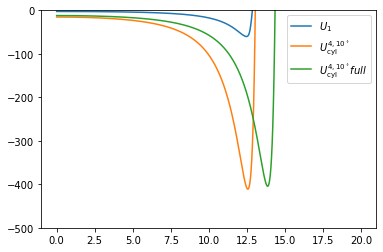

In [100]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_int_thirty_5,nε_mean_int_thirty_5,R_mean_int_thirty_5),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_int_thirty_5,nε_mean_full_int_thirty_5,R_mean_full_int_thirty_5),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [101]:
result = minimize(U_min,15.0,args=(σ_mean_int_thirty_5,nε_mean_int_thirty_5,R_mean_int_thirty_5))
U_min_int_thirty_5 = result.fun
r_min_int_thirty_5 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_int_thirty_5,nε_mean_full_int_thirty_5,R_mean_full_int_thirty_5))
U_min_full_int_thirty_5 = result.fun
r_min_full_int_thirty_5 = result.x[0]

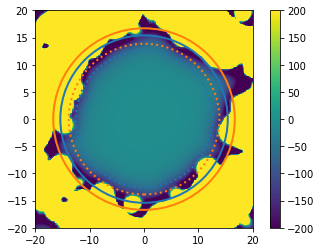

In [102]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_int_thirty_5,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_int_thirty_5,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_int_thirty_5,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_int_thirty_5,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

Now $60^\circ$

In [103]:
phis_int_sixty_5 = grid_phi[0,:]*np.pi/180
phis_int_sixty_5_degrees = grid_phi[0,:]
r_int_sixty_5 = grid_r[:,0]

#For each pizza slice we'll be chopping up the full potential and integrating it over a set of angles
U_int_sixty_5 = np.zeros_like(r_int_sixty_5)

#Each slice will have a different sigma, epsilon, R, and cutoff values
σ_int_sixty_5 = np.zeros_like(phis_int_sixty_5)
nε_int_sixty_5 = np.zeros_like(phis_int_sixty_5)
R_int_sixty_5 = np.zeros_like(phis_int_sixty_5)
σ_error_int_sixty_5 = np.zeros_like(phis_int_sixty_5)
nε_error_int_sixty_5 = np.zeros_like(phis_int_sixty_5)
R_error_int_sixty_5 = np.zeros_like(phis_int_sixty_5)
r_cutoff_int_sixty_5 = np.zeros_like(phis_int_sixty_5)

#NOTE: r_cutoff_int_sixty_5 will be the closest U_5 = 0 point within the slice,
#      this will keep the fitting procedure in line with what gave better
#      looking results for method 3

In [104]:
# Here we begin the fitting procedure
dϕ = 60.0
initial_guess = [2.5,5,25.0]
for i,phi in enumerate(phis_int_sixty_5):
    ϕ_start = phis_int_sixty_5_degrees[i]
    ϕ_end = ϕ_start + dϕ
    if ϕ_end > 360.0:
        ϕ_idx = (phis_int_sixty_5_degrees >= ϕ_start) + (phis_int_sixty_5_degrees < ϕ_end % 360.0)
        ϕ_fit = phis_int_sixty_5_degrees
        ϕ_fit[(phis_int_sixty_5_degrees < ϕ_end % 360.0)] += 360.0
        ϕ_fit = ϕ_fit[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)
    else:
        ϕ_idx = (phis_int_sixty_5_degrees >= ϕ_start) * (phis_int_sixty_5_degrees < ϕ_end)
        ϕ_fit = phis_int_sixty_5_degrees[ϕ_idx]
        ϕ_fit_sortidx = np.argsort(ϕ_fit)*np.pi/180.0
    
    #grab the data in ϕ range
    _xdata = grid_r[:,ϕ_idx]
    _ydata = polar_linear[:,ϕ_idx]
    xdata = _xdata[:,ϕ_fit_sortidx]
    ydata = _ydata[:,ϕ_fit_sortidx]
    ϕ_fit = ϕ_fit[ϕ_fit_sortidx]
    
    for j,_r in enumerate(r_int_sixty_5):
        U_int_sixty_5[j] = simps(ydata[j,:],ϕ_fit)/(dϕ*np.pi/180.0)
    
        
    # The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 0
    max_U = 0.0

    r_cut_fit_int_sixty_5 = np.max(r_int_sixty_5) + 1

    # FIXME Should I cut when we reach the first wall? Right now it just drops the data (see places like 90 degrees view)
    fitind = (U_int_sixty_5 <= max_U) * (r_int_sixty_5 <= r_cut_fit_int_sixty_5)
    r_cutoff_int_sixty_5[i] = np.max(r_int_sixty_5[fitind])

    initial_guess = [2.5,5,r_int_sixty_5[fitind][-1]+5]

    popt_int_sixty_5, pcov_int_sixty_5 = curve_fit(U_min, r_int_sixty_5[fitind], U_int_sixty_5[fitind],initial_guess,bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)
    initial_guess = pcov_int_sixty_5
    perr_int_sixty_5 = np.sqrt(np.diag(pcov_int_sixty_5))

    σ_int_sixty_5[i],nε_int_sixty_5[i],R_int_sixty_5[i] = popt_int_sixty_5
    σ_error_int_sixty_5[i],nε_error_int_sixty_5[i],R_error_int_sixty_5[i] = perr_int_sixty_5


1000 values in original $\sigma$ dataset
949 values in truncated $\sigma$ dataset
909 values in truncated $\sigma$ dataset
875 values in truncated $\sigma$ dataset
847 values in truncated $\sigma$ dataset
823 values in truncated $\sigma$ dataset
808 values in truncated $\sigma$ dataset
801 values in truncated $\sigma$ dataset
798 values in truncated $\sigma$ dataset
797 values in truncated $\sigma$ dataset
1000 values in original $n\epsilon$ dataset
1000 values in truncated $n\epsilon$ dataset
1000 values in original $R$ dataset
999 values in truncated $R$ dataset
936 values in truncated $R$ dataset
911 values in truncated $R$ dataset
903 values in truncated $R$ dataset
902 values in truncated $R$ dataset


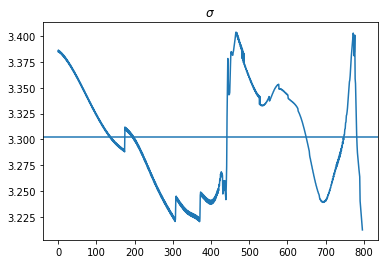

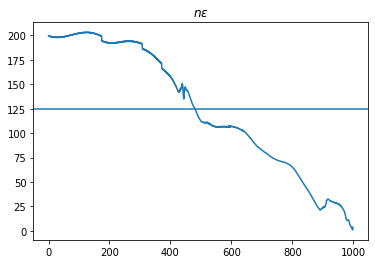

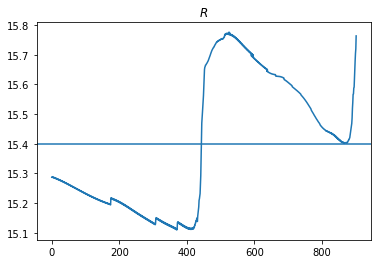

In [105]:
σ_mean_full_int_sixty_5 = np.mean(σ_int_sixty_5)
nε_mean_full_int_sixty_5 = np.mean(nε_int_sixty_5)
R_mean_full_int_sixty_5 = np.mean(R_int_sixty_5)

σ_mean_int_sixty_5, σ_err_int_sixty_5, σ_not_outlier_int_sixty_5 = get_average_fit_parameter2(σ_int_sixty_5,r"$\sigma$")
nε_mean_int_sixty_5, nε_err_int_sixty_5, nε_not_outlier_int_sixty_5 = get_average_fit_parameter2(nε_int_sixty_5,r"$n\epsilon$")
R_mean_int_sixty_5, R_err_int_sixty_5, R_not_outlier_int_sixty_5 = get_average_fit_parameter2(R_int_sixty_5,r"$R$")

σ_outlier_int_sixty_5 = np.array([not i for i in σ_not_outlier_int_sixty_5])
nε_outlier_int_sixty_5 = np.array([not i for i in nε_not_outlier_int_sixty_5])
R_outlier_int_sixty_5 = np.array([not i for i in R_not_outlier_int_sixty_5])

σ_in_int_sixty_5 = σ_int_sixty_5[σ_not_outlier_int_sixty_5]
nε_in_int_sixty_5 = σ_int_sixty_5[nε_not_outlier_int_sixty_5]
R_in_int_sixty_5 = σ_int_sixty_5[R_not_outlier_int_sixty_5]

σ_out_int_sixty_5 = σ_int_sixty_5[σ_outlier_int_sixty_5]
nε_out_int_sixty_5 = σ_int_sixty_5[nε_outlier_int_sixty_5]
R_out_int_sixty_5 = σ_int_sixty_5[R_outlier_int_sixty_5]

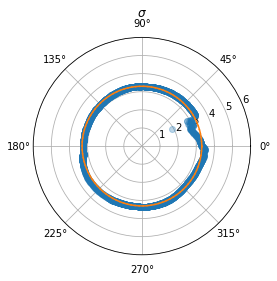

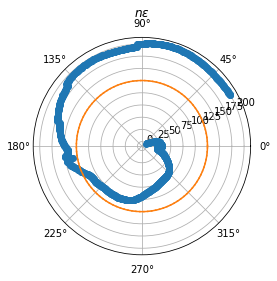

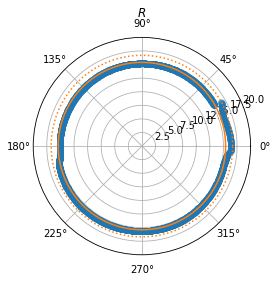

In [111]:
fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ϕ_shift = 30.0*np.pi/180.0 # Center on wedges (needs to be in radians)
ax.plot(phis_int_sixty_5[σ_not_outlier_int_sixty_5]+ϕ_shift,σ_int_sixty_5[σ_not_outlier_int_sixty_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_sixty_5[σ_outlier_int_sixty_5]+ϕ_shift,σ_int_sixty_5[σ_outlier_int_sixty_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,6)
ax.plot(phis_int_sixty_5,np.ones_like(phis_int_sixty_5)*σ_mean_int_sixty_5,color="C1")
ax.plot(phis_int_sixty_5,np.ones_like(phis_int_sixty_5)*σ_mean_full_int_sixty_5,color="C1",linestyle=":")
ax.set_title(r"$\sigma$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_sixty_5[nε_not_outlier_int_sixty_5]+ϕ_shift,nε_int_sixty_5[nε_not_outlier_int_sixty_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_sixty_5[nε_outlier_int_sixty_5]+ϕ_shift,nε_int_sixty_5[nε_outlier_int_sixty_5],linestyle="None",marker="o",color="C0",alpha=0.3)
#ax.set_ylim(0,10)
ax.plot(phis_int_sixty_5,np.ones_like(phis_int_sixty_5)*nε_mean_int_sixty_5,color="C1")
ax.plot(phis_int_sixty_5,np.ones_like(phis_int_sixty_5)*nε_mean_full_int_sixty_5,color="C1",linestyle=":")
ax.set_title(r"$n\epsilon$",pad=10)

fig,ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(phis_int_sixty_5[R_not_outlier_int_sixty_5]+ϕ_shift,R_int_sixty_5[R_not_outlier_int_sixty_5],linestyle="None",marker="o",color="C0")
ax.plot(phis_int_sixty_5[R_outlier_int_sixty_5]+ϕ_shift,R_int_sixty_5[R_outlier_int_sixty_5],linestyle="None",marker="o",color="C0",alpha=0.3)
ax.set_ylim(0,20)
ax.set_title(r"$R$",pad=10)
ax.plot(phis_int_sixty_5,np.ones_like(phis_int_sixty_5)*R_mean_int_sixty_5,color="C1")
ax.plot(phis_int_sixty_5,np.ones_like(phis_int_sixty_5)*R_mean_full_int_sixty_5,color="C1",linestyle=":")

The solid is the average of each parameter throwing out outliers, the dashed is the average over the full set of angles for that set of data.

(-500, 0)

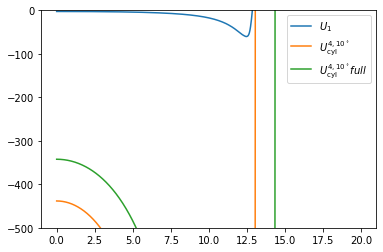

In [107]:
fig,ax = plt.subplots()
ax.plot(r_1,U_1,label=r"$U_1$")
ax.plot(r_1,U_min(r_1,σ_mean_int_sixty_5,nε_mean_int_sixty_5,R_mean_int_sixty_5),label=r"$U_\mathrm{cyl}^{4,10^\circ}$")
ax.plot(r_1,U_min(r_1,σ_mean_full_int_sixty_5,nε_mean_full_int_sixty_5,R_mean_full_int_sixty_5),label=r"$U_\mathrm{cyl}^{4,10^\circ} full$")
ax.legend()
ax.set_ylim(-500,0)

In [108]:
result = minimize(U_min,15.0,args=(σ_mean_int_sixty_5,nε_mean_int_sixty_5,R_mean_int_sixty_5))
U_min_int_sixty_5 = result.fun
r_min_int_sixty_5 = result.x[0]

result = minimize(U_min,13.0,args=(σ_mean_full_int_sixty_5,nε_mean_full_int_sixty_5,R_mean_full_int_sixty_5))
U_min_full_int_sixty_5 = result.fun
r_min_full_int_sixty_5 = result.x[0]

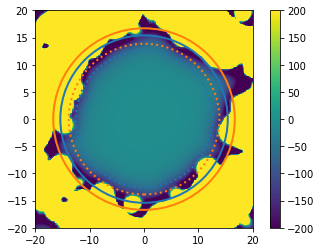

In [109]:
extent = (np.min(rmeshpoints[:,0]),np.max(rmeshpoints[:,0]),np.min(rmeshpoints[:,1]),np.max(rmeshpoints[:,1]))
fig,ax=plt.subplots()
im = ax.imshow(grid_z1.T,origin='lower',extent=extent,vmax=200,vmin=-200)#,cmap="Spectral_r")
circ = Circle((0,0),R_mean_int_sixty_5,facecolor='None',edgecolor='C0',linewidth=2)
circ2 = Circle((0,0),r_min_int_sixty_5,facecolor='None',edgecolor='C0',linestyle = ":",linewidth=2)
circ_full = Circle((0,0),R_mean_full_int_sixty_5,facecolor='None',edgecolor='C1',linewidth=2)
circ2_full = Circle((0,0),r_min_full_int_sixty_5,facecolor='None',edgecolor='C1',linestyle = ":",linewidth=2)
ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ_full)
ax.add_patch(circ2_full)
cbar = fig.colorbar(im)

# Gathering the data

In [134]:
method_1 = {"σ_1":σ_1,
            "nε_1":nε_1,
            "R_1":R_1,
            "σ_error_1":σ_error_1,
            "nε_error_1":nε_error_1,
            "R_error_1":R_error_1,
            "r_1":r_1,
            "U_1":U_1,
            "cartesian_linear":grid_z1,
            "cartesian_extent":extent,
            "cartesian_x":grid_x,
            "cartesian_y":grid_y,
            "polar_linear":polar_linear,
            "polar_phi":grid_phi,
            "polar_r":grid_r,
            "r_min_1":r_min_1,
            "U_min_1":U_min_1
           }
#NOTE: r_1 and U_1 are the result of integrating over all angles
#      cartesian_linear is the linear interpolation over the effective manybody potential at z=0

In [135]:
method_2 = {"σ_2":σ_2,
            "nε_2":nε_2,
            "R_2":R_2,
            "σ_error_2":σ_error_2,
            "nε_error_2":nε_error_2,
            "R_error_2":R_error_2,
            "phis_2":phis_2,
            "σ_not_outlier_2":σ_not_outlier_2,
            "nε_not_outlier_2":nε_not_outlier_2,
            "R_not_outlier_2":R_not_outlier_2,
            "σ_outlier_2":σ_outlier_2,
            "nε_outlier_2":nε_outlier_2,
            "R_outlier_2":R_outlier_2,
            "σ_mean_2":σ_mean_2,
            "nε_mean_2":nε_mean_2,
            "R_mean_2":R_mean_2,
            "σ_mean_full_2":σ_mean_full_2,
            "nε_mean_full_2":nε_mean_full_2,
            "R_mean_full_2":R_mean_full_2,
            "r_min_2":r_min_2,
            "U_min_2":U_min_2,
            "r_min_full_2":r_min_full_2,
            "U_min_full_2":U_min_full_2,
            "r_cutoff_2":r_cutoff_2
           }


In [136]:
method_3 = {"σ_3":σ_3,
            "nε_3":nε_3,
            "R_3":R_3,
            "σ_error_3":σ_error_3,
            "nε_error_3":nε_error_3,
            "R_error_3":R_error_3,
            "r_min_3":r_min_3,
            "U_min_3":U_min_3,
            "σ_close_3":σ_close_3,
            "nε_close_3":nε_close_3,
            "R_close_3":R_close_3,
            "σ_error_close_3":σ_error_close_3,
            "nε_error_close_3":nε_error_close_3,
            "R_error_close_3":R_error_close_3,
            "r_min_close_3":r_min_close_3,
            "U_min_close_3":U_min_close_3,
            "r_cutoff_3":r_cutoff_3,
            "r_cutoff_close_3":r_cutoff_close_3
           }


In [137]:
method_ten_4 = {"σ_ten_4":σ_ten_4,
            "nε_ten_4":nε_ten_4,
            "R_ten_4":R_ten_4,
            "σ_error_ten_4":σ_error_ten_4,
            "nε_error_ten_4":nε_error_ten_4,
            "R_error_ten_4":R_error_ten_4,
            "phis_ten_4":phis_ten_4,
            "σ_not_outlier_ten_4":σ_not_outlier_ten_4,
            "nε_not_outlier_ten_4":nε_not_outlier_ten_4,
            "R_not_outlier_ten_4":R_not_outlier_ten_4,
            "σ_outlier_ten_4":σ_outlier_ten_4,
            "nε_outlier_ten_4":nε_outlier_ten_4,
            "R_outlier_ten_4":R_outlier_ten_4,
            "σ_mean_ten_4":σ_mean_ten_4,
            "nε_mean_ten_4":nε_mean_ten_4,
            "R_mean_ten_4":R_mean_ten_4,
            "σ_mean_full_ten_4":σ_mean_full_ten_4,
            "nε_mean_full_ten_4":nε_mean_full_ten_4,
            "R_mean_full_ten_4":R_mean_full_ten_4,
            "r_min_ten_4":r_min_ten_4,
            "U_min_ten_4":U_min_ten_4,
            "r_min_full_ten_4":r_min_full_ten_4,
            "U_min_full_ten_4":U_min_full_ten_4,
            "r_cutoff_ten_4":r_cutoff_ten_4,
            "dϕ_ten_4":10.0
           }


In [138]:
method_five_4 = {"σ_five_4":σ_five_4,
            "nε_five_4":nε_five_4,
            "R_five_4":R_five_4,
            "σ_error_five_4":σ_error_five_4,
            "nε_error_five_4":nε_error_five_4,
            "R_error_five_4":R_error_five_4,
            "phis_five_4":phis_five_4,
            "σ_not_outlier_five_4":σ_not_outlier_five_4,
            "nε_not_outlier_five_4":nε_not_outlier_five_4,
            "R_not_outlier_five_4":R_not_outlier_five_4,
            "σ_outlier_five_4":σ_outlier_five_4,
            "nε_outlier_five_4":nε_outlier_five_4,
            "R_outlier_five_4":R_outlier_five_4,
            "σ_mean_five_4":σ_mean_five_4,
            "nε_mean_five_4":nε_mean_five_4,
            "R_mean_five_4":R_mean_five_4,
            "σ_mean_full_five_4":σ_mean_full_five_4,
            "nε_mean_full_five_4":nε_mean_full_five_4,
            "R_mean_full_five_4":R_mean_full_five_4,
            "r_min_five_4":r_min_five_4,
            "U_min_five_4":U_min_five_4,
            "r_min_full_five_4":r_min_full_five_4,
            "U_min_full_five_4":U_min_full_five_4,
            "r_cutoff_five_4":r_cutoff_five_4,
            "dϕ_five_4":5.0
           }


In [139]:
method_one_4 = {"σ_one_4":σ_one_4,
            "nε_one_4":nε_one_4,
            "R_one_4":R_one_4,
            "σ_error_one_4":σ_error_one_4,
            "nε_error_one_4":nε_error_one_4,
            "R_error_one_4":R_error_one_4,
            "phis_one_4":phis_one_4,
            "σ_not_outlier_one_4":σ_not_outlier_one_4,
            "nε_not_outlier_one_4":nε_not_outlier_one_4,
            "R_not_outlier_one_4":R_not_outlier_one_4,
            "σ_outlier_one_4":σ_outlier_one_4,
            "nε_outlier_one_4":nε_outlier_one_4,
            "R_outlier_one_4":R_outlier_one_4,
            "σ_mean_one_4":σ_mean_one_4,
            "nε_mean_one_4":nε_mean_one_4,
            "R_mean_one_4":R_mean_one_4,
            "σ_mean_full_one_4":σ_mean_full_one_4,
            "nε_mean_full_one_4":nε_mean_full_one_4,
            "R_mean_full_one_4":R_mean_full_one_4,
            "r_min_one_4":r_min_one_4,
            "U_min_one_4":U_min_one_4,
            "r_min_full_one_4":r_min_full_one_4,
            "U_min_full_one_4":U_min_full_one_4,
            "r_cutoff_one_4":r_cutoff_one_4,
            "dϕ_one_4":1.0
           }


In [140]:
method_thirty_4 = {"σ_thirty_4":σ_thirty_4,
            "nε_thirty_4":nε_thirty_4,
            "R_thirty_4":R_thirty_4,
            "σ_error_thirty_4":σ_error_thirty_4,
            "nε_error_thirty_4":nε_error_thirty_4,
            "R_error_thirty_4":R_error_thirty_4,
            "phis_thirty_4":phis_thirty_4,
            "σ_not_outlier_thirty_4":σ_not_outlier_thirty_4,
            "nε_not_outlier_thirty_4":nε_not_outlier_thirty_4,
            "R_not_outlier_thirty_4":R_not_outlier_thirty_4,
            "σ_outlier_thirty_4":σ_outlier_thirty_4,
            "nε_outlier_thirty_4":nε_outlier_thirty_4,
            "R_outlier_thirty_4":R_outlier_thirty_4,
            "σ_mean_thirty_4":σ_mean_thirty_4,
            "nε_mean_thirty_4":nε_mean_thirty_4,
            "R_mean_thirty_4":R_mean_thirty_4,
            "σ_mean_full_thirty_4":σ_mean_full_thirty_4,
            "nε_mean_full_thirty_4":nε_mean_full_thirty_4,
            "R_mean_full_thirty_4":R_mean_full_thirty_4,
            "r_min_thirty_4":r_min_thirty_4,
            "U_min_thirty_4":U_min_thirty_4,
            "r_min_full_thirty_4":r_min_full_thirty_4,
            "U_min_full_thirty_4":U_min_full_thirty_4,
            "r_cutoff_thirty_4":r_cutoff_thirty_4,
            "dϕ_thirty_4":30.0
           }


In [141]:
method_sixty_4 = {"σ_sixty_4":σ_sixty_4,
            "nε_sixty_4":nε_sixty_4,
            "R_sixty_4":R_sixty_4,
            "σ_error_sixty_4":σ_error_sixty_4,
            "nε_error_sixty_4":nε_error_sixty_4,
            "R_error_sixty_4":R_error_sixty_4,
            "phis_sixty_4":phis_sixty_4,
            "σ_not_outlier_sixty_4":σ_not_outlier_sixty_4,
            "nε_not_outlier_sixty_4":nε_not_outlier_sixty_4,
            "R_not_outlier_sixty_4":R_not_outlier_sixty_4,
            "σ_outlier_sixty_4":σ_outlier_sixty_4,
            "nε_outlier_sixty_4":nε_outlier_sixty_4,
            "R_outlier_sixty_4":R_outlier_sixty_4,
            "σ_mean_sixty_4":σ_mean_sixty_4,
            "nε_mean_sixty_4":nε_mean_sixty_4,
            "R_mean_sixty_4":R_mean_sixty_4,
            "σ_mean_full_sixty_4":σ_mean_full_sixty_4,
            "nε_mean_full_sixty_4":nε_mean_full_sixty_4,
            "R_mean_full_sixty_4":R_mean_full_sixty_4,
            "r_min_sixty_4":r_min_sixty_4,
            "U_min_sixty_4":U_min_sixty_4,
            "r_min_full_sixty_4":r_min_full_sixty_4,
            "U_min_full_sixty_4":U_min_full_sixty_4,
            "r_cutoff_sixty_4":r_cutoff_sixty_4,
            "dϕ_sixty_4":60.0
           }


In [142]:
method_int_ten_5 = {"σ_int_ten_5":σ_int_ten_5,
            "nε_int_ten_5":nε_int_ten_5,
            "R_int_ten_5":R_int_ten_5,
            "σ_error_int_ten_5":σ_error_int_ten_5,
            "nε_error_int_ten_5":nε_error_int_ten_5,
            "R_error_int_ten_5":R_error_int_ten_5,
            "phis_int_ten_5":phis_int_ten_5,
            "σ_not_outlier_int_ten_5":σ_not_outlier_int_ten_5,
            "nε_not_outlier_int_ten_5":nε_not_outlier_int_ten_5,
            "R_not_outlier_int_ten_5":R_not_outlier_int_ten_5,
            "σ_outlier_int_ten_5":σ_outlier_int_ten_5,
            "nε_outlier_int_ten_5":nε_outlier_int_ten_5,
            "R_outlier_int_ten_5":R_outlier_int_ten_5,
            "σ_mean_int_ten_5":σ_mean_int_ten_5,
            "nε_mean_int_ten_5":nε_mean_int_ten_5,
            "R_mean_int_ten_5":R_mean_int_ten_5,
            "σ_mean_full_int_ten_5":σ_mean_full_int_ten_5,
            "nε_mean_full_int_ten_5":nε_mean_full_int_ten_5,
            "R_mean_full_int_ten_5":R_mean_full_int_ten_5,
            "r_min_int_ten_5":r_min_int_ten_5,
            "U_min_int_ten_5":U_min_int_ten_5,
            "r_min_full_int_ten_5":r_min_full_int_ten_5,
            "U_min_full_int_ten_5":U_min_full_int_ten_5,
            "r_cutoff_int_ten_5":r_cutoff_int_ten_5,
            "dϕ_int_ten_5":10.0
           }


In [143]:
method_int_five_5 = {"σ_int_five_5":σ_int_five_5,
            "nε_int_five_5":nε_int_five_5,
            "R_int_five_5":R_int_five_5,
            "σ_error_int_five_5":σ_error_int_five_5,
            "nε_error_int_five_5":nε_error_int_five_5,
            "R_error_int_five_5":R_error_int_five_5,
            "phis_int_five_5":phis_int_five_5,
            "σ_not_outlier_int_five_5":σ_not_outlier_int_five_5,
            "nε_not_outlier_int_five_5":nε_not_outlier_int_five_5,
            "R_not_outlier_int_five_5":R_not_outlier_int_five_5,
            "σ_outlier_int_five_5":σ_outlier_int_five_5,
            "nε_outlier_int_five_5":nε_outlier_int_five_5,
            "R_outlier_int_five_5":R_outlier_int_five_5,
            "σ_mean_int_five_5":σ_mean_int_five_5,
            "nε_mean_int_five_5":nε_mean_int_five_5,
            "R_mean_int_five_5":R_mean_int_five_5,
            "σ_mean_full_int_five_5":σ_mean_full_int_five_5,
            "nε_mean_full_int_five_5":nε_mean_full_int_five_5,
            "R_mean_full_int_five_5":R_mean_full_int_five_5,
            "r_min_int_five_5":r_min_int_five_5,
            "U_min_int_five_5":U_min_int_five_5,
            "r_min_full_int_five_5":r_min_full_int_five_5,
            "U_min_full_int_five_5":U_min_full_int_five_5,
            "r_cutoff_int_five_5":r_cutoff_int_five_5,
            "dϕ_int_five_5":5.0
           }


In [144]:
method_int_one_5 = {"σ_int_one_5":σ_int_one_5,
            "nε_int_one_5":nε_int_one_5,
            "R_int_one_5":R_int_one_5,
            "σ_error_int_one_5":σ_error_int_one_5,
            "nε_error_int_one_5":nε_error_int_one_5,
            "R_error_int_one_5":R_error_int_one_5,
            "phis_int_one_5":phis_int_one_5,
            "σ_not_outlier_int_one_5":σ_not_outlier_int_one_5,
            "nε_not_outlier_int_one_5":nε_not_outlier_int_one_5,
            "R_not_outlier_int_one_5":R_not_outlier_int_one_5,
            "σ_outlier_int_one_5":σ_outlier_int_one_5,
            "nε_outlier_int_one_5":nε_outlier_int_one_5,
            "R_outlier_int_one_5":R_outlier_int_one_5,
            "σ_mean_int_one_5":σ_mean_int_one_5,
            "nε_mean_int_one_5":nε_mean_int_one_5,
            "R_mean_int_one_5":R_mean_int_one_5,
            "σ_mean_full_int_one_5":σ_mean_full_int_one_5,
            "nε_mean_full_int_one_5":nε_mean_full_int_one_5,
            "R_mean_full_int_one_5":R_mean_full_int_one_5,
            "r_min_int_one_5":r_min_int_one_5,
            "U_min_int_one_5":U_min_int_one_5,
            "r_min_full_int_one_5":r_min_full_int_one_5,
            "U_min_full_int_one_5":U_min_full_int_one_5,
            "r_cutoff_int_one_5":r_cutoff_int_one_5,
            "dϕ_int_one_5":1.0
           }


In [145]:
method_int_thirty_5 = {"σ_int_thirty_5":σ_int_thirty_5,
            "nε_int_thirty_5":nε_int_thirty_5,
            "R_int_thirty_5":R_int_thirty_5,
            "σ_error_int_thirty_5":σ_error_int_thirty_5,
            "nε_error_int_thirty_5":nε_error_int_thirty_5,
            "R_error_int_thirty_5":R_error_int_thirty_5,
            "phis_int_thirty_5":phis_int_thirty_5,
            "σ_not_outlier_int_thirty_5":σ_not_outlier_int_thirty_5,
            "nε_not_outlier_int_thirty_5":nε_not_outlier_int_thirty_5,
            "R_not_outlier_int_thirty_5":R_not_outlier_int_thirty_5,
            "σ_outlier_int_thirty_5":σ_outlier_int_thirty_5,
            "nε_outlier_int_thirty_5":nε_outlier_int_thirty_5,
            "R_outlier_int_thirty_5":R_outlier_int_thirty_5,
            "σ_mean_int_thirty_5":σ_mean_int_thirty_5,
            "nε_mean_int_thirty_5":nε_mean_int_thirty_5,
            "R_mean_int_thirty_5":R_mean_int_thirty_5,
            "σ_mean_full_int_thirty_5":σ_mean_full_int_thirty_5,
            "nε_mean_full_int_thirty_5":nε_mean_full_int_thirty_5,
            "R_mean_full_int_thirty_5":R_mean_full_int_thirty_5,
            "r_min_int_thirty_5":r_min_int_thirty_5,
            "U_min_int_thirty_5":U_min_int_thirty_5,
            "r_min_full_int_thirty_5":r_min_full_int_thirty_5,
            "U_min_full_int_thirty_5":U_min_full_int_thirty_5,
            "r_cutoff_int_thirty_5":r_cutoff_int_thirty_5,
            "dϕ_int_thirty_5":30.0
           }


In [146]:
method_int_sixty_5 = {"σ_int_sixty_5":σ_int_sixty_5,
            "nε_int_sixty_5":nε_int_sixty_5,
            "R_int_sixty_5":R_int_sixty_5,
            "σ_error_int_sixty_5":σ_error_int_sixty_5,
            "nε_error_int_sixty_5":nε_error_int_sixty_5,
            "R_error_int_sixty_5":R_error_int_sixty_5,
            "phis_int_sixty_5":phis_int_sixty_5,
            "σ_not_outlier_int_sixty_5":σ_not_outlier_int_sixty_5,
            "nε_not_outlier_int_sixty_5":nε_not_outlier_int_sixty_5,
            "R_not_outlier_int_sixty_5":R_not_outlier_int_sixty_5,
            "σ_outlier_int_sixty_5":σ_outlier_int_sixty_5,
            "nε_outlier_int_sixty_5":nε_outlier_int_sixty_5,
            "R_outlier_int_sixty_5":R_outlier_int_sixty_5,
            "σ_mean_int_sixty_5":σ_mean_int_sixty_5,
            "nε_mean_int_sixty_5":nε_mean_int_sixty_5,
            "R_mean_int_sixty_5":R_mean_int_sixty_5,
            "σ_mean_full_int_sixty_5":σ_mean_full_int_sixty_5,
            "nε_mean_full_int_sixty_5":nε_mean_full_int_sixty_5,
            "R_mean_full_int_sixty_5":R_mean_full_int_sixty_5,
            "r_min_int_sixty_5":r_min_int_sixty_5,
            "U_min_int_sixty_5":U_min_int_sixty_5,
            "r_min_full_int_sixty_5":r_min_full_int_sixty_5,
            "U_min_full_int_sixty_5":U_min_full_int_sixty_5,
            "r_cutoff_int_sixty_5":r_cutoff_int_sixty_5,
            "dϕ_int_sixty_5":60.0
           }


In [147]:
import pickle
def save_as_pickle(fn,data):
    with open(fn, 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [148]:
save_as_pickle("data/method_1.pickle",method_1)
save_as_pickle("data/method_2.pickle",method_2)
save_as_pickle("data/method_3.pickle",method_3)
save_as_pickle("data/method_ten_4.pickle",method_ten_4)
save_as_pickle("data/method_five_4.pickle",method_five_4)
save_as_pickle("data/method_one_4.pickle",method_one_4)
save_as_pickle("data/method_thirty_4.pickle",method_thirty_4)
save_as_pickle("data/method_sixty_4.pickle",method_sixty_4)
save_as_pickle("data/method_int_ten_5.pickle",method_int_ten_5)
save_as_pickle("data/method_int_five_5.pickle",method_int_five_5)
save_as_pickle("data/method_int_one_5.pickle",method_int_one_5)
save_as_pickle("data/method_int_thirty_5.pickle",method_int_thirty_5)
save_as_pickle("data/method_int_sixty_5.pickle",method_int_sixty_5)

# JUNK
Includes fixing $R$ and linearizing $U_\mathrm{cyl}$

In [ ]:
raise

In [108]:
def U_min2(r,sigma,n):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return Veffective(r,sigma,n,pore_radius)

In [103]:
from scipy.optimize import curve_fit
xdata = np.linalg.norm(rmeshpoints,axis=-1)
ydata = Vmesh_cut
r_cut_fit = pore_radius
#r_cut_fit = 10.0
#r_cut_fit = np.max(xdata)
# The extreme values found within the pore walls may cause issues with fitting, so let's restrict fitting to potential values less than 200
max_V = 200
fitind = (ydata < max_V) * (xdata < r_cut_fit)

popt, pcov = curve_fit(U_min_AB, xdata[fitind], ydata[fitind],[300000,5000,xdata.max()],bounds=([0.0,0.0,0.0],[np.inf,np.inf,np.inf]),maxfev = 10000)

perr = np.sqrt(np.diag(pcov))

print(perr)

print(popt)
popt_sne = AB_to_sigma_nepsilon_err(*popt[:-1],*perr[:-1])
print(popt_sne)

[4.98943546e+06 2.43295582e+02 7.24204127e-02]
[3.14713787e+07 5.36261020e+03 1.87104331e+01]
(4.247074929471602, 0.8725856634325106, 0.11672567376230207, 0.15939419433396923)


In [323]:
print(r'$\sigma={:.3f}\mathrm{{\unicode{{x212B}}}}$, $n\epsilon = {:.3f}\mathrm{{K\unicode{{x212B}}^{{-2}}}}$, and $R={:.3f}\mathrm{{\unicode{{x212B}}}}$'.format(fit_sigma_mean_fixed_radius,fit_nepsilon_mean_fixed_radius,pore_radius))

$\sigma=1.136\mathrm{\unicode{x212B}}$, $n\epsilon = 36.530\mathrm{K\unicode{x212B}^{-2}}$, and $R=15.510\mathrm{\unicode{x212B}}$


In [324]:
print("σ error: {}".format(fit_sigma_err_fixed_radius))
print("nε error: {}".format(fit_nepsilon_err_fixed_radius))

σ error: 0.010496567537372001
nε error: 3.6182790061675134


In [98]:
def U_min_AB(r,A,B,R):
    return Veffective_AB(r,A,B,R)

In [99]:
def U_min2_AB(r,A,B):
    pore_radius = 15.51 # see https://doi.org/10.1016/j.apsusc.2015.01.084
    return Veffective_AB(r,A,B,pore_radius)

In [100]:
def sigma_nepsilon_to_AB(sigma,n_epsilon):
    A = (sigma**9)*np.pi*n_epsilon*(sigma**3)/3.0
    B = (sigma**3)*np.pi*n_epsilon*(sigma**3)/3.0
    return A,B

def sigma_nepsilon_to_AB_err(sigma,n_epsilon,sigma_err,n_epsilon_err):
    A = (sigma**12)*np.pi*n_epsilon/3
    B = (sigma**6)*np.pi*n_epsilon/3
    A_err = np.sqrt((((4*np.pi*(sigma**11)*n_epsilon) * sigma_err)**2) + ((((sigma**12)*np.pi/3) * n_epsilon_err)**2))
    B_err = np.sqrt((((2*np.pi*(sigma**5)*n_epsilon) * sigma_err)**2) + ((((sigma**6)*np.pi/3) * n_epsilon_err)**2))
    return A,B,A_err,B_err

def AB_to_sigma_nepsilon(A,B):
    sigma = ((A/B)**(1/6))
    n_epsilon = 3.0*(B**2)/A/(np.pi)
    return sigma,n_epsilon

def AB_to_sigma_nepsilon_err(A,B,A_err,B_err):
    sigma = ((A/B)**(1/6))
    sigma_err = np.sqrt((((((A/B)**(1/6))/(6*A)) * A_err)**2) + (((((A/B)**(1/6))/(-6*B)) * B_err)**2))
    n_epsilon = 3*(B**2)/A/np.pi
    n_epsilon_err = np.sqrt((((-3*(B**2)/(A**2)/(np.pi)) * A_err)**2) + (((6*B/A/np.pi) * B_err)**2))
    return sigma,n_epsilon,sigma_err,n_epsilon_err